# Imports & General settings
change paths for your environments and folder architecture

In [1]:
%%time
# Standard library imports
import argparse
from datetime import datetime
import glob
import gzip
import io
import json
import logging as log
import os
import requests
import shutil
import subprocess
import sys
import urllib.parse
import urllib.request

# Third party imports
from adjustText import adjust_text
from Bio.PDB import PDBParser
from Bio.PDB.PDBList import PDBList 
from Bio.PDB.DSSP import DSSP
import circlify
from IPython.display import display
import math
import ipywidgets
%matplotlib inline
from matplotlib.colors import LogNorm, ColorConverter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.cluster.hierarchy as sch
import sklearn.model_selection
from sklearn.metrics import mean_squared_error
import squarify
import xmltodict


CPU times: user 3.54 s, sys: 5.49 s, total: 9.03 s
Wall time: 18.6 s


In [2]:
log_message="verbose"

if log_message=="verbose":
    log.basicConfig(
        format='%(levelname)s:%(message)s',
        datefmt='%m/%d/%Y %I:%M:%S %p',
        level=log.INFO
    )
elif log_message=="debug":
    log.basicConfig(
        format='%(levelname)s:%(message)s',
        datefmt='%m/%d/%Y %I:%M:%S %p',
        level=log.WARNING
    )
else:
    log.basicConfig(
        format='%(levelname)s:%(message)s',
        datefmt='%m/%d/%Y %I:%M:%S %p',
        level=log.ERROR
    )

logger = log.getLogger(__name__)


In [3]:
# General settings

saving_dir_flag = 'projects/Xray_calc'

basepath = ''
shared_basepath = 'path_to_prism_data'
path_to_script_exec_dir = '_path_to_software_/PRISM_tools/rosetta_stability-v0.2.2/'


# Local application imports
try:
    sys.path.insert(1, os.path.join(path_to_script_exec_dir, 'software/scripts'))
    from FillVariants import copy_wt_variants
    from prism_parser_helper import read_prism, merge_prism_df
    from pdb_to_prism import pdb_to_prism

except (ModuleNotFoundError, ImportError) as e:
    logger.error("{} fileure".format(type(e)))
    print(e)
else:
    logger.info("Import succeeded")
    

/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
INFO:Import succeeded
INFO:Import succeeded
INFO:Import succeeded


In [4]:
timeflag = '2022_05_05'

working_dir = os.path.join(basepath, saving_dir_flag)
os.makedirs(working_dir, exist_ok=True)

plots_dir = os.path.join(working_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

tables_dir = os.path.join(working_dir, 'tables')
os.makedirs(tables_dir, exist_ok=True)

tmp_dir = os.path.join(working_dir, 'tmp')
os.makedirs(tmp_dir, exist_ok=True)

input_data_dir = os.path.join(working_dir, 'data')
os.makedirs(tables_dir, exist_ok=True)

input_dir = os.path.join(working_dir, 'input')
os.makedirs(input_dir, exist_ok=True)

shared_prism_dir = os.path.join(shared_basepath, 'prism')
shared_pdb_prism_dir = os.path.join(shared_basepath, 'prism_pdb')

struc_sele_script = os.path.join(path_to_script_exec_dir, 'software/scripts/struc_select_sifts.py')
path_to_python = 'python3'

#wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz
#gunzip HUMAN_9606_idmapping.dat.gz

morbid_file = os.path.join(input_data_dir, f'{timeflag}-morbidmap.txt')
genemap2_file = os.path.join(input_data_dir, f'{timeflag}-genemap2.txt')


# get MP uniprot ids

## Functions

In [5]:
def extract_MP_uniprot():
    url_base = "https://www.uniprot.org/uniprot/"
    search_params = "?query=reviewed:yes" +\
        "+annotation%3A%28type%3Apositional+transmembrane%29" +\
        "+OR+annotation%3A%28type%3Apositional+intramembrane%29"
    return_params = "+&format=tab&" +\
        "columns=id" +\
        ",entry%20name" +\
        ",protein%20name" +\
        ",genes(PREFERRED)" +\
        ",organism" +\
        ",length" +\
        ",feature(TRANSMEMBRANE)" +\
        ",feature(INTRAMEMBRANE)" +\
        ",feature(TOPOLOGICAL%20DOMAIN)" +\
        ""
    url = url_base+search_params+return_params

    data_array = []
    for line in urllib.request.urlopen(url):
        line = line.decode('utf-8')
        unprocessed = line[:-1].split('\t')
        data_array.append(unprocessed)

    return data_array
def extract_MP_uniprot_beta():
    url_base = "https://rest.uniprot.org/beta/uniprotkb/search"
    search_params = "?query=reviewed:true" +\
        "+ft_topo_dom" +\
        "+OR+ft_transmem+OR+ft_intramem"
    return_params = "+&format=tab&" +\
        "columns=id" +\
        ",entry%20name" +\
        ",protein%20name" +\
        ",genes(PREFERRED)" +\
        ",organism" +\
        ",length" +\
        ",feature(TRANSMEMBRANE)" +\
        ",feature(INTRAMEMBRANE)" +\
        ",feature(TOPOLOGICAL%20DOMAIN)" +\
        ""
    url = url_base+search_params+return_params
    print(url)
    data_array = []
    for line in urllib.request.urlopen(url):
        line = line.decode('utf-8')
        unprocessed = line[:-1].split('\t')
        data_array.append(unprocessed)

    return data_array

In [6]:
def extract_MP_ebi(human=True):

    if human:
        requestURL = "https://www.ebi.ac.uk/proteins/api/features?offset=0&size=-1&organism=homo%20sapiens&types=TRANSMEM%2CINTRAMEM"
    else:
        logger.warn('currently not implemented to get all :(')
        sys.exit()
        #requestURL = "https://www.ebi.ac.uk/proteins/api/features?offset=0&size=-1&types=TRANSMEM%2CINTRAMEM"

    r = requests.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
        r.raise_for_status()
        sys.exit()

    j = r.json()
    df = pd.DataFrame.from_dict(j)
    
    return df

In [7]:
def check_memb(prism_data, filename):
    MP_columns = ['TRANSMEM','INTRAMEM','TOPO_DOM','LIPID',]
    for column in prism_data.metadata['columns']:
        if column in MP_columns:
            return filename

## Execution

In [8]:
%%time
unique_hMP_ebi_csv = os.path.join(tables_dir, f'{timeflag}-ebi_hMP_entries.csv')
if os.path.isfile(unique_hMP_ebi_csv):
    logger.info('Read dataframe from existing files...')
    unique_hMP_ebi = pd.read_csv(unique_hMP_ebi_csv)
else:
    logger.info('No existing files. Generate new files - estimated time: ~ 20min')
    unique_hMP_ebi = extract_MP_ebi(human=True)
    unique_hMP_ebi = unique_hMP_ebi[unique_hMP_ebi["entryName"].str.contains("HUMAN")].reset_index(drop=True)
    unique_hMP_ebi.to_csv(unique_hMP_ebi_csv)
logger.info(f'human MP in ebi: {len(unique_hMP_ebi["accession"].unique())}')


INFO:Read dataframe from existing files...
INFO:human MP in ebi: 43365


CPU times: user 769 ms, sys: 69.7 ms, total: 839 ms
Wall time: 855 ms


In [9]:
%%time
unique_hMP_uniprot_csv = os.path.join(working_dir, f'{timeflag}-uniprot_hMP_entries.csv')
if os.path.isfile(unique_hMP_uniprot_csv):
    logger.info('Read dataframe from existing files...')
    unique_hMP_uniprot = pd.read_csv(unique_hMP_uniprot_csv)  
else:
    logger.info('No existing files. Generate new files - estimated time: ~ 5 min')
    uniprot_MP = extract_MP_uniprot()
    data_array_uniprot = pd.DataFrame(uniprot_MP[1:],columns=uniprot_MP[0])
    unique_hMP_uniprot = data_array_uniprot[data_array_uniprot["Entry name"].str.contains("HUMAN")].reset_index(drop=True)
    unique_hMP_uniprot.to_csv(unique_hMP_uniprot_csv)
logger.info(f'human MP in uniprot: {len(unique_hMP_uniprot["Entry"].unique())}')


INFO:Read dataframe from existing files...
INFO:human MP in uniprot: 20376


CPU times: user 109 ms, sys: 11.5 ms, total: 120 ms
Wall time: 136 ms


In [10]:
unique_hMP_uniprot['db_uniprot'] = True
unique_hMP_ebi['db_ebi'] = True
unique_hMP_uniprot = unique_hMP_uniprot.rename(columns={"Entry": "accession", "Entry name": "entryName"})
hMP_merged_dfs = pd.merge(unique_hMP_uniprot, unique_hMP_ebi,  how='outer', on = ['accession','entryName']).replace(np.nan, False)
hMP_merged_dfs = hMP_merged_dfs[['accession', 'entryName', 'db_uniprot', 'db_ebi']]
logger.info(hMP_merged_dfs['db_uniprot'].value_counts())
logger.info(hMP_merged_dfs['db_ebi'].value_counts())
hMP_merged_dfs

INFO:False    38147
True     20376
Name: db_uniprot, dtype: int64
INFO:True     43365
False    15158
Name: db_ebi, dtype: int64


,accession,entryName,db_uniprot,db_ebi
0,P51451,BLK_HUMAN,True,False
1,A6H8Y1,BDP1_HUMAN,True,False
2,O60885,BRD4_HUMAN,True,False
3,Q9Y3X0,CCDC9_HUMAN,True,False
4,P22223,CADH3_HUMAN,True,True
...,...,...,...,...
58518,A0A023I9A1,A0A023I9A1_HUMAN,False,True
58519,A0A023I989,A0A023I989_HUMAN,False,True
58520,A0A023I954,A0A023I954_HUMAN,False,True
58521,A0A023I8N5,A0A023I8N5_HUMAN,False,True


In [11]:
intercept_hMP_ids = hMP_merged_dfs.copy()
intercept_hMP_ids = intercept_hMP_ids[(intercept_hMP_ids['db_uniprot'] == True) & (intercept_hMP_ids['db_ebi'] == True)].reset_index(drop=True)
intercept_hMP_ids = intercept_hMP_ids['accession'].unique()
intercept_hMP_ids.sort()
logger.info(f'Number of human MPs in both datasets: {len(intercept_hMP_ids)}')


INFO:Number of human MPs in both datasets: 5218


In [12]:
%%time
hMP_merged_anno_csv = os.path.join(working_dir, f'{timeflag}-merged_hMP_anno_entries.csv')
if os.path.isfile(hMP_merged_anno_csv):
    logger.info('Read dataframe from existing files...')
    hMP_anno_ids = pd.read_csv(hMP_merged_anno_csv)
else:
    logger.info('No existing files. Generate new files - estimated time: ~ 1h')
    error_list_touching = []
    hMP_merged_anno_dfs = []
    for index, hMP_id in enumerate(hMP_merged_dfs['accession'].unique()): #intercept_hMP_ids:
        if index%100 == 0:
            logger.info(index)
        uniprot_files = glob.glob(os.path.join(shared_prism_dir, hMP_id[0:2], hMP_id[2:4], hMP_id[4:6], f'prism_uniprot_*_{hMP_id}.txt'))
        try:
            #uniprot
            if len(uniprot_files) !=0:
                uniprot = read_prism(uniprot_files[0])
                anno_hMP = check_memb(uniprot, hMP_id)
                if anno_hMP:
                    hMP_merged_anno_dfs.append(anno_hMP)
        except:
            logger.info(f'Error at id {hMP_id}')
            error_list_touching.append(hMP_id, index=False)
            
    hMP_anno_ids = pd.DataFrame(columns=['accession'], data=hMP_merged_anno_dfs)
    hMP_anno_ids.to_csv(hMP_merged_anno_csv, index=False)
    
    logger.info('Done')
    print(len(error_list_touching))
hMP_anno_ids

INFO:Read dataframe from existing files...


CPU times: user 2.99 ms, sys: 6.58 ms, total: 9.57 ms
Wall time: 42.6 ms


,accession
0,P51451
1,P22223
2,Q9ULX7
3,Q53RY4
4,Q9HCJ2
...,...
5791,A0A0G2JLQ3
5792,A0A2R8YED5
5793,A0A1W2PQU2
5794,A0A1W2PQM1


## OMIM

### Functions

In [13]:
def read_mim_uniprot_mapping():
    import urllib
    link = "https://www.uniprot.org/docs/mimtosp.txt"
    uniprot2omim = {}

    f = urllib.request.urlopen(link)
    data = False
    previous_key = None
    for line in f:
        if line.decode('UTF-8') == '________________________________________________________________________\n':
            data=True
        elif line.decode('UTF-8') == '--------------------------------------------------------------------------------\n':
            data=False
        if data:
            processed_line = line.decode('UTF-8').strip().split(':')
            if len(processed_line)>1:
                mimID = processed_line[0]
                previous_key = mimID
                uniprot_ids = processed_line[1].split('(')
                if len(uniprot_ids)>1:
                    for elem in range(1,len(uniprot_ids)):
                        uniprot_id = uniprot_ids[elem].split(')')[0]
                        uniprot2omim[uniprot_id] = mimID
            elif len(processed_line)==1:
                uniprot_ids = processed_line[0].strip().split('(')
                if len(uniprot_ids)>1:
                    for elem in range(1,len(uniprot_ids)):
                        uniprot_id = uniprot_ids[elem].split(')')[0]
                        uniprot2omim[uniprot_id] = previous_key
    return uniprot2omim

def read_mim_henrike_uniprot(idmapping_file):
    omim2ensembl = {}
    uniprot_omim_df = pd.read_table(idmapping_file, header=None)
    uniprot_omim_df = uniprot_omim_df.rename(columns={0:'uniprot', 1:'resource', 2:'ID'})
    uniprot_omim_df = uniprot_omim_df[uniprot_omim_df['resource']=='MIM'].reset_index(drop=True)
    uniprot_omim_df = uniprot_omim_df.set_index('uniprot')[['ID']]
    uniprot2omim = uniprot_omim_df.to_dict()['ID']
    return uniprot2omim

def read_mim_ensembl_uniprot(idmapping_file):
    link = "https://omim.org/static/omim/data/mim2gene.txt"
    s=requests.get(link).content
    omim_ensembl = pd.read_csv(io.StringIO(s.decode('utf-8')), skiprows=4, sep='\t')
    omim_ensembl = omim_ensembl.rename(columns={'Ensembl Gene ID (Ensembl)':'Ensembl_ID', '# MIM Number': 'MIM_ID'})[['Ensembl_ID', 'MIM_ID']]
    omim_ensembl = omim_ensembl.dropna(subset=['Ensembl_ID']).reset_index(drop=True)
    mapper_df = pd.read_table(idmapping_file, header=None)
    mapper_df = mapper_df.rename(columns={0:'uniprot', 1:'resource', 2:'Ensembl_ID'})
    mapper_df = mapper_df[mapper_df['resource']=='Ensembl'].reset_index(drop=True)[['uniprot', 'Ensembl_ID']]
    omim_ensembl_merged = pd.merge(omim_ensembl, mapper_df, on='Ensembl_ID')[['uniprot', 'MIM_ID']].sort_values(by=['uniprot']).drop_duplicates()
    omim_ensembl_merged = omim_ensembl_merged.set_index('uniprot')[['MIM_ID']]
    uniprot2omim = omim_ensembl_merged.to_dict()['MIM_ID']
    return uniprot2omim

In [14]:
def get_orbidmap_df(morbid_file, known=True):
    morbidmap_df = pd.read_table(morbid_file, skiprows=3, skipfooter=24, sep='\t')
    # 1 - The disorder is placed on the map based on its association with
    # a gene, but the underlying defect is not known.
    # 2 - The disorder has been placed on the map by linkage or other
    # statistical method; no mutation has been found.
    # 3 - The molecular basis for the disorder is known; a mutation has been
    # found in the gene.
    # 4 - A contiguous gene deletion or duplication syndrome, multiple genes
    # are deleted or duplicated causing the phenotype.
    morbidmap_df['Phenotype_class'] = morbidmap_df['# Phenotype'].apply(lambda x: int(x[-2]))
    morbidmap_df['Phenotype_ID'] = morbidmap_df['# Phenotype'].apply(lambda x: x.split()[-2] if x.split()[-2].isdigit() else None)
    morbidmap_df['# Phenotype'] = morbidmap_df['# Phenotype'].apply(lambda x: ",".join(x.split(',')[:-1]) if x.split()[-2].isdigit() else x[:-4])
    morbidmap_df = morbidmap_df.rename(columns={'# Phenotype':'Phenotype', 'MIM Number': 'MIM_ID', 'Gene Symbols': 'Gene_Name', 'Cyto Location': 'Cyto_loc'})
    if known:
        morbidmap_df = morbidmap_df[morbidmap_df['Phenotype_class']==3].reset_index(drop=True)
    return morbidmap_df

In [15]:
def get_genemap2_df(genemap2_file, known=True):
    genemap2 = pd.read_table(genemap2_file, skiprows=3, skipfooter=76, sep='\t')
    # 1 - the disorder is placed on the map based on its association with
    # a gene, but the underlying defect is not known.
    # 2 - the disorder has been placed on the map by linkage; no mutation has
    # been found.
    # 3 - the molecular basis for the disorder is known; a mutation has been
    # found in the gene.
    # 4 - a contiguous gene deletion or duplication syndrome, multiple genes
    # are deleted or duplicated causing the phenotype.
    genemap2['MIM Number'] = genemap2['MIM Number'].astype(int)
    genemap2 = genemap2.rename(columns={'Phenotypes':'Phenotype', '# Chromosome':'Chromosome', 'MIM Number': 'MIM_ID', 'Gene Symbols': 'Gene_Name', 'Cyto Location': 'Cyto_loc'})

    return genemap2

### Execution

In [16]:
# get uniprot2omim
origin=2
if origin==0:
    uniprot2omim = read_mim_uniprot_mapping() #15,647
elif origin==1:
    uniprot2omim = read_mim_henrike_uniprot(os.path.join(input_data_dir, 'HUMAN_9606_idmapping.dat')) #15,647
elif origin==2:
    uniprot2omim = read_mim_ensembl_uniprot(os.path.join(input_data_dir, 'HUMAN_9606_idmapping.dat')) #65,883

logger.info(len(uniprot2omim))
uniprot2omim

INFO:65963


{'A0A024QZ33': 616173,
 'A0A024QZ42': 601057,
 'A0A024QZP7': 116940,
 'A0A024QZW4': 610845,
 'A0A024QZX5': 173321,
 'A0A024R0K5': 114890,
 'A0A024R0Y4': 602276,
 'A0A024R214': 607342,
 'A0A024R3B8': 619870,
 'A0A024R3B9': 123590,
 'A0A024R4E5': 142695,
 'A0A024R4K9': 616550,
 'A0A024R571': 605888,
 'A0A024R5G9': 603539,
 'A0A024R5I4': 604988,
 'A0A024R6J8': 601413,
 'A0A024R772': 601677,
 'A0A024R7E8': 619818,
 'A0A024R7P0': 603200,
 'A0A024R7W5': 618669,
 'A0A024R8F3': 604383,
 'A0A024RA28': 600124,
 'A0A024RAC6': 600786,
 'A0A024RBT2': 605219,
 'A0A024RBT8': 613481,
 'A0A024RCL3': 600169,
 'A0A024RCN4': 616474,
 'A0A024RDL5': 607270,
 'A0A067XG54': 300516,
 'A0A067XG57': 300516,
 'A0A075B6E2': 603474,
 'A0A075B6E4': 618692,
 'A0A075B6E5': 609061,
 'A0A075B6E9': 614453,
 'A0A075B6F3': 603337,
 'A0A075B6F6': 607106,
 'A0A075B6F9': 616759,
 'A0A075B6G3': 300377,
 'A0A075B6G4': 604210,
 'A0A075B6G5': 614006,
 'A0A075B6G6': 607307,
 'A0A075B6G7': 603448,
 'A0A075B6G8': 612658,
 'A0A075B6H

In [17]:
morbidmap_df = get_orbidmap_df(morbid_file, known=True)
morbidmap_df
#morbidmap_df[morbidmap_df['MIM_ID'] == uniprot2omim['P07550']]

/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


,Phenotype,Gene_Name,MIM_ID,Cyto_loc,Phenotype_class,Phenotype_ID
0,"17,20-lyase deficiency, isolated","CYP17A1, CYP17, P450C17",609300,10q24.32,3,202110
1,"17-alpha-hydroxylase/17,20-lyase deficiency","CYP17A1, CYP17, P450C17",609300,10q24.32,3,202110
2,"2,4-dienoyl-CoA reductase deficiency","NADK2, C5orf33, DECRD",615787,5p13.2,3,616034
3,2-methylbutyrylglycinuria,"ACADSB, SBCAD",600301,10q26.13,3,610006
4,3-M syndrome 1,"CUL7, 3M1",609577,6p21.1,3,273750
...,...,...,...,...,...,...
7162,"{West nile virus, susceptibility to}","CCR5, CMKBR5, CCCKR5, IDDM22",601373,3p21.31,3,610379
7163,"{Wilms tumor 6, susceptibility to}","REST, NRSF, WT6, GINGF5, HGF5, DFNA27",600571,4q12,3,616806
7164,{Wilms tumor susceptibility-5},"POU6F2, WTSL, WT5",609062,7p14.1,3,601583
7165,{Yao syndrome},"NOD2, CARD15, IBD1, CD, YAOS, BLAUS",605956,16q12.1,3,617321


In [18]:
genemap2_df = get_genemap2_df(genemap2_file, known=True)
genemap2_df
#logger.info(genemap2_df[genemap2_df['MIM_ID'] == uniprot2omim['P07550']]['Phenotype'].to_list())
#logger.info(genemap2_df['Chromosome'].unique())
#genemap2_df[genemap2_df['MIM_ID'] == uniprot2omim['P07550']]

/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


,Chromosome,Genomic Position Start,Genomic Position End,Cyto_loc,Computed Cyto Location,MIM_ID,Gene_Name,Gene Name,Approved Gene Symbol,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotype,Mouse Gene Symbol/ID
0,chr1,0,123400000,1p,NaN,606788,ANON1,"Anorexia nervosa, susceptibility to, 1",NaN,171514.0,NaN,NaN,"{Anorexia nervosa, susceptibility to, 1}, 6067...",NaN
1,chr1,0,2300000,1p36.33,NaN,618815,"C1DUPp36.33, DUP1p36.33","Chromosome 1p36.33 duplication syndrome, ATAD3...",NaN,NaN,NaN,NaN,"Chromosome 1p36.33 duplication syndrome, ATAD3...",NaN
2,chr1,0,20100000,1pter-p36.13,NaN,115665,"CTRCT8, CCV","Cataract, congenital, Volkmann type",NaN,7792.0,NaN,linked to Rh in Scottish family,"Cataract 8, multiple types, 115665 (2), Autoso...",NaN
3,chr1,0,27600000,1pter-p36,NaN,131190,"ERPL1, HLM2",Endogenous retroviral pol gene-like sequence 1...,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,0,123400000,1p,NaN,605606,PSORS7,Psoriasis susceptibility 7,NaN,65245.0,NaN,NaN,"{Psoriasis susceptibility 7}, 605606 (2)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17932,chrY,25622114,25625510,Yq11.23,Yq11.23,400016,"CDY1, CDY","Chromodomain protein, Y chromosome",CDY1,9085.0,ENSG00000172288,NaN,NaN,NaN
17933,chrY,25728489,25733387,Yq11.23,Yq11.23,400036,TTTY3,"Testis-specific transcript, Y-linked, 3",TTTY3,114760.0,ENSG00000231141,NaN,NaN,NaN
17934,chrY,26600000,57227415,Yq12,NaN,475000,"GCY, TSY, STA","Growth control, Y-chromosome influenced",NaN,2656.0,NaN,NaN,NaN,NaN
17935,chrY,0,57227415,Chr.Y,NaN,400043,DFNY1,"Deafness, Y-linked 1",NaN,724074.0,NaN,NaN,"Deafness, Y-linked 1, 400043 (2), Y-linked",NaN


# get gnomAD, clinvar, uniprot, pdb files

## Get PDB regions

### from RCSB

In [19]:
%%time
pdbrcsb_acc_csv = os.path.join(tables_dir, f'{timeflag}-pdbrcsb_acc_hMP.csv')
if os.path.isfile(pdbrcsb_acc_csv):
    logger.info('Read dataframe from existing files...')
    pdbrcsb_acc_df = pd.read_csv(pdbrcsb_acc_csv)
else:
    logger.info('No existing files. Generate new files - estimated time: > 1h')
    pdbrcsb_acc_df = [['accession', 'pdb_id', 'pdb_chain', 'pdb_instance', 'pdb_score', 'pdb_resolution']]
    for index, accession_id in enumerate(hMP_anno_ids['accession'].unique()):
        if index%100 == 0:
            print(index)
        search_string = f"https://search.rcsb.org/rcsbsearch/v1/query?json=%7B%22query%22%3A%7B%22type%22%3A%22group%22%2C%22logical_operator%22%3A%22and%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22operator%22%3A%22exact_match%22%2C%22value%22%3A%22{accession_id}%22%2C%22attribute%22%3A%22rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession%22%7D%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22operator%22%3A%22exact_match%22%2C%22value%22%3A%22UniProt%22%2C%22attribute%22%3A%22rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_name%22%7D%7D%5D%7D%2C%22return_type%22%3A%22polymer_instance%22%7D"
        r = urllib.request.urlopen(search_string)
        search_string2 = f"https://search.rcsb.org/rcsbsearch/v1/query?json=%7B%22query%22%3A%7B%22type%22%3A%22group%22%2C%22logical_operator%22%3A%22and%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22operator%22%3A%22exact_match%22%2C%22value%22%3A%22{accession_id}%22%2C%22attribute%22%3A%22rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession%22%7D%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22operator%22%3A%22exact_match%22%2C%22value%22%3A%22UniProt%22%2C%22attribute%22%3A%22rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_name%22%7D%7D%5D%7D%2C%22return_type%22%3A%22polymer_entity%22%7D"
        r2 = urllib.request.urlopen(search_string2)
        try:
            data = json.loads(r.read())
            data2 = json.loads(r2.read())
            for indi, results in enumerate(data['result_set']):
                pdbrcsb_acc_df.append([accession_id, results['identifier'].split('.')[0], results['identifier'].split('.')[1], data2['result_set'][indi]['identifier'].split('_')[1], results['score'], None])
        except:
            pass
    pdbrcsb_acc_df = pd.DataFrame(data=pdbrcsb_acc_df[1:], columns=pdbrcsb_acc_df[0])
    pdbrcsb_acc_df.to_csv(pdbrcsb_acc_csv, index=False)

pdbrcsb_acc_df

INFO:Read dataframe from existing files...


CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 18.4 ms


,accession,pdb_id,pdb_chain,pdb_instance,pdb_score,pdb_resolution
0,P22223,4OY9,A,1,1.0,NaN
1,P22223,4ZML,A,1,1.0,NaN
2,P22223,4ZMN,A,1,1.0,NaN
3,P22223,4ZMO,A,1,1.0,NaN
4,P22223,4ZMP,A,1,1.0,NaN
...,...,...,...,...,...,...
7342,Q6P179,4JBS,B,1,1.0,NaN
7343,Q6P179,5AB0,A,1,1.0,NaN
7344,Q6P179,5AB0,B,1,1.0,NaN
7345,Q6P179,5AB2,A,1,1.0,NaN


In [20]:
print(len(pdbrcsb_acc_df['accession'].unique()))
pdbrcsb_acc_df['accession'].unique()

1720


array(['P22223', 'Q9ULX7', 'Q9HCJ2', ..., 'Q9P0I2', 'P98172', 'Q6P179'],
      dtype=object)

In [21]:
%%time
#generate pdb prism files (takes quite long >>h)
pdbrcsb_acc_error_file = os.path.join(tmp_dir, f'{timeflag}-pdb_acc_hMP_error.csv')

if os.path.isfile(pdbrcsb_acc_error_file):
    logger.info('Read dataframe from existing files...')
    pdbrcsb_errors_df = pd.read_csv(pdbrcsb_acc_error_file)
    pdbs = pdbrcsb_errors_df.copy()
    pdbs['pdb_merge'] = pdbs['pdb_id'] + '_' + pdbs['pdb_chain']
    pdbs = list(pdbs['pdb_merge'].unique())
    pdbrcsb_errors = pdbrcsb_errors_df.copy().values.tolist()
    pdbrcsb_errors = [pdbrcsb_errors_df.columns.tolist()] + pdbrcsb_errors
else:
    pdbrcsb_errors = [pdbrcsb_acc_df.columns]
    pdbs = []
pdbrcsb_errors = pdbrcsb_errors + pdbrcsb_acc_df[pdbrcsb_acc_df['pdb_chain'].isnull().values].reset_index(drop=True).values.tolist()
for index, row in pdbrcsb_acc_df.iterrows():
    if index%100 == 0:
        print(index)
    pdbID = row['pdb_id']
    chains = row['pdb_chain']
    accession_id = row['accession']
    if type(chains)==str:
        for chain in list(chains):
            if not f'{pdbID}_{chain}' in pdbs:
                try:
                    result_pdb_subdir = os.path.join(shared_pdb_prism_dir, accession_id[0:2], accession_id[2:4], accession_id[4:6])
                    os.makedirs(result_pdb_subdir, exist_ok = True)
                    final_pdb_prism = os.path.join(result_pdb_subdir, f'prism_pdb_XXX_{accession_id}-{pdbID}-{chain}.txt')
                    if not os.path.isfile(final_pdb_prism):
                        tmp_pdb_dir = os.path.join(working_dir, 'tmp_processing', f'{pdbID}_{chain}_tmp')
                        os.makedirs(tmp_pdb_dir, exist_ok = True)
                        tmp_prism_pdb = pdb_to_prism(pdbID, output_dir=tmp_pdb_dir, chain=chain)[0]
                        shutil.copyfile(tmp_prism_pdb, final_pdb_prism)
                        shutil.rmtree(tmp_pdb_dir, ignore_errors=True)
                except:
                    pdbrcsb_errors.append([accession_id, pdbID, chain, row['pdb_instance'], row['pdb_score'], row['pdb_resolution']])#row.tolist())
                    pdbrcsb_errors2 = pd.DataFrame(data=pdbrcsb_errors[1:], columns=pdbrcsb_errors[0])
                    pdbrcsb_errors2.to_csv(pdbrcsb_acc_error_file, index=False)
shutil.rmtree(os.path.join(working_dir, 'tmp_processing'), ignore_errors=True)
pdbrcsb_errors = pd.DataFrame(data=pdbrcsb_errors[1:], columns=pdbrcsb_errors[0])
pdbrcsb_errors.to_csv(pdbrcsb_acc_error_file, index=False)
pdbrcsb_errors

INFO:Read dataframe from existing files...


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
CPU times: user 3.68 s, sys: 733 ms, total: 4.41 s
Wall time: 1min 9s


,accession,pdb_id,pdb_chain,pdb_instance,pdb_score,pdb_resolution
0,P22223,4ZMQ,A,1,1.000,NaN
1,P22223,4ZMQ,B,1,1.000,NaN
2,P22223,4ZMT,A,1,1.000,NaN
3,P22223,4ZMT,B,1,1.000,NaN
4,P22223,4ZMT,C,1,1.000,NaN
...,...,...,...,...,...,...
5803,P04439,4l3c,NaN,1,0.806,2.64
5804,P04439,4l29,NaN,1,0.806,3.09
5805,P01375,5mu8,NaN,1,0.674,3.00
5806,P62191,5vfs,NaN,26,0.839,3.60


### from PDBe

In [22]:
%%time
pdbe_acc_csv = os.path.join(tables_dir, f'{timeflag}-pdbe_acc_hMP.csv')
if os.path.isfile(pdbe_acc_csv):
    logger.info('Read dataframe from existing files...')
    pdbe_acc_df = pd.read_csv(pdbe_acc_csv)
else:
    logger.info('No existing files. Generate new files - estimated time: > 1h')
    pdbe_acc_df = [['accession', 'pdb_id', 'pdb_chain', 'pdb_instance', 'pdb_coverage', 'pdb_resolution']]
    for index, accession_id in enumerate(hMP_anno_ids['accession'].unique()):
        if index%100 == 0:
            print(index)
        search_string = f'https://www.ebi.ac.uk/pdbe/graph-api/mappings/best_structures/{accession_id}'
        try:
            r = urllib.request.urlopen(search_string)
            data = json.loads(r.read())
            #print(data)
            for indi, results in enumerate(data[accession_id]):
                pdbe_acc_df.append([accession_id, results['pdb_id'], results['chain_id'], results['entity_id'], results['coverage'], results['resolution'] ])
        except:
            pass
    pdbe_acc_df = pd.DataFrame(data=pdbe_acc_df[1:], columns=pdbe_acc_df[0])
    pdbe_acc_df.to_csv(pdbe_acc_csv, index=False)
pdbe_acc_df


INFO:Read dataframe from existing files...


CPU times: user 40.5 ms, sys: 2.53 ms, total: 43 ms
Wall time: 66.7 ms


,accession,pdb_id,pdb_chain,pdb_instance,pdb_coverage,pdb_resolution
0,P22223,4zmn,A,1,0.287,2.60
1,P22223,4zmt,F,1,0.287,2.70
2,P22223,4zmt,E,1,0.287,2.70
3,P22223,4zmt,C,1,0.287,2.70
4,P22223,4zmt,A,1,0.287,2.70
...,...,...,...,...,...,...
29338,Q6P179,3se6,A,1,1.000,3.08
29339,Q6P179,4e36,B,1,1.000,3.22
29340,Q6P179,4e36,A,1,1.000,3.22
29341,Q6P179,4jbs,B,1,0.998,2.79


In [23]:
print(len(pdbe_acc_df['accession'].unique()))
pdbe_acc_df['pdb_chain'].unique()
#pdbe_errors['pdb_chain'].unique()

1720


array(['A', 'F', 'E', 'C', 'D', 'B', 'K', 'H', 'L', 'J', 'G', 'I', 'M',
       'N', 'YA', 'O', 'HA', 'V', 'LC', 'Q', 'R', 'P', 'BB', 'X', 'T',
       'S', 'W', 'U', 'KC', 'LD', 'RB', 'AD', 'XB', 'RC', 'JC', 'FD',
       'YC', 'ZC', 'DD', 'AC', 'LB', 'UB', 'ND', 'BD', 'PC', 'BC', 'FC',
       'OC', 'GD', 'XC', 'VB', 'OD', 'WB', 'PD', 'ID', 'SB', 'CD', 'DC',
       'NC', 'QC', 'IC', 'PB', 'JB', 'OB', 'EC', 'HC', 'IB', 'KB', 'NB',
       'MB', 'HD', 'ZB', 'ED', 'JD', 'TB', 'KD', 'WC', 'SC', 'CC', 'MC',
       'MD', 'VC', 'YB', 'UC', 'GC', 'QB', 'TC', 'XA', 'GA', 'IA', 'DA',
       'QA', nan, 'LA', 'AA', 'CB', 'WA', 'UA', 'EA', 'SA', 'FB', 'OA',
       'AB', 'Z', 'BA', 'Y', 'FA', 'CA', 'KA', 'MA', 'EB', 'JA', 'ZA',
       'TA', 'VA', 'PA', 'RA', 'DB', 'NF', 'WG', 'EE', 'GB', 'LF', 'UG',
       'CE', 'HB', 'TD', 'QD'], dtype=object)

In [24]:
#generate pdb prism files (takes quite long >>h)
pdbe_acc_error_file = os.path.join(tmp_dir, f'{timeflag}-pdb_acc_hMP_error.csv')
if os.path.isfile(pdbe_acc_error_file):
    logger.info('Read dataframe from existing files...')
    pdbe_errors_df = pd.read_csv(pdbe_acc_error_file)
    pdbs = pdbe_errors_df.copy()
    pdbs['pdb_merge'] = pdbs['pdb_id'] + '_' + pdbs['pdb_chain']
    pdbs = list(pdbs['pdb_merge'].unique())
    pdbe_errors = pdbe_errors_df.copy().values.tolist()
    pdbe_errors = [pdbe_errors_df.columns.tolist()] + pdbe_errors
else:
    pdbe_errors = [pdbe_acc_df.columns]
    pdbs = []
pdbe_errors = pdbe_errors + pdbe_acc_df[pdbe_acc_df['pdb_chain'].isnull().values].reset_index(drop=True).values.tolist()

for index, row in pdbe_acc_df.iterrows():
    if index%100 == 0:
        print(index)
    pdbID = row['pdb_id']
    chains = row['pdb_chain']
    accession_id = row['accession']
    if type(chains)==str:
        for chain in list(chains):
            if not f'{pdbID}_{chain}' in pdbs:
                try:
                    result_pdb_subdir = os.path.join(shared_pdb_prism_dir, accession_id[0:2], accession_id[2:4], accession_id[4:6])
                    os.makedirs(result_pdb_subdir, exist_ok = True)
                    final_pdb_prism = os.path.join(result_pdb_subdir, f'prism_pdb_XXX_{accession_id}-{pdbID}-{chain}.txt')
                    if not os.path.isfile(final_pdb_prism):
                        tmp_pdb_dir = os.path.join(working_dir, 'tmp_processing', f'{pdbID}_{chain}_tmp')
                        os.makedirs(tmp_pdb_dir, exist_ok = True)
                        tmp_prism_pdb = pdb_to_prism(pdbID, output_dir=tmp_pdb_dir, chain=chain)[0]
                        shutil.copyfile(tmp_prism_pdb, final_pdb_prism)
                        shutil.rmtree(tmp_pdb_dir, ignore_errors=True)
                except:
                    pdbe_errors.append([accession_id, pdbID, chain, row['pdb_instance'], row['pdb_coverage'], row['pdb_resolution']])#row.tolist())
                    pdbe_errors2 = pd.DataFrame(data=pdbe_errors[1:], columns=pdbe_errors[0])
                    pdbe_errors2.to_csv(pdbe_acc_error_file, index=False)
shutil.rmtree(os.path.join(working_dir, 'tmp_processing'), ignore_errors=True)
pdbe_errors = pd.DataFrame(data=pdbe_errors[1:], columns=pdbe_errors[0])
pdbe_errors.to_csv(pdbe_acc_error_file, index=False)
pdbe_errors

INFO:Read dataframe from existing files...


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

,accession,pdb_id,pdb_chain,pdb_instance,pdb_score,pdb_resolution
0,P22223,4ZMQ,A,1,1.000,NaN
1,P22223,4ZMQ,B,1,1.000,NaN
2,P22223,4ZMT,A,1,1.000,NaN
3,P22223,4ZMT,B,1,1.000,NaN
4,P22223,4ZMT,C,1,1.000,NaN
...,...,...,...,...,...,...
5809,P04439,4l3c,NaN,1,0.806,2.64
5810,P04439,4l29,NaN,1,0.806,3.09
5811,P01375,5mu8,NaN,1,0.674,3.00
5812,P62191,5vfs,NaN,26,0.839,3.60


## read and merge into csv

In [6]:
### execute this to get both files - the second is a subset of the first
timeflag = '2022_05_05'
csv_file_all_merged = os.path.join(tables_dir, f'{timeflag}-merged_anno_hMP_merged_df.csv')
ifclinV=False
ifpdb=False
flag_sub = ''
# csv_file_all_merged = os.path.join(tables_dir, f'{timeflag}-merged_anno_hMP_ClinVar_PDB_df.csv')
# ifclinV=True
# ifpdb=True
# flag_sub = '_ClinVar_PDB'

### make initial csv

In [55]:
#pd.set_option('display.max_columns', 100)
def make_all_merged_prism_nowrite(hMP_id, ifclinV=False, ifpdb=False):#hMP_anno_ids['accession'].unique(): #intercept_hMP_ids:
    netsurfp_files = glob.glob(os.path.join(shared_prism_dir, hMP_id[0:2], hMP_id[2:4], hMP_id[4:6], f'prism_netsurfp_*_{hMP_id}.txt'))
    spliceAI_files = glob.glob(os.path.join(shared_prism_dir, hMP_id[0:2], hMP_id[2:4], hMP_id[4:6], f'prism_spliceai_XXX_{hMP_id}*.txt'))
    gnomAD_files = glob.glob(os.path.join(shared_prism_dir, hMP_id[0:2], hMP_id[2:4], hMP_id[4:6], f'prism_gnomad_*{hMP_id}*.txt'))
    clinvar_files = glob.glob(os.path.join(shared_prism_dir, hMP_id[0:2], hMP_id[2:4], hMP_id[4:6], f'prism_clinvar_XXX_{hMP_id}*.txt'))
    uniprot_files = glob.glob(os.path.join(shared_prism_dir, hMP_id[0:2], hMP_id[2:4], hMP_id[4:6], f'prism_uniprot_*_{hMP_id}.txt'))
    pdb_files = glob.glob(os.path.join(shared_pdb_prism_dir, hMP_id[0:2], hMP_id[2:4], hMP_id[4:6], f'prism_pdb_XXX_{hMP_id}-*.txt'))

    dataframe_list = []
    #uniprot
    if len(uniprot_files) !=0:
        try:
            uniprot = read_prism(uniprot_files[0])
            uniprot.dataframe = copy_wt_variants(uniprot.dataframe, incl_del=True)
            uniprot.dataframe['aa_ref'] = uniprot.dataframe['variant'].apply(lambda x: [x[0]])
            uniprot.dataframe['aa_var'] = uniprot.dataframe['variant'].apply(lambda x: [x[-1]])
            uniprot.dataframe['resi'] = uniprot.dataframe['variant'].apply(lambda x: [int(x[1:-1])])
            uniprot.dataframe['n_mut'] = 1
            dataframe_list.append(uniprot)
        except:
            logger.info(f'error at {uniprot_files}')
    else:
        logger.info(f'no uniprot file at {hMP_id}')
        return []
    #netsurfp
    if len(netsurfp_files) !=0:
        try:
            netsurfp = read_prism(netsurfp_files[0])
            netsurfp.dataframe = copy_wt_variants(netsurfp.dataframe, )#incl_del=False)
            netsurfp.dataframe['aa_ref'] = netsurfp.dataframe['variant'].apply(lambda x: [x[0]])
            netsurfp.dataframe['aa_var'] = netsurfp.dataframe['variant'].apply(lambda x: [x[-1]])
            netsurfp.dataframe['resi'] = netsurfp.dataframe['variant'].apply(lambda x: [int(x[1:-1])])
            netsurfp.dataframe['n_mut'] = 1
            dataframe_list.append(netsurfp)
        except:
            logger.info(f'error at {netsurfp_files}')
    #clinvar
    if len(clinvar_files) !=0:
        for clinvar_file in clinvar_files:
            try:
                clinvar = read_prism(clinvar_file)
                dataframe_list.append(clinvar)
            except:
                logger.info(f'error at {clinvar_file}')
                if ifclinV:
                    logger.info(f'no clinvar file at {hMP_id}')
                    return []
    else:
        if ifclinV:
            logger.info(f'no clinvar file at {hMP_id}')
            return []
    #gnomAD
    if len(gnomAD_files) !=0:
        for gnomAD_file in gnomAD_files:
            try:
                gnomAD = read_prism(gnomAD_file)
                dataframe_list.append(gnomAD)
            except:
                logger.info(f'error at {gnomAD_file}')
    #spliceAI
    if len(spliceAI_files) !=0:
        for spliceAI_file in spliceAI_files:
            try:
                spliceAI = read_prism(spliceAI_file)
                dataframe_list.append(spliceAI)
            except:
                logger.info(f'error at {spliceAI_file}')
    #pdb
    if len(pdb_files) !=0:
        pdb_files_unique = []
        for pdb_file in pdb_files:
            if not pdb_file.upper() in pdb_files_unique:
                pdb_files_unique.append(pdb_file.upper())
                try:
                    pdb = read_prism(pdb_file)
                    pdb.dataframe = copy_wt_variants(pdb.dataframe, incl_del=True)
                    pdb.dataframe['aa_ref'] = pdb.dataframe['variant'].apply(lambda x: [x[0]])
                    pdb.dataframe['aa_var'] = pdb.dataframe['variant'].apply(lambda x: [x[-1]])
                    pdb.dataframe['resi'] = pdb.dataframe['variant'].apply(lambda x: [int(x[1:-1])])
                    pdb.dataframe['n_mut'] = 1
                    pdb.dataframe['ID'] = pdb_file.split(hMP_id)[-1][1:-4]
                    pdb.metadata['columns']['ID'] = 'PDB_ID + chain'
                    dataframe_list.append(pdb)
                except:
                    logger.info(f'error at {pdb_file}')
                    if ifpdb:
                        logger.info(f'no pdb file at {hMP_id}')
                        return []
    else:
        if ifpdb:
            logger.info(f'no pdb file at {hMP_id}')
            return []

    if len(dataframe_list) > 1:
        try:
            all_merged = merge_prism_df(dataframe_list, identity=0.7)
        except:
            return []
    else:
        return []

    key_dic = {}
    new_columns = {}
    for key in all_merged.metadata['merged']:
        num = key.split("_")[1]
        name = all_merged.metadata['merged'][key].split('_')[1]
        for column in all_merged.metadata['columns']:
            if column.endswith(num):
                key_dic[column] = f'{name};{column}'
                new_columns[f'{name};{column}'] = all_merged.metadata['columns'][column]
    
    all_merged.dataframe.rename(columns=key_dic, inplace=True)
    all_merged.metadata['columns'] = new_columns
    #modify pdb IDs
    pdb_ids = [elem for elem in all_merged.dataframe.columns if elem.startswith('pdb;ID_')]
    all_merged.dataframe[f'pdb;IDs'] = all_merged.dataframe[pdb_ids].apply(
        lambda x: '|'.join(list(set(x.astype(str)))), axis=1)
    all_merged.dataframe = all_merged.dataframe.drop(columns=pdb_ids)
    for key in pdb_ids:
        all_merged.metadata['columns'].pop(key)
    all_merged.metadata['columns']['pdb;IDs'] = 'PDB_ID + chain'
    #removing no-values from FillVariants
    non_relevant = [elem for elem in list(all_merged.dataframe.columns) if elem.startswith('uniprot')] + [elem for elem in list(all_merged.dataframe.columns) if elem.startswith('netsurfp')] + [elem for elem in list(all_merged.dataframe.columns) if elem.startswith('pdb')]
    non_relevant = list(np.unique(non_relevant))
    tmp_df1 = all_merged.dataframe.copy()
    tmp_df1 = tmp_df1.drop(tmp_df1.columns.difference(non_relevant+['variant']), 1)
    tmp_df2 = all_merged.dataframe.copy()
    tmp_df2 = tmp_df2.drop(columns=non_relevant)
    tmp_df2.dropna(axis=0, how='all', inplace=True, thresh=6)
    new_clean = pd.merge(tmp_df1, tmp_df2, how='right', on='variant')
    new_clean = new_clean.dropna(axis='columns', how ='all')
    all_merged.dataframe = new_clean
    drop_meta_columns = [key for key in all_merged.metadata['columns'].keys() if not key in all_merged.dataframe.columns]
    for key in drop_meta_columns:
        all_merged.metadata['columns'].pop(key)

    return all_merged.dataframe


In [71]:
%%time
write_file = False
if write_file:
    txt_included = os.path.join(tmp_dir, f'{timeflag}-ids_included{flag_sub}.csv')
    if os.path.isfile(txt_included):
        logger.info('Read dataframe from existing files...')
        already_included = pd.read_csv(txt_included)
        already_included = list(already_included['accession'].unique())
    else:
        already_included = []
        
    error_file = os.path.join(tmp_dir, f'{timeflag}-empty-df{flag_sub}.csv')
    if os.path.isfile(error_file):
        logger.info('Read dataframe from existing files...')
        error_df = pd.read_csv(error_file)
        error = list(error_df['accession'].unique())
        error_list = list(error_df['accession'].unique())
    else:
        error = [] 
        error_list = []

    df_list = []
    for index, hMP_id in enumerate(hMP_anno_ids['accession'].unique()):
        if index%50 == 0:
            print(int(index/50))
            if len(df_list) !=0:
                df_list = pd.concat(df_list, join='outer')
                df_list.to_csv(csv_file_all_merged_sub, index=False)
                if not os.path.isfile(txt_included):
                    with open(txt_included, 'a') as fp:
                        fp.write(f'accession\n')
                with open(txt_included, 'a') as fp:
                    for rr in hMP_id_seen:
                        fp.write(f'{rr}\n')
            num = len(glob.glob(os.path.join(tmp_dir, f'sub_*_{timeflag}-merged_anno_hMP_merged_df{flag_sub}.csv')))
            csv_file_all_merged_sub = os.path.join(tmp_dir, f'sub_{num}_{timeflag}-merged_anno_hMP_merged_df{flag_sub}.csv')
            df_list = []
            hMP_id_seen = []
        checking = already_included
        checking.extend(error)
        if not hMP_id in checking:
            all_merged_dataframe = make_all_merged_prism_nowrite(hMP_id, ifclinV=ifclinV, ifpdb=ifpdb)
            if len(all_merged_dataframe) == 0:
                error_list.append(hMP_id)
                error_df = pd.DataFrame(columns=['accession'], data=error_list)
                error_df.to_csv(error_file, index=False)
                logger.info('Empty dataframe')
                continue
            #all_merged_dataframe = all_merged_dataframe.reindex(['accession', *all_merged_dataframe.columns], axis=1).assign(accession=hMP_id)
            
            all_merged_dataframe['accession'] = hMP_id
            df_list.append(all_merged_dataframe)
            hMP_id_seen.append(hMP_id)

            logger.info(f'Successful written of {hMP_id} - {index}')

    if len(df_list) !=0:
        df_list = pd.concat(df_list, join='outer')
        df_list.to_csv(csv_file_all_merged_sub, index=False)
        if not os.path.isfile(txt_included):
            with open(txt_included, 'a') as fp:
                fp.write(f'accession\n')
        with open(txt_included, 'a') as fp:
            for rr in hMP_id_seen:
                fp.write(f'{rr}\n')


INFO:Read dataframe from existing files...


['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2'] []
0
['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']
['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']
['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']
['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']
['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']
1
['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']


INFO:Successful written of P0C6S8 - 5


['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']


INFO:Successful written of Q643R3 - 6


['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']


INFO:Successful written of P16581 - 7


['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']


INFO:Successful written of Q14CX5 - 8


['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']


INFO:Successful written of Q96ES6 - 9


2
Index(['variant', 'uniprot;pfam_name_00', 'uniprot;TRANSMEM_00',
       'uniprot;TOPO_DOM_00', 'uniprot;CARBOHYD_00', 'uniprot;SIGNAL_00',
       'uniprot;COMPBIAS_00', 'netsurfp;burried_exposed_01', 'netsurfp;rsa_01',
       'netsurfp;asa_01',
       ...
       'gnomad;Codons_g_03', 'gnomad;Homozygotes_ex_03',
       'gnomad;Homozygotes_g_03', 'gnomad;SNP_03', 'spliceai;maxdelta_04',
       'spliceai;DS_AG_04', 'spliceai;DS_AL_04', 'spliceai;DS_DG_04',
       'spliceai;DS_DL_04', 'spliceai;HGVSc_04'],
      dtype='object', length=106)
['P51451', 'P22223', 'Q9ULX7', 'Q53RY4', 'Q9HCJ2']
 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565.
 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565.
 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565.
 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565.
 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565. 565.
 565. 565. 565. 565. 565. 565. 565. 565. 565. 565.

INFO:Successful written of Q2M2H8 - 10


CPU times: user 1min 6s, sys: 500 ms, total: 1min 7s
Wall time: 1min 7s


### test reading of files

In [ ]:
read_csv_true = True
if read_csv_true:
    get_counts = [int(x.split('sub_')[1].split('_')[0]) for x in glob.glob(os.path.join(tmp_dir, f'sub_*_{timeflag}-merged_anno_hMP_merged_df{flag_sub}.csv'))]
    print(len(get_counts))
    for count_file in sorted(get_counts):
        read_csv = os.path.join(tmp_dir, f'sub_{count_file}_{timeflag}-merged_anno_hMP_merged_df{flag_sub}.csv')# + [csv_file_all_merged]:
        df_tmpiiiiiii = pd.read_csv(read_csv, low_memory=False)
        print(read_csv)
        print(len(df_tmpiiiiiii['accession'].unique()))


### merge all files

In [ ]:
# merge files
merge_all_files=False

if merge_all_files:
    #reading all files
    all_merged_dataframe = []
    get_counts = [int(x.split('sub_')[1].split('_')[0]) for x in glob.glob(os.path.join(tmp_dir, f'sub_*_{timeflag}-merged_anno_hMP_merged_df{flag_sub}.csv'))]
    print(len(get_counts))
    for count_file in sorted(get_counts):
        read_csv = os.path.join(tmp_dir, f'sub_{count_file}_{timeflag}-merged_anno_hMP_merged_df{flag_sub}.csv')# + [csv_file_all_merged]:
        df_tmpiiiiiii = pd.read_csv(read_csv, low_memory=False)
        print(read_csv, len(df_tmpiiiiiii['accession'].unique()))
        all_merged_dataframe.append(df_tmpiiiiiii)
    all_merged_dataframe = pd.concat(all_merged_dataframe)
    
    #check if all have been calculated or had a problem
    all_total = list(hMP_anno_ids['accession'].unique())
    all_from_df = list(all_merged_dataframe['accession'].unique())
    error = pd.read_csv(os.path.join(tmp_dir, f'{timeflag}-empty-df{flag_sub}.csv'))
    error = list(error['accession'].unique())
    print(f'errors: {len(error)}')
    to_check = all_from_df.copy()
    to_check.extend(error)
    missing = []
    for elem in all_total:
        if not elem in to_check:
            missing.append(elem)
    
    logger.info(f"missing: {len(missing)}")
    if len(missing) == 0:
        #cleaning df
        all_merged_dataframe.drop_duplicates(inplace=True)
        all_merged_dataframe.dropna(how='all', axis=1, inplace=True)
        #writing df
        all_merged_dataframe.to_csv(csv_file_all_merged)


# Analysing, statistics & figures on hMPs


## Functions

In [25]:
def check_length(s):
    if type(s)==str:
        for x in s.split('|'):
            if len(x)!=6:
                return False
            else:
                try:
                    float(x)
                    return False
                except:
                    return True
    else:
        return False

    return True
def recheck_pdblist(s):
    new_list = []
    if type(s)==str:
        for x in s.split('|'):
            if len(x)==6:
                try:
                    float(x)
                except:
                    new_list.append(x)
        new_list = '|'.join(new_list)
        if new_list=='':
            return np.NaN
        else:
            return new_list
    else:
        return np.NaN

In [26]:
def cutoff_checks(control_df, nameA='gnomad;AF_tot_first'):
    
    backup_df = control_df.copy()
    
    base_control_score = np.copy(control_df['score'].values)
    base_test_score1 = control_df[nameA].values
    base_auc1 = sklearn.metrics.roc_auc_score(base_control_score, base_test_score1)
    fpr1, tpr1, thresholds1 = sklearn.metrics.roc_curve(base_control_score, base_test_score1)
    gmeans1 = np.sqrt(tpr1 * (1-fpr1))
    ix1 = np.argmax(gmeans1)
    cutoffA = thresholds1[ix1]
    
    return cutoffA

def calculate_AUC_error(control_df, nameA='gnomad;AF_tot_first', runs=1000):

    base_control_score = np.copy(control_df['score'].values)
    base_test_score1 = control_df[nameA].values
    base_auc1 = sklearn.metrics.roc_auc_score(base_control_score, base_test_score1)
    fpr1, tpr1, thresholds1 = sklearn.metrics.roc_curve(base_control_score, base_test_score1)

    results_rosetta = []
    i = 0

    size_groupA = len(control_df[control_df['score']==1].reset_index(drop=True)['score'])
    size_groupB = len(control_df[control_df['score']==0].reset_index(drop=True)['score'])
    if size_groupA < size_groupB:
        small_df = control_df.copy()
        small_df = small_df[small_df['score']==1].reset_index(drop=True)
        large_df = control_df.copy()
        large_df = large_df[large_df['score']==0].reset_index(drop=True)
        size = size_groupA
    else:
        small_df = control_df.copy()
        small_df = small_df[small_df['score']==0].reset_index(drop=True)
        large_df = control_df.copy()
        large_df = large_df[large_df['score']==1].reset_index(drop=True)
        size = size_groupB
    while i < runs:
        i += 1
        new_large_df = large_df.copy()
        new_large_df = new_large_df.sample(n=size)
        df_subset = pd.concat([new_large_df, small_df], ignore_index=True)

        control_score = np.copy(df_subset['score'].values)
        test_score1 = df_subset[nameA].values
        auc1 = sklearn.metrics.roc_auc_score(control_score, test_score1)
        results_rosetta.append(float(auc1))

    results_rosetta = np.array(results_rosetta)
    results_rosetta = results_rosetta[~np.isnan(results_rosetta)]
    y_true_rosetta = [float(base_auc1)] * len(results_rosetta)
    mse_rosetta = mean_squared_error(results_rosetta, y_true_rosetta)


    return {'gnomAD': [base_auc1, mse_rosetta, np.std(results_rosetta), thresholds1], }


def clinvar_class_anno5(x, incl_vus=False):
    if type(x)==str:
        x = x.split('|')
        for subx in x:
            if subx in ['benign', ]:
                return 0
            elif subx in [ 'pathogenic']:
                return 1
            else:
                if subx in ['VUS', 'conflict']:
                    if incl_vus:
                        return None
    return None
    
def disease_ROC_adapted(control_df, control, test1, groupA=0, groupB=0, nameA='gnomad;AF_tot_first'):
    a4_dims = (8,8)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.xlim([0,1])
    plt.ylim([0,1])

    plt.plot(np.arange(-0.1,1.1,0.1),np.arange(-0.1,1.1,0.1), color='black', linestyle='-', linewidth=1, label='')
    ax.grid(color='black', linestyle='-', linewidth=0.3)

    ax.set_prop_cycle(color=['cornflowerblue', 'slategrey', 'steelblue', 'lightsteelblue', 'royalblue', 'lavender', 'midnightblue', 'aliceblue', 'navy'])
    #ax.set_prop_cycle(color=['Set2'])


    ax.grid(linestyle='-', linewidth='0.1', color='black')
    ax.set_facecolor('white')
    ax.set_xlabel('FPR (1-specificity)', fontsize=19)
    ax.set_ylabel('TPR (sensitivity)', fontsize=19)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)


    auc_dic = calculate_AUC_error(control_df, nameA=nameA, runs=1000)
    roc_curve1 = sklearn.metrics.roc_curve(control, test1)
    auc1 = auc_dic['gnomAD'][0]#sklearn.metrics.roc_auc_score(control, test1)
    auc1_mse = auc_dic['gnomAD'][1]
    auc1_std = auc_dic['gnomAD'][2]
    auc1_threshold = auc_dic['gnomAD'][3]
#    plt.plot(roc_curve1[0],roc_curve1[1], label=f'AUC (rosetta): {auc1:.2f}, MSE: {auc1_mse:.2f}, std: {auc1_std:.2f}', linestyle='-', linewidth=1.2, color='mediumvioletred')
    plt.plot(roc_curve1[0],roc_curve1[1], label=f'AUC (gnomAD): {auc1:.2f}'+r'$\pm$'+f'{auc1_std:.2f}', linestyle='-', linewidth=3.5, color='#f1a340')
    y_test = np.copy(control_df['score'].values)
    final_pred = control_df[nameA].values
    from sklearn.metrics import roc_auc_score, roc_curve
    print("Ensemble test roc-auc:{}".format(roc_auc_score(y_test,final_pred)))
    False_pos_rate, True_pos_rate, threshold = roc_curve(y_test, final_pred)
    False_pos_rate, True_pos_rate, threshold
    from sklearn.metrics import accuracy_score
    acc = []
    for thres in threshold:
        y_pred = np.where(final_pred>thres,1,0)
        acc.append(accuracy_score(y_test,y_pred,normalize=True))

    acc = pd.concat([pd.Series(threshold), pd.Series(acc)], axis=1)
    acc.columns = ['threshold','accuracy']
    acc.sort_values(by="accuracy", ascending=False, inplace = True)
    max_accuracy1 = acc['accuracy'].max()
    cutoff1 = acc.loc[(acc['accuracy']==max_accuracy1), 'threshold'].mean()#.head()


    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18, loc='lower right', frameon=False)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    fig.text(0.25, 0.75, f'pathogenic: {groupA}\nbenign: {groupB}', fontsize=18)
    plt.show()
    return auc_dic, max_accuracy1, cutoff1

In [27]:
def calculate_struc_sele(accession_list, exception_list=[]):
    for index, accession in enumerate(accession_list):
        if not accession in exception_list:
            struc_sele_dir = os.path.join(working_dir, 'struc_sele')
            os.makedirs(struc_sele_dir, exist_ok = True)
            os.makedirs(os.path.join(struc_sele_dir, 'data'), exist_ok = True)
            submitter = f'{path_to_python} {struc_sele_script} {accession}'
            logger.info(f'{index} {submitter}')
            pipes = subprocess.Popen(submitter, shell=True, cwd=struc_sele_dir,stdout=subprocess.PIPE,stderr=subprocess.PIPE,)
            std_out, std_err = pipes.communicate()

## read-in & preprocess dfs

In [28]:
%%time
write_out=True
csv_file_all_merged_edited = os.path.join(tables_dir, f'{timeflag}-merged_anno_hMP_merged_df_edited.csv')


if (os.path.isfile(csv_file_all_merged_edited) == True):
    analysis_df = pd.read_csv(csv_file_all_merged_edited, low_memory=False)
    analysis_df_back = analysis_df.copy()
    logger.info(f'#accession: {len(analysis_df["accession"].unique())}')
    logger.info(f'#variants: {len(analysis_df["variant"])}')
else:
    
    all_files=True#False
    logger.info(all_files)
    if all_files:
        csv_file_pdb_merged = os.path.join(tables_dir, f'{timeflag}-merged_anno_hMP_merged_df.csv')
        if os.path.isfile(csv_file_pdb_merged):
            logger.info('Read dataframe from existing files...')
            interesting_anno_subset = pd.read_csv(csv_file_pdb_merged, low_memory=False)
        logger.info(interesting_anno_subset.columns)
        logger.info(f'#accession: {len(interesting_anno_subset["accession"].unique())}')
        analysis_df_base = interesting_anno_subset.copy()

    else:
        csv_file_anno_onlyclinv_pdb_merged = os.path.join(tables_dir, f'{timeflag}-merged_anno_hMP_ClinVar_PDB_df.csv')
        if os.path.isfile(csv_file_anno_onlyclinv_pdb_merged):
            logger.info('Read dataframe from existing files...')
            interesting_anno_ClinVar_pdb_subset = pd.read_csv(csv_file_anno_onlyclinv_pdb_merged, low_memory=False)
        logger.info(interesting_anno_ClinVar_pdb_subset.columns)
        logger.info(f'#accession: {len(interesting_anno_ClinVar_pdb_subset["accession"].unique())}')
        analysis_df_base = interesting_anno_ClinVar_pdb_subset.copy()
    
    logger.info(f"1: {datetime.now().time()}")
    logger.info('No existing files. Generate new files - estimated time: > 2h')
    analysis_df = analysis_df_base.copy()
    logger.info(f"1: {datetime.now().time()}")
    logger.info(f'#accession: {len(analysis_df["accession"].unique())}')
    logger.info(f'#variants: {len(analysis_df["variant"])}')


    analysis_df['uniprot;regions_top'] = analysis_df['uniprot;TOPO_DOM_00'].apply(lambda x: x.split('|')[0] if type(x)==str else x)
    #analysis_df['uniprot;regions_mobidb'] = analysis_df['uniprot;mobidb_00'].apply(lambda x: x.split('|')[0] if type(x)==str else x)
    #analysis_df['uniprot;regions_disprot'] = analysis_df['uniprot;disprot_00'].apply(lambda x: x.split('|')[0] if type(x)==str else x)
    analysis_df['uniprot;regions_tm'] = analysis_df['uniprot;TRANSMEM_00'].apply(lambda x: x.split('|')[0] if type(x)==str else x)
    analysis_df['uniprot;regions_im'] = analysis_df['uniprot;INTRAMEM_00'].apply(lambda x: x.split('|')[0] if type(x)==str else x)
    analysis_df['uniprot;regions_all'] = analysis_df[[elem for elem in analysis_df.columns if elem.startswith('uniprot;regions_')]].apply(
        lambda x: '|'.join(list(set(x.dropna().astype(str)))), axis=1)
    logger.info(f"3: {datetime.now().time()}")
    logger.info(f'#accession: {len(analysis_df["accession"].unique())}')
    logger.info(f'#variants: {len(analysis_df["variant"])}')

    clinvar_columns = [elem for elem in analysis_df.columns if elem.startswith('clinvar')]
    analysis_df['clinvar;significance_all'] = analysis_df[[elem for elem in clinvar_columns if elem.startswith('clinvar;Clinvar_signifiance')]].apply(
        lambda x: '|'.join(list(set(x.dropna().astype(str)))), axis=1)
    logger.info(f"4: {datetime.now().time()}")
    
    gnomad_columns = [elem for elem in analysis_df.columns if elem.startswith('gnomad')]
    analysis_df['gnomad;AF_tot_all'] = analysis_df[[elem for elem in gnomad_columns if elem.startswith('gnomad;AF_tot')]].apply(
        lambda x: '|'.join(list(set(x.dropna().astype(str)))), axis=1)
    logger.info(f"5: {datetime.now().time()}")

    pdb_columns = [elem for elem in analysis_df.columns if elem.startswith('pdb')]
    analysis_df['pdb;SS_all'] = analysis_df[[elem for elem in pdb_columns if elem.startswith('pdb;SS_')]].apply(
        lambda x: '|'.join(list(set(x.dropna().astype(str)))), axis=1)
    logger.info(f"6: {datetime.now().time()}")
    
    analysis_df = analysis_df.replace(to_replace=[''], value=np.nan)
    analysis_df = analysis_df.replace(to_replace=['nan'], value=np.nan)
    analysis_df = analysis_df.replace(to_replace=[None], value=np.nan)
    logger.info(f"7: {datetime.now().time()}")
    
    logger.info(f'#accession: {len(analysis_df["accession"].unique())}')
    logger.info(f'#variants: {len(analysis_df["variant"])}')
    analysis_df = analysis_df.dropna(how='all', subset=['clinvar;significance_all', 'gnomad;AF_tot_all']).reset_index(drop=True) #['pdb;SS_all', 'clinvar;significance_all']
    logger.info(f'#accession: {len(analysis_df["accession"].unique())}')
    logger.info(f'#variants: {len(analysis_df["variant"])}')
    logger.info(f"9: {datetime.now().time()}")
    
    #remove synon, silent, del
    analysis_df['tmp_resi_var'] = analysis_df['variant'].apply(lambda x: x[-1])
    logger.info(len(analysis_df[analysis_df['tmp_resi_var'].isin(['~', '.', '*', '='])]['accession'].unique()))
    logger.info(len(analysis_df[analysis_df['tmp_resi_var'].isin(['~', '.', '*', '='])]['variant']))
    analysis_df = analysis_df[~ analysis_df['tmp_resi_var'].isin(['~', '.', '*', '='])].reset_index(drop=True).drop(columns=['tmp_resi_var'])
    logger.info(f"2: {datetime.now().time()}")
    logger.info(f'#accession: {len(analysis_df["accession"].unique())}')
    logger.info(f'#variants: {len(analysis_df["variant"])}')
    
    analysis_df_back = analysis_df.copy()
    if write_out:
        analysis_df_back.to_csv(csv_file_all_merged_edited, index=False)
    logger.info(f"8: {datetime.now().time()}")


INFO:#accession: 5471
INFO:#variants: 1867856


CPU times: user 14min 24s, sys: 2min 39s, total: 17min 4s
Wall time: 17min 3s


In [29]:
%%time
write_out=True
csv_file_all_merged_edited_filtered = os.path.join(tables_dir, f'{timeflag}-merged_anno_hMP_merged_df_edited_filtered.csv')

if os.path.isfile(csv_file_all_merged_edited_filtered) == True:
    analysis_df = pd.read_csv(csv_file_all_merged_edited_filtered, low_memory=False)
    base_analysis_formated = analysis_df.copy()
    logger.info(f'#accession: {len(analysis_df["accession"].unique())}')
    logger.info(f'#variants: {len(analysis_df["variant"])}')
else:
    
    analysis_df['pdb;IDs_tmp'] = analysis_df['pdb;IDs'].apply(lambda x: check_length(x))
    logger.info(analysis_df['pdb;IDs_tmp'].unique())

    analysis_df['pdb;IDs'] = analysis_df['pdb;IDs'].apply(lambda x: recheck_pdblist(x))
    analysis_df['pdb;IDs_tmp'] = analysis_df['pdb;IDs'].apply(lambda x: check_length(x))
    logger.info(analysis_df['pdb;IDs_tmp'].unique())
    
    analysis_df = analysis_df.dropna(how='any', subset=['pdb;IDs']).reset_index(drop=True) #['pdb;SS_all', 'clinvar;significance_all']
    logger.info(f'#accession: {len(analysis_df["accession"].unique())}')
    logger.info(f'#variants: {len(analysis_df["variant"])}')
    logger.info(f"10: {datetime.now().time()}")
    

    base_analysis_formated = analysis_df.copy()
    if write_out:
        base_analysis_formated.to_csv(csv_file_all_merged_edited_filtered, index=False)
    base_analysis_formated

INFO:#accession: 1504
INFO:#variants: 281220


CPU times: user 2min 22s, sys: 30 s, total: 2min 52s
Wall time: 2min 52s


## Protein compartments

In [9]:
%%time
### TM and other distributions
total = []
TM = []
EC = []
IC = []
other = []
compartments = []

TM_range = ['TRANSMEM', 'Mitochondrial_intermembrane', 'INTRAMEM', 'INTRAMEM|TRANSMEM']
other_range = ['TRANSMEM', 'Mitochondrial_intermembrane', 'INTRAMEM', 'INTRAMEM|TRANSMEM', 'Extracellular', 'Cytoplasmic']

for index, accession in enumerate(analysis_df_back['accession'].unique()):
    if index%1000 == 0:
        logger.info(index)
    try:
        uniprot_files = glob.glob(os.path.join(shared_prism_dir, accession[0:2], accession[2:4], accession[4:6], f'prism_uniprot_*_{accession}.txt'))
        uniprot = read_prism(uniprot_files[0])
        sequence = uniprot.metadata['protein']['sequence']
        uniprot = uniprot.dataframe.copy()
        try:
            uniprot['uniprot;regions_top'] = uniprot['TOPO_DOM'].apply(lambda x: x.split('|')[0] if type(x)==str else x)
        except:
            pass
        try:
            uniprot['uniprot;regions_tm'] = uniprot['TRANSMEM'].apply(lambda x: x.split('|')[0] if type(x)==str else x)
        except:
            pass
        try:
            uniprot['uniprot;regions_im'] = uniprot['INTRAMEM'].apply(lambda x: x.split('|')[0] if type(x)==str else x)
        except:
            pass
        try:
            uniprot['uniprot;regions_all'] = uniprot[[elem for elem in uniprot.columns if elem.startswith('uniprot;regions_')]].apply(
                lambda x: '|'.join(list(set(x.dropna().astype(str)))), axis=1)
        except:
            pass

        length_total = int(len(sequence))
        length_TM=len(uniprot.loc[(uniprot['uniprot;regions_all'].isin(TM_range))].reset_index(drop=True)['variant'])
        length_EC=len(uniprot.loc[(uniprot['uniprot;regions_all'].isin(['Extracellular']))].reset_index(drop=True)['variant'])
        length_IC=len(uniprot.loc[(uniprot['uniprot;regions_all'].isin(['Cytoplasmic']))].reset_index(drop=True)['variant'])
        length_other=len(uniprot.loc[~(uniprot['uniprot;regions_all'].isin(other_range))].reset_index(drop=True)['variant'])

        compartments.append([accession, length_total, length_TM, length_EC, length_IC, length_other])
    except:
        logger.info(accession)
compartments = pd.DataFrame(data = compartments, columns=['accession', 'length_total', 'length_TM', 'length_EC', 'length_IC', 'length_other'])
compartments


INFO:0
INFO:1000
INFO:2000
INFO:3000
INFO:4000
INFO:5000


CPU times: user 20min 1s, sys: 17.6 s, total: 20min 19s
Wall time: 24min 24s


,accession,length_total,length_TM,length_EC,length_IC,length_other
0,P51451,505,0,0,0,416
1,P22223,829,23,547,152,24
2,Q9ULX7,337,21,275,26,15
3,Q53RY4,240,84,0,0,104
4,Q9HCJ2,640,21,0,0,392
...,...,...,...,...,...,...
5466,A0A1B0GTG8,36,19,0,0,0
5467,A0A075B734,347,91,0,0,160
5468,V9GZ13,50,18,0,0,0
5469,A0A2R8YED5,311,110,0,0,172


In [10]:
compartments['p_anno'] = compartments['length_TM']+compartments['length_EC']+compartments['length_IC']+compartments['length_other']

compartments['p_TM'] = compartments['length_TM']/compartments['p_anno']
compartments['p_EC'] = compartments['length_EC']/compartments['p_anno']
compartments['p_IC'] = compartments['length_IC']/compartments['p_anno']
compartments['p_other'] = compartments['length_other']/compartments['p_anno']
logger.info(f"TM: {compartments['p_TM'].mean()}, {compartments['p_TM'].std()}")
logger.info(f"EC: {compartments['p_EC'].mean()}, {compartments['p_EC'].std()}")
logger.info(f"IC: {compartments['p_IC'].mean()}, {compartments['p_IC'].std()}")
logger.info(f"other: {compartments['p_other'].mean()}, {compartments['p_other'].std()}")
logger.info('#####################')
logger.info(f"TM: {compartments['length_TM'].sum()/compartments['p_anno'].sum()}")
logger.info(f"EC: {compartments['length_EC'].sum()/compartments['p_anno'].sum()}")
logger.info(f"IC: {compartments['length_IC'].sum()/compartments['p_anno'].sum()}")
logger.info(f"other: {compartments['length_other'].sum()/compartments['p_anno'].sum()}")
compartments

INFO:TM: 0.22424233202043115, 0.2184774408664916
INFO:EC: 0.23083818343464685, 0.2968886355906997
INFO:IC: 0.2070192179505558, 0.24816996492620627
INFO:other: 0.33790026659436617, 0.39508855227351486
INFO:#####################
INFO:TM: 0.16089923351519217
INFO:EC: 0.32669141091706044
INFO:IC: 0.25089716704770193
INFO:other: 0.2615121885200455


,accession,length_total,length_TM,length_EC,length_IC,length_other,p_anno,p_TM,p_EC,p_IC,p_other
0,P51451,505,0,0,0,416,416,0.000000,0.000000,0.000000,1.000000
1,P22223,829,23,547,152,24,746,0.030831,0.733244,0.203753,0.032172
2,Q9ULX7,337,21,275,26,15,337,0.062315,0.816024,0.077151,0.044510
3,Q53RY4,240,84,0,0,104,188,0.446809,0.000000,0.000000,0.553191
4,Q9HCJ2,640,21,0,0,392,413,0.050847,0.000000,0.000000,0.949153
...,...,...,...,...,...,...,...,...,...,...,...
5466,A0A1B0GTG8,36,19,0,0,0,19,1.000000,0.000000,0.000000,0.000000
5467,A0A075B734,347,91,0,0,160,251,0.362550,0.000000,0.000000,0.637450
5468,V9GZ13,50,18,0,0,0,18,1.000000,0.000000,0.000000,0.000000
5469,A0A2R8YED5,311,110,0,0,172,282,0.390071,0.000000,0.000000,0.609929


In [17]:
analysis_df_back.groupby(['uniprot;regions_all']).agg(['mean', 'count', 'sum'])

Unnamed: 0                     netsurfp;rsa_01  \
                                     mean   count         sum            mean   
uniprot;regions_all                                                             
Cytoplasmic                  11566.636305  447435  5175317915        0.444452   
Exoplasmic_loop              11204.081633     686     7686000        0.360796   
Extracellular                12274.519102  574211  7048163888        0.361115   
INTRAMEM                     12087.719204    3166    38269719        0.219881   
Intragranular                 6460.098606    1004     6485939        0.309160   
Lumenal                      10214.871242  108444  1107741497        0.352217   
Lumenal,_melanosome          12552.571667    1200    15063086        0.272440   
Lumenal,_vesicle              8252.369527     571     4712103        0.334354   
Mitochondrial_intermembrane   9882.840851    7471    73834704        0.406446   
Mitochondrial_matrix         11473.113099    5367    61576198        0.392154   
Nuclear                      12208.239244    1534    18727439        0.554451   
Perinuclear_space            15403.465693    2740    42205496        0.364423   
Peroxisomal                  17803.936170     141     2510355        0.381987   
Peroxisomal_matrix           12913.015152      66      852259        0.447655   
TRANSMEM                     11435.924316  247729  2833010095        0.255533   
TRANSMEM|INTRAMEM             8475.615385      13      110183        0.137183   
Vacuolar                      9205.756052     537     4943491        0.346531   
Vesicular                    19929.136783    2493    49683338        0.366750   

                                                   netsurfp;asa_01          \
                              count            sum            mean   count   
uniprot;regions_all                                                          
Cytoplasmic                  422191  187643.537553       71.757053  422191   
Exoplasmic_loop                 686     247.506391       55.928859     686   
Extracellular                546391  197309.798065       56.849471  546391   
INTRAMEM                       3069     674.815243       35.522264    3069   
Intragranular                  1004     310.396790       48.868765    1004   
Lumenal                      104918   36953.926812       57.210414  104918   
Lumenal,_melanosome            1200     326.928167       42.666015    1200   
Lumenal,_vesicle                466     155.808853       51.586982     466   
Mitochondrial_intermembrane    7287    2961.775026       67.134324    7287   
Mitochondrial_matrix           5223    2048.218853       64.801732    5223   
Nuclear                        1486     823.914712       90.376642    1486   
Perinuclear_space              2589     943.490785       58.225847    2589   
Peroxisomal                     141      53.860223       65.109723     141   
Peroxisomal_matrix               66      29.545210       78.569218      66   
TRANSMEM                     236946   60547.527191       41.390373  236946   
TRANSMEM|INTRAMEM                13       1.783377       27.453414      13   
Vacuolar                        409     141.731217       55.502207     409   
Vesicular                      2468     905.137936       58.040636    2468   

                                          netsurfp;p_q3_H_01  ...  \
                                      sum               mean  ...   
uniprot;regions_all                                           ...   
Cytoplasmic                  3.029518e+07           0.312845  ...   
Exoplasmic_loop              3.836720e+04           0.276317  ...   
Extracellular                3.106204e+07           0.173852  ...   
INTRAMEM                     1.090178e+05           0.694773  ...   
Intragranular                4.906424e+04           0.069460  ...   
Lumenal                      6.002402e+06           0.300988  ...   
Lumenal,_melanosome          5.119922e+04           0.329927  ...   


## Variant counts and statistics (figure 1)

### Variant annotation tables

In [11]:
%%time

analysis_df_base2 = analysis_df_back.copy()
logger.info(f"MP: {len(analysis_df_base2['accession'].unique())}")
logger.info(f"MP: {len(analysis_df_base2['variant'])}")

gnomad = analysis_df_base2.copy()
gnomad = gnomad.dropna(how='any', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
logger.info(f"gnomad: {len(gnomad['accession'].unique())}")
logger.info(f"gnomad: {len(gnomad['variant'])}")

clinvar = analysis_df_base2.copy()
clinvar = clinvar.dropna(how='any', subset=['clinvar;significance_all']).reset_index(drop=True)
logger.info(f"clinvar: {len(clinvar['accession'].unique())}")
logger.info(f"clinvar: {len(clinvar['variant'])}")

anno = analysis_df_base2.copy()
anno = anno.dropna(how='all', subset=['gnomad;AF_tot_all', 'clinvar;significance_all']).reset_index(drop=True)
logger.info(f"anno: {len(anno['accession'].unique())}")
logger.info(f"anno: {len(anno['variant'])}")

PDB = anno.copy()
PDB['pdb;IDs'] = PDB['pdb;IDs'].apply(lambda x: recheck_pdblist(x))
PDB = PDB.dropna(how='any', subset=['pdb;IDs']).reset_index(drop=True)
logger.info(f"PDB: {len(PDB['accession'].unique())}")
logger.info(f"PDB: {len(PDB['variant'])}")


INFO:MP: 5471
INFO:MP: 1867856
INFO:gnomad: 5413
INFO:gnomad: 1838314
INFO:clinvar: 2430
INFO:clinvar: 83673
INFO:anno: 5471
INFO:anno: 1867856
INFO:PDB: 1504
INFO:PDB: 281220


CPU times: user 3min 41s, sys: 3min 23s, total: 7min 4s
Wall time: 7min 3s


In [18]:
%%time

TM_range = ['TRANSMEM', 'Mitochondrial_intermembrane', 'INTRAMEM', 'INTRAMEM|TRANSMEM']
table_anno = [['status', 'all', 'Extracellular', 'Cytoplasmic', 'Transmembrane', 'other']]
table_anno_prot = [['status', 'all', 'Extracellular', 'Cytoplasmic', 'Transmembrane', 'other']]

anno_TM = anno.copy()
anno_TM = anno_TM.loc[(anno_TM['uniprot;regions_all'].isin(TM_range))].reset_index(drop=True)

anno_EC = anno.copy()
anno_EC = anno_EC.loc[(anno_EC['uniprot;regions_all']=='Extracellular')].reset_index(drop=True)

anno_IC = anno.copy()
anno_IC = anno_IC.loc[(anno_IC['uniprot;regions_all']=='Cytoplasmic')].reset_index(drop=True)

anno_other = anno.copy()
anno_other = anno_other.loc[~(anno_other['uniprot;regions_all'].isin(TM_range+['Extracellular', 'Cytoplasmic']))].reset_index(drop=True)

table_anno.append(['total', len(anno['variant']), len(anno_EC['variant']), len(anno_IC['variant']), len(anno_TM['variant']), len(anno_other['variant'])])
table_anno_prot.append(['total', len(anno['accession'].unique()), len(anno_EC['accession'].unique()), 
                        len(anno_IC['accession'].unique()), len(anno_TM['accession'].unique()), len(anno_other['accession'].unique())])

status_list = [['benign', 'ClinVar'], ['benign', 'ClinVar+gnomAD'],
               ['pathogenic', 'ClinVar'], ['pathogenic', 'ClinVar+gnomAD'],
               ['VUS', 'ClinVar'], ['VUS', 'ClinVar+gnomAD'],
               ['-', 'gnomAD'],
              ]
for status in status_list:
    print(status)
    if status[1]=='ClinVar':
        if status[0] == 'VUS':
            stat = ['benign', 'pathogenic']
            tmp = anno.copy()
            tmp = tmp.dropna(how='all', subset=['clinvar;significance_all']).reset_index(drop=True)
            tmp = tmp.loc[~(tmp['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp = tmp.loc[(~tmp['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_TM = anno_TM.copy()
            tmp_TM = tmp_TM.loc[(~tmp_TM['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_TM = tmp_TM.loc[~(tmp_TM['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_EC = anno_EC.copy()
            tmp_EC = tmp_EC.loc[(~tmp_EC['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_EC = tmp_EC.loc[~(tmp_EC['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_IC = anno_IC.copy()
            tmp_IC = tmp_IC.loc[(~tmp_IC['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_IC = tmp_IC.loc[~(tmp_IC['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_other = anno_other.copy()
            tmp_other = tmp_other.loc[(~tmp_other['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_other = tmp_other.loc[~(tmp_other['clinvar;significance_all'].isna())].reset_index(drop=True)
        else:
            stat = [status[0]]
            tmp = anno.copy()
            tmp = tmp.dropna(how='all', subset=['clinvar;significance_all']).reset_index(drop=True)
            tmp = tmp.loc[~(tmp['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp = tmp.loc[(tmp['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_TM = anno_TM.copy()
            tmp_TM = tmp_TM.loc[(tmp_TM['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_TM = tmp_TM.loc[~(tmp_TM['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_EC = anno_EC.copy()
            tmp_EC = tmp_EC.loc[(tmp_EC['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_EC = tmp_EC.loc[~(tmp_EC['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_IC = anno_IC.copy()
            tmp_IC = tmp_IC.loc[(tmp_IC['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_IC = tmp_IC.loc[~(tmp_IC['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_other = anno_other.copy()
            tmp_other = tmp_other.loc[(tmp_other['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_other = tmp_other.loc[~(tmp_other['clinvar;significance_all'].isna())].reset_index(drop=True)
        table_anno.append([status[0], len(tmp['variant']), len(tmp_EC['variant']), len(tmp_IC['variant']), len(tmp_TM['variant']), len(tmp_other['variant'])])
        table_anno_prot.append([status[0], len(tmp['accession'].unique()), len(tmp_EC['accession'].unique()), len(tmp_IC['accession'].unique()), len(tmp_TM['accession'].unique()), len(tmp_other['accession'].unique())])
    elif status[1]=='ClinVar+gnomAD':
        tmp = anno.copy()
        tmp = tmp.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp = tmp.loc[(tmp['clinvar;significance_all']==status[0])].reset_index(drop=True)
        tmp_TM = anno_TM.copy()
        tmp_TM = tmp_TM.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_TM = tmp_TM.loc[(tmp_TM['clinvar;significance_all']==status[0])].reset_index(drop=True)
        tmp_EC = anno_EC.copy()
        tmp_EC = tmp_EC.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_EC = tmp_EC.loc[(tmp_EC['clinvar;significance_all']==status[0])].reset_index(drop=True)
        tmp_IC = anno_IC.copy()
        tmp_IC = tmp_IC.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_IC = tmp_IC.loc[(tmp_IC['clinvar;significance_all']==status[0])].reset_index(drop=True)
        tmp_other = anno_other.copy()
        tmp_other = tmp_other.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_other = tmp_other.loc[(tmp_other['clinvar;significance_all']==status[0])].reset_index(drop=True)
        table_anno.append([f'{status[0]} + gnomAD', len(tmp['variant']), len(tmp_EC['variant']), len(tmp_IC['variant']), len(tmp_TM['variant']), len(tmp_other['variant'])])
        table_anno_prot.append([f'{status[0]} + gnomAD', len(tmp['accession'].unique()), len(tmp_EC['accession'].unique()), len(tmp_IC['accession'].unique()), len(tmp_TM['accession'].unique()), len(tmp_other['accession'].unique())])
    else:
        tmp = anno.copy()
        tmp = tmp.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp = tmp.loc[(tmp['clinvar;significance_all'].isna())].reset_index(drop=True)
        tmp_TM = anno_TM.copy()
        tmp_TM = tmp_TM.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_TM = tmp_TM.loc[(tmp_TM['clinvar;significance_all'].isna())].reset_index(drop=True)
        tmp_EC = anno_EC.copy()
        tmp_EC = tmp_EC.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_EC = tmp_EC.loc[(tmp_EC['clinvar;significance_all'].isna())].reset_index(drop=True)
        tmp_IC = anno_IC.copy()
        tmp_IC = tmp_IC.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_IC = tmp_IC.loc[(tmp_IC['clinvar;significance_all'].isna())].reset_index(drop=True)
        tmp_other = anno_other.copy()
        tmp_other = tmp_other.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_other = tmp_other.loc[(tmp_other['clinvar;significance_all'].isna())].reset_index(drop=True)
        table_anno.append([f'only gnomAD', len(tmp['variant']), len(tmp_EC['variant']), len(tmp_IC['variant']), len(tmp_TM['variant']), len(tmp_other['variant'])])
        table_anno_prot.append([f'only gnomAD', len(tmp['accession'].unique()), len(tmp_EC['accession'].unique()), len(tmp_IC['accession'].unique()), len(tmp_TM['accession'].unique()), len(tmp_other['accession'].unique())])

table_anno_prot_df = pd.DataFrame(columns=table_anno_prot[0], data=table_anno_prot[1:])        
table_anno_df = pd.DataFrame(columns=table_anno[0], data=table_anno[1:])        
table_anno_df

['benign', 'ClinVar']
['benign', 'ClinVar+gnomAD']
['pathogenic', 'ClinVar']
['pathogenic', 'ClinVar+gnomAD']
['VUS', 'ClinVar']
['VUS', 'ClinVar+gnomAD']
['-', 'gnomAD']
CPU times: user 17min 6s, sys: 13min 59s, total: 31min 6s
Wall time: 31min 1s


,status,all,Extracellular,Cytoplasmic,Transmembrane,other
0,total,1867856,574211,447435,258366,587844
1,benign,11063,3489,3544,961,3069
2,benign + gnomAD,10260,3214,3326,908,2812
3,pathogenic,8026,2327,2233,1863,1603
4,pathogenic + gnomAD,2360,632,628,454,646
5,VUS,64584,17451,25119,6814,15200
6,VUS + gnomAD,36700,9907,14693,3574,8526
7,only gnomAD,1784183,550944,416539,248728,567972


In [19]:
table_anno_prot_df

,status,all,Extracellular,Cytoplasmic,Transmembrane,other
0,total,5471,2737,3560,4888,3878
1,benign,2205,895,945,580,901
2,benign + gnomAD,2142,872,914,553,871
3,pathogenic,728,240,251,303,314
4,pathogenic + gnomAD,488,159,150,155,184
5,VUS,1245,547,693,706,682
6,VUS + gnomAD,1106,487,625,602,584
7,only gnomAD,5413,2712,3533,4865,3845


In [20]:
%%time

TM_range = ['TRANSMEM', 'Mitochondrial_intermembrane', 'INTRAMEM', 'INTRAMEM|TRANSMEM']
table_PDB_anno = [['status', 'all', 'Extracellular', 'Cytoplasmic', 'Transmembrane', 'other']]
table_PDB_anno_prot = [['status', 'all', 'Extracellular', 'Cytoplasmic', 'Transmembrane', 'other']]

PDB_anno_TM = PDB.copy()
PDB_anno_TM = PDB_anno_TM.loc[(PDB_anno_TM['uniprot;regions_all'].isin(TM_range))].reset_index(drop=True)
#logger.info(f"TM -  anno: {len(anno_TM['accession'].unique())}")
#logger.info(f"TM -  anno: {len(anno_TM['variant'])}")

PDB_anno_EC = PDB.copy()
PDB_anno_EC = PDB_anno_EC.loc[(PDB_anno_EC['uniprot;regions_all']=='Extracellular')].reset_index(drop=True)
#logger.info(f"TM -  anno: {len(anno_EC['accession'].unique())}")
#logger.info(f"TM -  anno: {len(anno_EC['variant'])}")

PDB_anno_IC = PDB.copy()
PDB_anno_IC = PDB_anno_IC.loc[(PDB_anno_IC['uniprot;regions_all']=='Cytoplasmic')].reset_index(drop=True)
#logger.info(f"IC -  anno: {len(anno_IC['accession'].unique())}")
#logger.info(f"IC -  anno: {len(anno_IC['variant'])}")

PDB_anno_other = PDB.copy()
PDB_anno_other = PDB_anno_other.loc[~(PDB_anno_other['uniprot;regions_all'].isin(TM_range+['Extracellular', 'Cytoplasmic']))].reset_index(drop=True)
#logger.info(f"other -  anno: {len(anno_other['accession'].unique())}")
#logger.info(f"other -  anno: {len(anno_other['variant'])}")

table_PDB_anno.append(['total', len(PDB['variant']), len(PDB_anno_EC['variant']), len(PDB_anno_IC['variant']), len(PDB_anno_TM['variant']), len(PDB_anno_other['variant'])])
table_PDB_anno_prot.append(['total', len(PDB['accession'].unique()), len(PDB_anno_EC['accession'].unique()), 
                            len(PDB_anno_IC['accession'].unique()), len(PDB_anno_TM['accession'].unique()), len(PDB_anno_other['accession'].unique())])

status_list = [['benign', 'ClinVar'], ['benign', 'ClinVar+gnomAD'],
               ['pathogenic', 'ClinVar'], ['pathogenic', 'ClinVar+gnomAD'],
               ['VUS', 'ClinVar'], ['VUS', 'ClinVar+gnomAD'],
               ['-', 'gnomAD'],
              ]
for status in status_list:
    print(status)
    if status[1]=='ClinVar':
        if status[0] == 'VUS':
            stat = ['benign', 'pathogenic']
            tmp = PDB.copy()
            tmp = tmp.dropna(how='all', subset=['clinvar;significance_all']).reset_index(drop=True)
            tmp = tmp.loc[~(tmp['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp = tmp.loc[(~tmp['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_TM = PDB_anno_TM.copy()
            tmp_TM = tmp_TM.loc[(~tmp_TM['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_TM = tmp_TM.loc[~(tmp_TM['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_EC = PDB_anno_EC.copy()
            tmp_EC = tmp_EC.loc[(~tmp_EC['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_EC = tmp_EC.loc[~(tmp_EC['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_IC = PDB_anno_IC.copy()
            tmp_IC = tmp_IC.loc[(~tmp_IC['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_IC = tmp_IC.loc[~(tmp_IC['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_other = PDB_anno_other.copy()
            tmp_other = tmp_other.loc[(~tmp_other['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_other = tmp_other.loc[~(tmp_other['clinvar;significance_all'].isna())].reset_index(drop=True)
        else:
            stat = [status[0]]
            tmp = PDB.copy()
            tmp = tmp.dropna(how='all', subset=['clinvar;significance_all']).reset_index(drop=True)
            tmp = tmp.loc[~(tmp['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp = tmp.loc[(tmp['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_TM = PDB_anno_TM.copy()
            tmp_TM = tmp_TM.loc[(tmp_TM['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_TM = tmp_TM.loc[~(tmp_TM['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_EC = PDB_anno_EC.copy()
            tmp_EC = tmp_EC.loc[(tmp_EC['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_EC = tmp_EC.loc[~(tmp_EC['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_IC = PDB_anno_IC.copy()
            tmp_IC = tmp_IC.loc[(tmp_IC['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_IC = tmp_IC.loc[~(tmp_IC['clinvar;significance_all'].isna())].reset_index(drop=True)
            tmp_other = PDB_anno_other.copy()
            tmp_other = tmp_other.loc[~(tmp_other['clinvar;significance_all'].isin(stat))].reset_index(drop=True)
            tmp_other = tmp_other.loc[~(tmp_other['clinvar;significance_all'].isna())].reset_index(drop=True)
        table_PDB_anno.append([status[0], len(tmp['variant']), len(tmp_EC['variant']), len(tmp_IC['variant']), len(tmp_TM['variant']), len(tmp_other['variant'])])
        table_PDB_anno_prot.append([status[0], len(tmp['accession'].unique()), len(tmp_EC['accession'].unique()), len(tmp_IC['accession'].unique()), len(tmp_TM['accession'].unique()), len(tmp_other['accession'].unique())])
    elif status[1]=='ClinVar+gnomAD':
        tmp = PDB.copy()
        tmp = tmp.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp = tmp.loc[(tmp['clinvar;significance_all']==status[0])].reset_index(drop=True)
        tmp_TM = PDB_anno_TM.copy()
        tmp_TM = tmp_TM.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_TM = tmp_TM.loc[(tmp_TM['clinvar;significance_all']==status[0])].reset_index(drop=True)
        tmp_EC = PDB_anno_EC.copy()
        tmp_EC = tmp_EC.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_EC = tmp_EC.loc[(tmp_EC['clinvar;significance_all']==status[0])].reset_index(drop=True)
        tmp_IC = PDB_anno_IC.copy()
        tmp_IC = tmp_IC.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_IC = tmp_IC.loc[(tmp_IC['clinvar;significance_all']==status[0])].reset_index(drop=True)
        tmp_other = PDB_anno_other.copy()
        tmp_other = tmp_other.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_other = tmp_other.loc[(tmp_other['clinvar;significance_all']==status[0])].reset_index(drop=True)
        table_PDB_anno.append([f'{status[0]} + gnomAD', len(tmp['variant']), len(tmp_EC['variant']), len(tmp_IC['variant']), len(tmp_TM['variant']), len(tmp_other['variant'])])
        table_PDB_anno_prot.append([f'{status[0]} + gnomAD', len(tmp['accession'].unique()), len(tmp_EC['accession'].unique()), 
                                    len(tmp_IC['accession'].unique()), len(tmp_TM['accession'].unique()), len(tmp_other['accession'].unique())])
    else:
        tmp = PDB.copy()
        tmp = tmp.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp = tmp.loc[(tmp['clinvar;significance_all'].isna())].reset_index(drop=True)
        tmp_TM = PDB_anno_TM.copy()
        tmp_TM = tmp_TM.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_TM = tmp_TM.loc[(tmp_TM['clinvar;significance_all'].isna())].reset_index(drop=True)
        tmp_EC = PDB_anno_EC.copy()
        tmp_EC = tmp_EC.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_EC = tmp_EC.loc[(tmp_EC['clinvar;significance_all'].isna())].reset_index(drop=True)
        tmp_IC = PDB_anno_IC.copy()
        tmp_IC = tmp_IC.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_IC = tmp_IC.loc[(tmp_IC['clinvar;significance_all'].isna())].reset_index(drop=True)
        tmp_other = PDB_anno_other.copy()
        tmp_other = tmp_other.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        tmp_other = tmp_other.loc[(tmp_other['clinvar;significance_all'].isna())].reset_index(drop=True)
        table_PDB_anno.append([f'only gnomAD', len(tmp['variant']), len(tmp_EC['variant']), len(tmp_IC['variant']), len(tmp_TM['variant']), len(tmp_other['variant'])])
        table_PDB_anno_prot.append([f'only gnomAD', len(tmp['accession'].unique()), len(tmp_EC['accession'].unique()), len(tmp_IC['accession'].unique()), 
                                    len(tmp_TM['accession'].unique()), len(tmp_other['accession'].unique())])

table_PDB_anno_prot_df = pd.DataFrame(columns=table_PDB_anno_prot[0], data=table_PDB_anno_prot[1:])        
table_PDB_anno_df = pd.DataFrame(columns=table_PDB_anno[0], data=table_PDB_anno[1:])        
table_PDB_anno_df

['benign', 'ClinVar']
['benign', 'ClinVar+gnomAD']
['pathogenic', 'ClinVar']
['pathogenic', 'ClinVar+gnomAD']
['VUS', 'ClinVar']
['VUS', 'ClinVar+gnomAD']
['-', 'gnomAD']
CPU times: user 2min 36s, sys: 1min 36s, total: 4min 12s
Wall time: 4min 12s


,status,all,Extracellular,Cytoplasmic,Transmembrane,other
0,total,281220,112643,61112,29944,77521
1,benign,2089,957,495,169,4029
2,benign + gnomAD,1951,883,467,155,446
3,pathogenic,4030,1430,1118,807,3822
4,pathogenic + gnomAD,1046,326,320,208,192
5,VUS,18882,7592,5962,1974,3354
6,VUS + gnomAD,9685,3777,3190,908,1810
7,only gnomAD,256219,102664,53537,26994,73024


In [21]:
table_PDB_anno_prot_df

,status,all,Extracellular,Cytoplasmic,Transmembrane,other
0,total,1504,754,723,575,768
1,benign,625,313,205,113,218
2,benign + gnomAD,602,303,194,104,170
3,pathogenic,287,117,106,89,264
4,pathogenic + gnomAD,185,77,67,51,51
5,VUS,497,248,225,173,201
6,VUS + gnomAD,434,219,203,139,158
7,only gnomAD,1486,742,714,566,756


### Distribution of ClinVar annotations

0.0014832522207119541 -3.507169151257133 1.492830535094315 TRANSMEM
-0.0012837627127098375 3.0354736171498837 1.964526111385621 Cytoplasmic
-2.215264693855985 -0.5218638029167731 2.2255050440680586 Extracellular
2.2620095470692543 -0.5218638029167731 2.2517691968571807 other regions


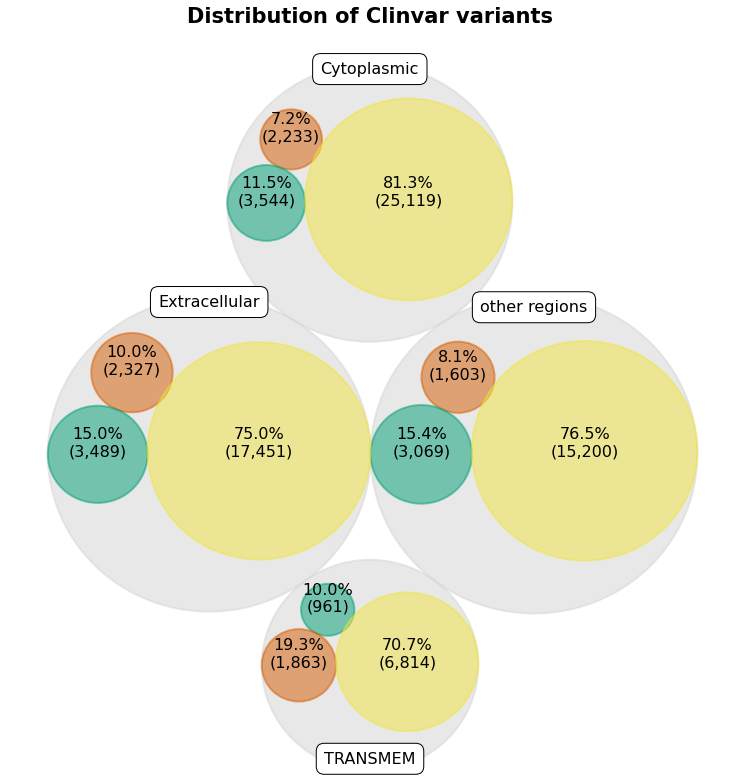

In [28]:

clinvar_TM = int((table_anno_df.loc[(table_anno_df['status']=='benign')]['Transmembrane'])) + int((table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Transmembrane'])) + int((table_anno_df.loc[(table_anno_df['status']=='VUS')]['Transmembrane']))
clinvar_EC = int((table_anno_df.loc[(table_anno_df['status']=='benign')]['Extracellular'])) + int((table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Extracellular'])) + int((table_anno_df.loc[(table_anno_df['status']=='VUS')]['Extracellular']))
clinvar_IC = int((table_anno_df.loc[(table_anno_df['status']=='benign')]['Cytoplasmic'])) + int((table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Cytoplasmic'])) + int((table_anno_df.loc[(table_anno_df['status']=='VUS')]['Cytoplasmic']))
clinvar_other = int((table_anno_df.loc[(table_anno_df['status']=='benign')]['other'])) + int((table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['other'])) + int((table_anno_df.loc[(table_anno_df['status']=='VUS')]['other']))

data = [{'id': 'all', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='total')]['all']), 'children':[
	{'id': 'TRANSMEM', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='total')]['Transmembrane']), 'children':[
		{'id': 'VUS', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Transmembrane']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Transmembrane']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Transmembrane']))/(clinvar_TM)):.1%}"},
		{'id': 'benign', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Transmembrane']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Transmembrane']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Transmembrane']))/(clinvar_TM)):.1%}"},
		{'id': 'pathogenic', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Transmembrane']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Transmembrane']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Transmembrane']))/(clinvar_TM)):.1%}"},

	]},
	{'id': 'Extracellular', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='total')]['Extracellular']), 'children':[
		{'id': 'VUS', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Extracellular']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Extracellular']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Extracellular']))/(clinvar_EC)):.1%}"},
		{'id': 'benign', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Extracellular']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Extracellular']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Extracellular']))/(clinvar_EC)):.1%}"},
		{'id': 'pathogenic', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Extracellular']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Extracellular']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Extracellular']))/(clinvar_EC)):.1%}"},
	]},
	{'id': 'Cytoplasmic', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='total')]['Cytoplasmic']), 'children':[
		{'id': 'VUS', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Cytoplasmic']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Cytoplasmic']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Cytoplasmic']))/(clinvar_IC)):.1%}"},
		{'id': 'benign', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Cytoplasmic']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Cytoplasmic']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='benign')]['Cytoplasmic']))/(clinvar_IC)):.1%}"},
		{'id': 'pathogenic', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Cytoplasmic']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Cytoplasmic']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Cytoplasmic']))/(clinvar_IC)):.1%}"},
	]},
	{'id': 'other regions', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='total')]['other']), 'children':[
		{'id': 'VUS', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['other']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['other']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['other']))/(clinvar_other)):.1%}"},
		{'id': 'benign', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='benign')]['other']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='benign')]['other']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='benign')]['other']))/(clinvar_other)):.1%}"},
		{'id': 'pathogenic', 'datum': int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['other']), 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['other']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['other']))/(clinvar_other)):.1%}"},
	]}
]},]


# Compute circle positions thanks to the circlify() function
circles = circlify.circlify(
    data, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=5)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(13,13))

# Title
ax.set_title('Distribution of Clinvar variants', fontsize=21, fontweight="bold", y=1.05)

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Print circle the highest level (continents):
for circle in circles:
    if circle.level != 2:
        continue
    x, y, r = circle
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="lightgray"))

# Print circle and labels for the highest level:
for circle in circles:
    if circle.level != 3:
          continue
    x, y, r = circle
    def get_percent(x):
        for child in data[0]['children']:
            if child['id']==x:
                return child['percent']
    #label = f'{circle.ex["id"]}\n({circle.ex["datum"]}; {circle.ex["percent"]})'#circle.ex["id"]
    label = f'{circle.ex["percent"]}\n({circle.ex["dat2"]})'#circle.ex["id"]
    if circle.ex["id"]=='benign':
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#009E74")) #91bfdb
    elif circle.ex["id"]=='pathogenic':
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#D55C00")) #fc8d59
    elif circle.ex["id"]=='VUS':
        ax.add_patch( plt.Circle((x, y+0.05), r, alpha=0.5, linewidth=2, color="#F0E442")) #ffffbf
    else:
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#69b3a2")) #fc8d59 #ffffbf #91bfdb #69b3a2
    plt.annotate(label, (x,y-0.025 ), ha='center', color="black", fontsize=16,)

# Print labels for the continents
for circle in circles:
    if circle.level != 2:
          continue
    x, y, r = circle
    print(x,y,r, circle.ex["id"])
    label = f'{circle.ex["id"]}'#\n({circle.ex["datum"]})'
    if circle.ex["id"] == 'TRANSMEM':
        plt.annotate(label, (x,y-(r-0.17) ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5), fontsize=16,)
    if circle.ex["id"] == 'Cytoplasmic':
        plt.annotate(label, (x,y+(r-0.07) ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5), fontsize=16,)
    if circle.ex["id"] == 'Extracellular':
        plt.annotate(label, (x,y+(r-0.07) ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5), fontsize=16,)
#    if circle.ex["id"] == 'Lumenal':
#        plt.annotate(label, (x-(r-0.17),y+(r-0.07) ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5), fontsize=16,)
    if circle.ex["id"] == 'other regions':
        plt.annotate(label, (x,y+(r-0.17) ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5), fontsize=16,)



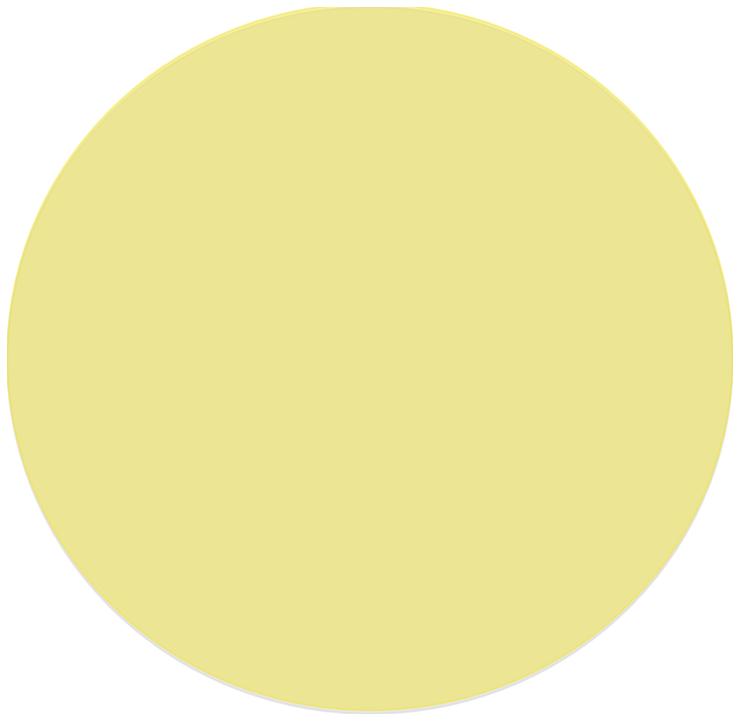

In [106]:
data = [{'id': 'all', 'datum': int(len(anno['variant'])), 'children':[
    {'id': 'TRANSMEM', 'datum': 3, 'children':[
        {'id': 'VUS', 'datum': 3, 'dat2': f"{int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Transmembrane']):,d}", 'percent': f"{((int(table_anno_df.loc[(table_anno_df['status']=='VUS')]['Transmembrane']))/(clinvar_TM)):.1%}"},

    ]},
]},]

# Compute circle positions thanks to the circlify() function
circles = circlify.circlify(
    data, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=5)
)


# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(13,13))

# Title
#ax.set_title('Distribution of Clinvar variants', fontsize=21, fontweight="bold", y=1.05)

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Print circle the highest level (continents):
for circle in circles:
    if circle.level != 2:
        continue
    x, y, r = circle
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="lightgray"))

# Print circle and labels for the highest level:
for circle in circles:
    if circle.level != 3:
          continue
    x, y, r = circle
    def get_percent(x):
        for child in data[0]['children']:
            if child['id']==x:
                return child['percent']
    #label = f'{circle.ex["id"]}\n({circle.ex["datum"]}; {circle.ex["percent"]})'#circle.ex["id"]
    label = f'{circle.ex["percent"]}\n({circle.ex["dat2"]})'#circle.ex["id"]
    if circle.ex["id"]=='benign':
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#009E74")) #91bfdb
    elif circle.ex["id"]=='pathogenic':
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#D55C00")) #fc8d59
    elif circle.ex["id"]=='VUS':
        ax.add_patch( plt.Circle((x, y+0.05), r, alpha=0.5, linewidth=2, color="#F0E442")) #ffffbf
    else:
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#69b3a2")) #fc8d59 #ffffbf #91bfdb #69b3a2
  #  plt.annotate(label, (x,y-0.025 ), ha='center', color="black", fontsize=16,)


# Print labels for the continents
for circle in circles:
    if circle.level != 2:
          continue
    x, y, r = circle

    
plt.savefig(os.path.join(plots_dir,'Fig1Cy.svg'))
plt.show()

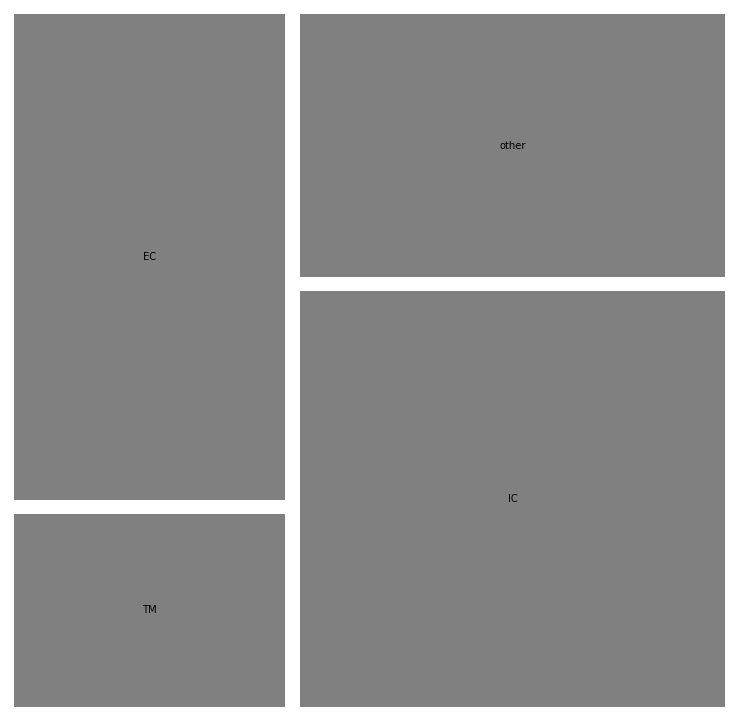

In [30]:
sizes=[clinvar_TM,clinvar_EC,clinvar_IC,clinvar_other]
label = ['TM','EC','IC','other']
fig, ax = plt.subplots(figsize=(13,13))
squarify.plot(sizes, label=label, pad=True, color='grey')
plt.axis('off')
plt.show()

INFO:TM


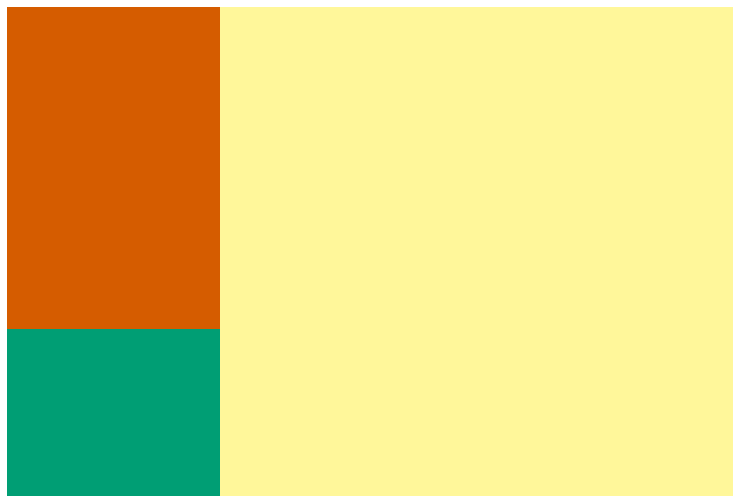

In [34]:
sizes=[int((table_anno_df.loc[(table_anno_df['status']=='benign')]['Transmembrane'])),
       int((table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Transmembrane'])),
       int((table_anno_df.loc[(table_anno_df['status']=='VUS')]['Transmembrane']))]
figsizes=(13,9)
logger.info('TM')
sizes=[int((table_anno_df.loc[(table_anno_df['status']=='benign')]['Extracellular'])),
       int((table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Extracellular'])),
       int((table_anno_df.loc[(table_anno_df['status']=='VUS')]['Extracellular']))]
figsizes=(6.8,13)
logger.info('EC')
sizes=[int((table_anno_df.loc[(table_anno_df['status']=='benign')]['Cytoplasmic'])),
       int((table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['Cytoplasmic'])),
       int((table_anno_df.loc[(table_anno_df['status']=='VUS')]['Cytoplasmic']))]
figsizes=(13,13)
logger.info('IC')
sizes=[int((table_anno_df.loc[(table_anno_df['status']=='benign')]['other'])),
       int((table_anno_df.loc[(table_anno_df['status']=='pathogenic')]['other'])),
       int((table_anno_df.loc[(table_anno_df['status']=='VUS')]['other']))]
figsizes=(13,8.2)
logger.info('other')

label = ['benign','pathogenic','VUS']
fig, ax = plt.subplots(figsize=figsizes)
#squarify.plot(sizes, color=["#009E74","#D55C00", "#F0E442"], )#label=label, pad=True, 
squarify.plot(sizes, color=["#009E74","#D55C00", "#fff79a"], )#label=label, pad=True, 
plt.axis('off')
plt.show()

### additional: variant count dist 

In [11]:
%%time
#logger.info(list(base_analysis_formated.columns))

base_analysis_formated[['variant','aa_ref','resi','aa_var']]
sub_ana_var = base_analysis_formated.copy()
sub_ana_var['ref'] = sub_ana_var['variant'].apply(lambda x: x[0])
sub_ana_var['var'] = sub_ana_var['variant'].apply(lambda x: x[-1])
ana_var_df = []
for region in ['all', 'TRANSMEM', 'Extracellular', 'Cytoplasmic', 'other']:
    tmpi = sub_ana_var.copy()
    if region != 'all':
        if region != 'other':
            tmpi = tmpi.loc[(tmpi['uniprot;regions_all']==region)].reset_index(drop=True)
        else:
            tmpi = tmpi.loc[(~tmpi['uniprot;regions_all'].isin(['TRANSMEM', 'Extracellular', 'Cytoplasmic']))].reset_index(drop=True)
    for clinvar in ['all', 'VUS', 'benign', 'pathogenic', 'other']:
        tmpi2 = tmpi.copy()
        tmpi2 = tmpi2.dropna(how='all', subset=['clinvar;significance_all']).reset_index(drop=True)
        if clinvar !='all':
            if clinvar !='other':
                tmpi2 = tmpi2.loc[(tmpi2['clinvar;significance_all']==clinvar)].reset_index(drop=True)
            else:
                tmpi2 = tmpi2.loc[(~tmpi2['clinvar;significance_all'].isin(['VUS', 'benign', 'pathogenic',]))].reset_index(drop=True)
        for ref in ['ref', 'var']:
            tmpi3 = tmpi2.copy()
            tmpi3 = tmpi3.groupby([ref]).size()
            tmpi3 = pd.DataFrame(tmpi3).reset_index(drop=False)
            tmpi3 = tmpi3.rename(columns={0: 'count', ref: 'AA'})
            tmpi3['region']= region
            tmpi3['clinvar'] = clinvar
            tmpi3['direction'] = ref
            ana_var_df.append(tmpi3)

ana_var_df = pd.concat(ana_var_df)
ana_var_df

CPU times: user 1min 32s, sys: 48.9 s, total: 2min 21s
Wall time: 2min 21s


,AA,count,region,clinvar,direction
0,A,1931,all,all,ref
1,C,729,all,all,ref
2,D,1398,all,all,ref
3,E,1247,all,all,ref
4,F,612,all,all,ref
...,...,...,...,...,...
15,S,21,other,other,var
16,T,18,other,other,var
17,V,21,other,other,var
18,W,9,other,other,var


INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:all - all


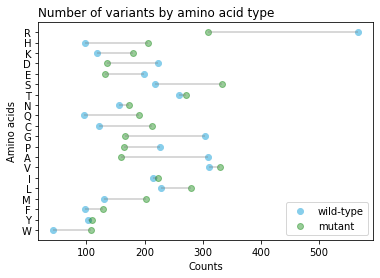

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:all - VUS


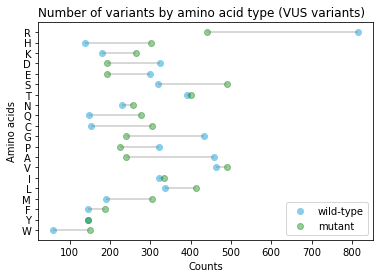

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:all - benign


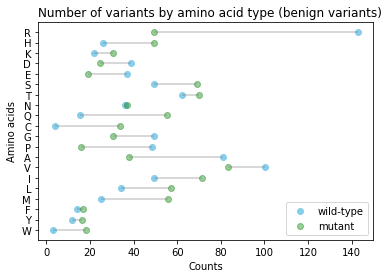

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:all - pathogenic


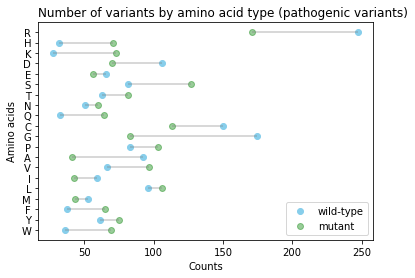

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:TRANSMEM - all


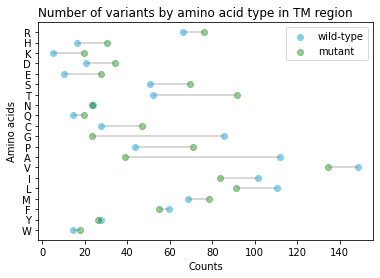

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:TRANSMEM - VUS


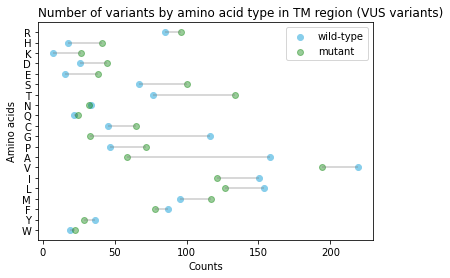

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'Q' 'R' 'S' 'T' 'V' 'W'
 'Y']
INFO:TRANSMEM - benign


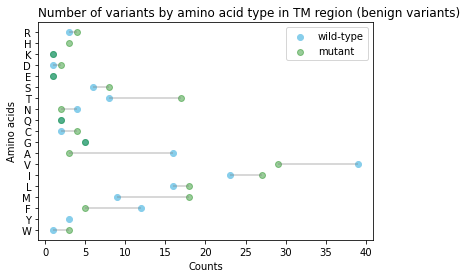

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:TRANSMEM - pathogenic


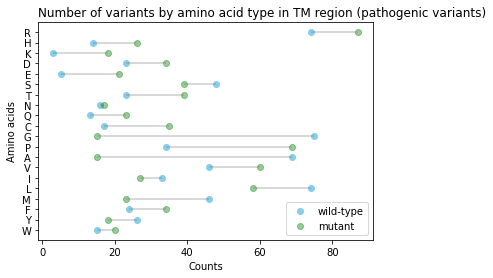

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Extracellular - all


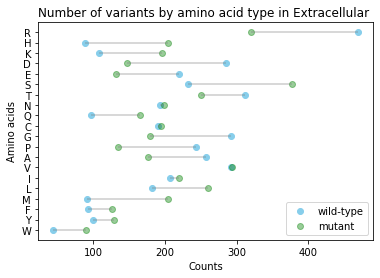

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Extracellular - VUS


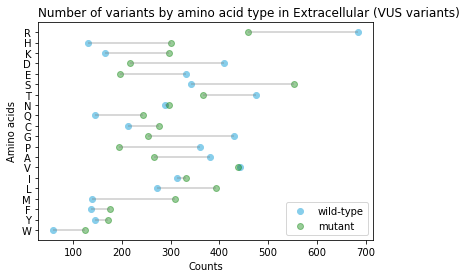

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Extracellular - benign


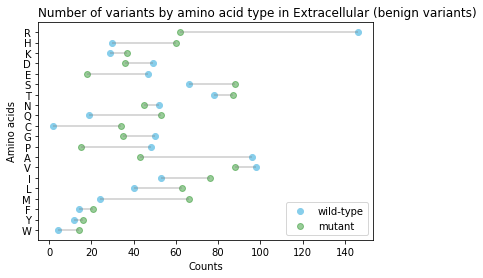

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Extracellular - pathogenic


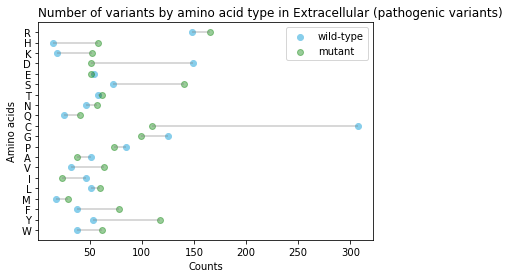

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Cytoplasmic - all


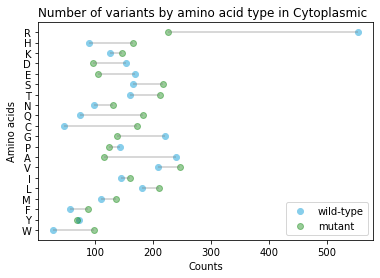

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Cytoplasmic - VUS


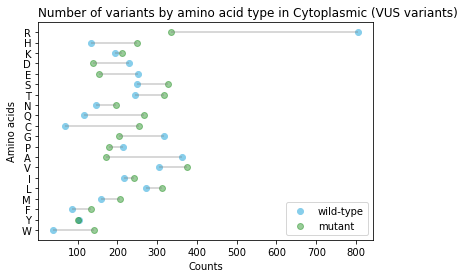

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Cytoplasmic - benign


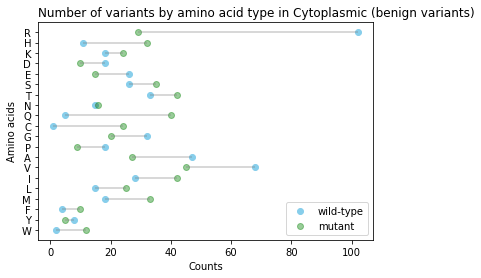

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Cytoplasmic - pathogenic


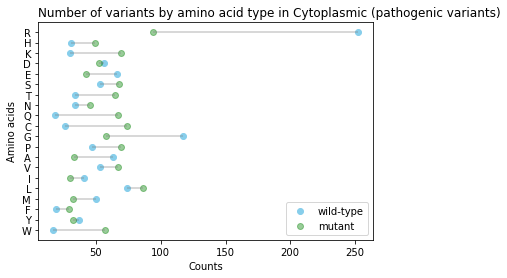

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:other - all


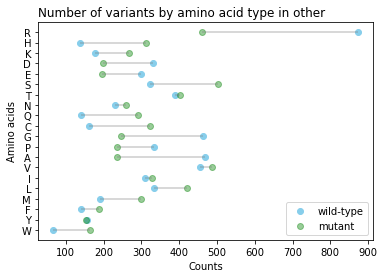

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:other - VUS


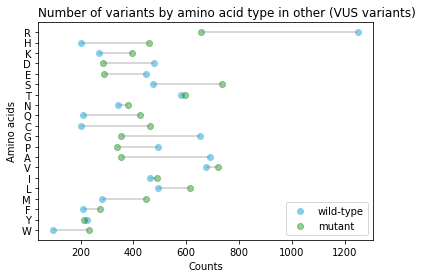

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:other - benign


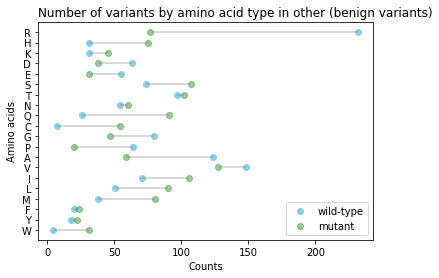

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:other - pathogenic


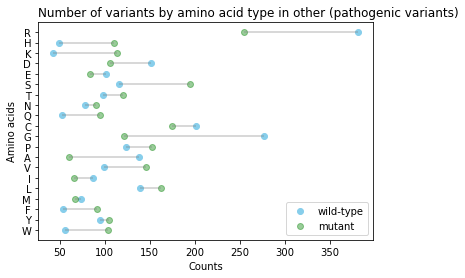

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:not TM - all


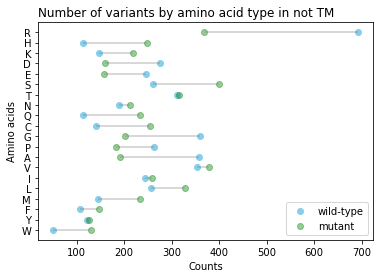

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:not TM - VUS


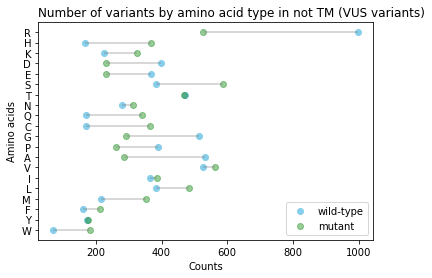

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:not TM - benign


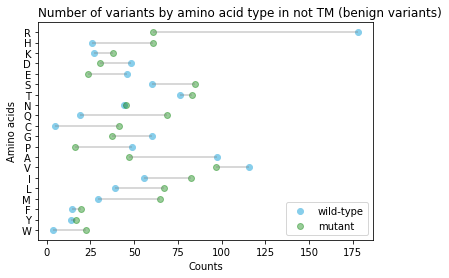

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:not TM - pathogenic


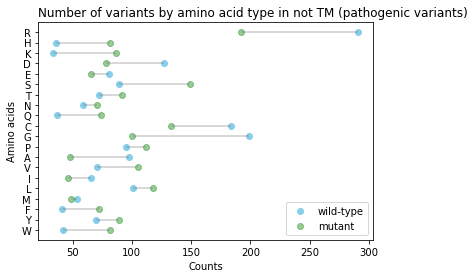

In [12]:
for region in ['all', 'TRANSMEM', 'Extracellular', 'Cytoplasmic', 'other', 'not TM']:
    tmpi_ana_var = ana_var_df.copy()
    if region != 'all':
        if region == 'other':
            tmpi_ana_var = tmpi_ana_var.loc[(~tmpi_ana_var['region'].isin(['TRANSMEM', 'Extracellular', 'Cytoplasmic']))].reset_index(drop=True)
        elif region == 'not TM':
            tmpi_ana_var = tmpi_ana_var.loc[~(tmpi_ana_var['region']=='TRANSMEM')].reset_index(drop=True)
        else:
            tmpi_ana_var = tmpi_ana_var.loc[(tmpi_ana_var['region']==region)].reset_index(drop=True)
        
    for clinvar in ['all', 'VUS', 'benign', 'pathogenic']:
        tmpi2 = tmpi_ana_var.copy()
        tmpi2 = tmpi2.dropna(how='all', subset=['clinvar']).reset_index(drop=True)
        if clinvar !='all':
            if clinvar !='VUS':
                tmpi2 = tmpi2.loc[(tmpi2['clinvar']==clinvar)].reset_index(drop=True)
            else:
                tmpi2 = tmpi2.loc[(~tmpi2['clinvar'].isin(['benign', 'pathogenic',]))].reset_index(drop=True)
        
        
        tmpi2 = pd.pivot_table(tmpi2, values='count', index='AA', columns='direction').reset_index(drop=False)
        sorter = ['R','H','K','D','E','S','T','N','Q','C','G','P','A','V','I','L','M','F','Y','W']
        sorter.reverse()
        logger.info(tmpi2['AA'].unique())
        tmpi2['AA'] = tmpi2['AA'].astype("category")
        tmpi2['AA'].cat.set_categories(sorter, inplace=True)
        tmpi2 = tmpi2.sort_values(["AA"]) 
        my_range=range(1,len(tmpi2.index)+1) 
        # The horizontal plot is made using the hline function
        #fig, ax = plt.subplots(figsize=(7,6))
        plt.hlines(y=my_range, xmin=tmpi2['ref'], xmax=tmpi2['var'], color='grey', alpha=0.4)
        plt.scatter(tmpi2['ref'], my_range, color='skyblue', alpha=1, label='wild-type')
        plt.scatter(tmpi2['var'], my_range, color='green', alpha=0.4 , label='mutant')
        plt.legend()
        # Add title and axis names
        plt.yticks(my_range, tmpi2['AA'])
        logger.info(f'{region} - {clinvar}')
        if region != 'all':
            if region == 'TRANSMEM':
                reg = 'TM region'
            else:
                reg = region
            title_str = f"Number of variants by amino acid type in {reg}"
        else:
            title_str = "Number of variants by amino acid type"
        if clinvar !='all':
            title_str = f"{title_str} ({clinvar} variants)"
        plt.title(title_str, loc='left')
        plt.xlabel('Counts')
        plt.ylabel('Amino acids')
        # Show the graph
        plt.show()


INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:all - pathogenic


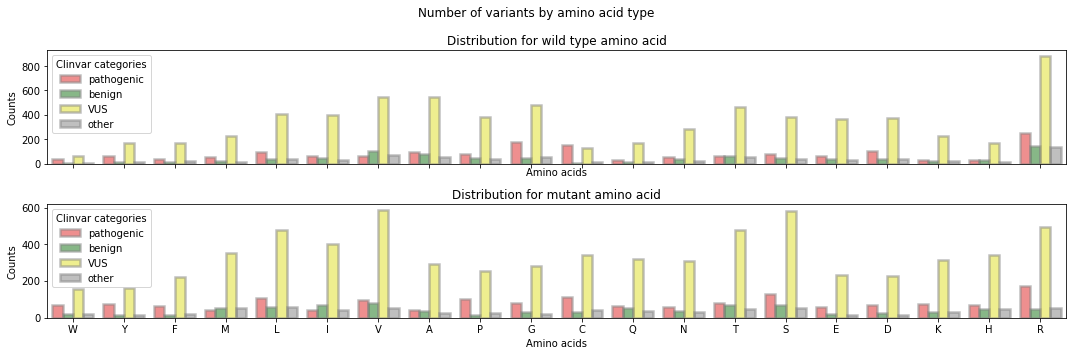

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:TRANSMEM - pathogenic


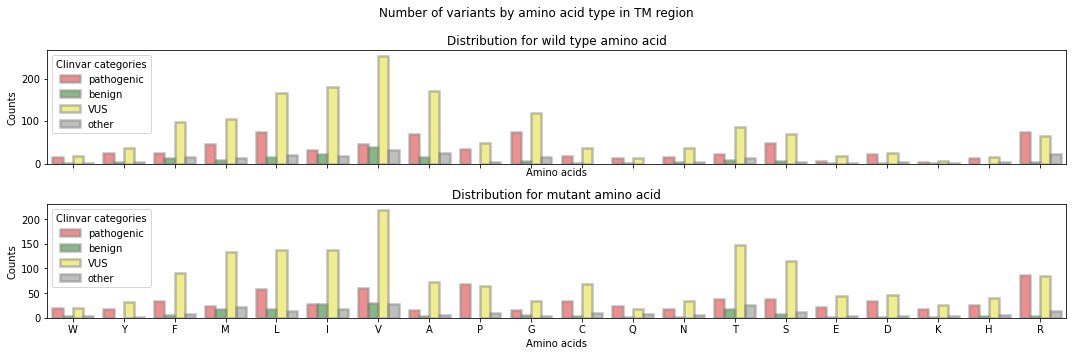

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Extracellular - pathogenic


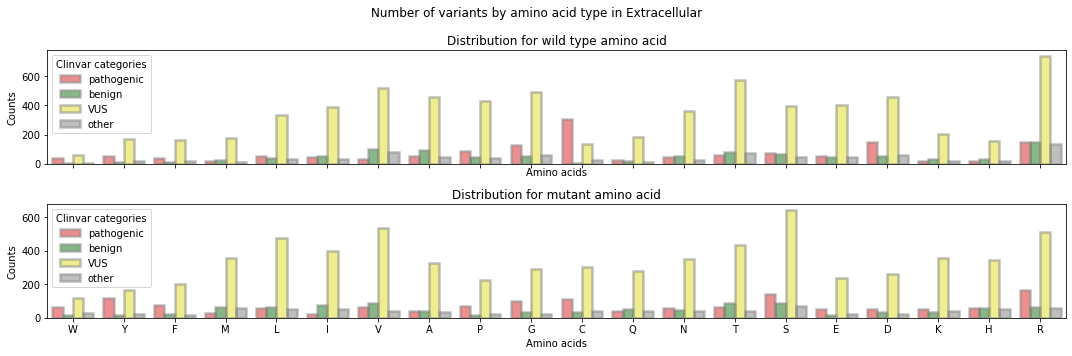

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:Cytoplasmic - pathogenic


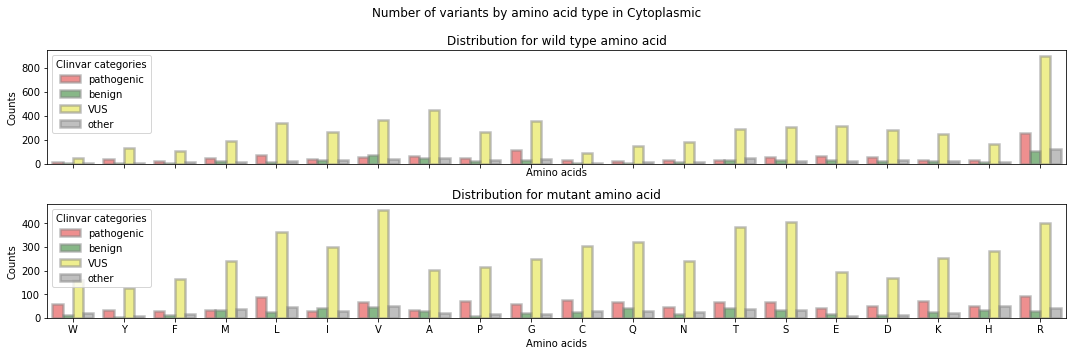

INFO:['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
INFO:other - pathogenic


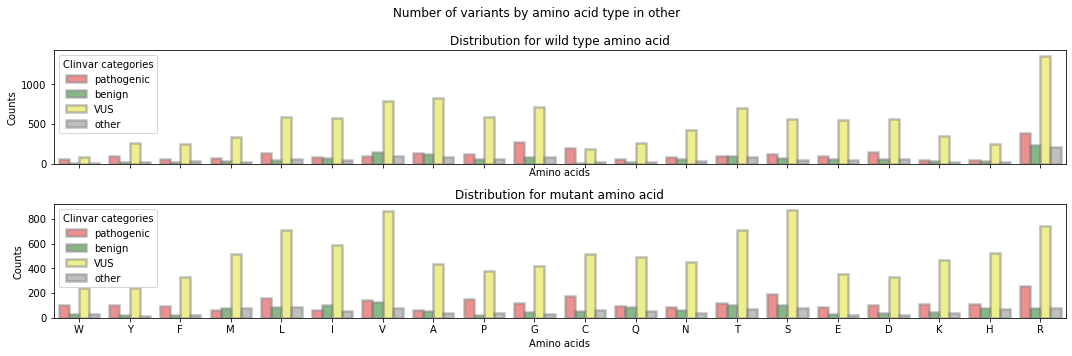

In [13]:
for region in ['all', 'TRANSMEM', 'Extracellular', 'Cytoplasmic', 'other']:
    tmpi_ana_var = ana_var_df.copy()
    tmpi_ana_var = tmpi_ana_var.loc[tmpi_ana_var['clinvar']!='all']
    if region != 'all':
        if region != 'other':
            tmpi_ana_var = tmpi_ana_var.loc[(tmpi_ana_var['region']==region)].reset_index(drop=True)
        else:
            tmpi_ana_var = tmpi_ana_var.loc[(~tmpi_ana_var['region'].isin(['TRANSMEM', 'Extracellular', 'Cytoplasmic']))].reset_index(drop=True)
    tmpi2 = tmpi_ana_var.copy()
   # tmpi2 = tmpi2.loc[tmpi2['direction']==direction].reset_index(drop=True)
    tmpi2 = tmpi2.dropna(how='all', subset=['clinvar']).reset_index(drop=True)

    tmpi2 = pd.pivot_table(tmpi2, values='count', index=['AA', 'clinvar'], columns=['direction',]).reset_index(drop=False)
    tmpi2 = tmpi2.rename(columns={'clinvar': 'Clinvar categories'})
    sorter = ['R','H','K','D','E','S','T','N','Q','C','G','P','A','V','I','L','M','F','Y','W']
    sorter.reverse()
    logger.info(tmpi2['AA'].unique())
    tmpi2['AA'] = tmpi2['AA'].astype("category")
    tmpi2['AA'].cat.set_categories(sorter, inplace=True)
    tmpi2 = tmpi2.sort_values(["AA"]) 
    my_range=range(1,21)#len(tmpi2.index)+1) 
    # The horizontal plot is made using the hline function
    #fig, ax = plt.subplots(figsize=(15,6))
    fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
    colors = ['red', 'green', 'yellow', 'grey']
#    plt.hlines(y=my_range, xmin=tmpi2['ref'], xmax=tmpi2['var'], color='grey', alpha=0.4)
    sns.barplot(ax=axes[0], y='ref', x='AA',  palette=colors,#'skyblue', 
                alpha=0.5, hue='Clinvar categories', data = tmpi2, hue_order=['pathogenic', 'benign', 'VUS', 'other'],
                 linewidth=2.5,edgecolor="grey"
               )
    sns.barplot(ax=axes[1], y='var', x='AA',  palette=colors,#'skyblue', 
                    alpha=0.5, hue='Clinvar categories', data = tmpi2, hue_order=['pathogenic', 'benign', 'VUS', 'other'],
                     linewidth=2.5,edgecolor="grey")
   # sns.pointplot(y='var', x='AA', color='green', alpha=0.4 , label='mutant', hue='clinvar', data= tmpi2, legend=False, join=False)
   # plt.legend()
    # Add title and axis names
 #   plt.yticks(my_range, tmpi2['AA'])
    logger.info(f'{region} - {clinvar}')
    if region != 'all':
        if region == 'TRANSMEM':
            reg = 'TM region'
        else:
            reg = region
        title_str = f"Number of variants by amino acid type in {reg}"
    else:
        title_str = "Number of variants by amino acid type"
    fig.suptitle(title_str, )
    axes[0].set_xlabel('Amino acids')
    axes[1].set_xlabel('Amino acids')
    axes[0].set_ylabel('Counts')
    axes[1].set_ylabel('Counts')
    axes[0].set_title("Distribution for wild type amino acid")
    axes[1].set_title("Distribution for mutant amino acid")
    # Show the graph
    fig.tight_layout()
    plt.show()


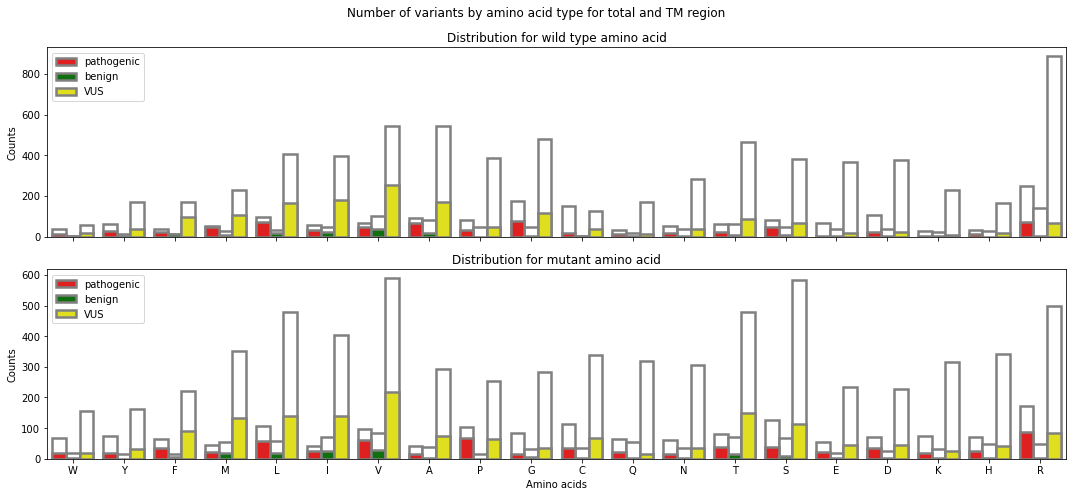

In [14]:
max_val = False

tmpi_ana_var = ana_var_df.copy()
if max_val:
    tmpi_ana_var.loc[(tmpi_ana_var['count']> 100), 'count'] = 100

tmpi_ana_var = tmpi_ana_var.loc[tmpi_ana_var['clinvar']!='all']
tmpi_ana_var2 = tmpi_ana_var.copy()
tmpi_ana_var2 = tmpi_ana_var2.loc[(tmpi_ana_var2['region']=='TRANSMEM')].reset_index(drop=True)
tmpi2 = tmpi_ana_var.copy()
# tmpi2 = tmpi2.loc[tmpi2['direction']==direction].reset_index(drop=True)

tmpi2 = pd.pivot_table(tmpi2, values='count', index=['AA', 'clinvar'], columns=['direction',]).reset_index(drop=False)
tmpi2 = tmpi2.rename(columns={'clinvar': 'Clinvar categories'})
sorter = ['R','H','K','D','E','S','T','N','Q','C','G','P','A','V','I','L','M','F','Y','W']
sorter.reverse()
tmpi2['AA'] = tmpi2['AA'].astype("category")
tmpi2['AA'].cat.set_categories(sorter, inplace=True)
tmpi2 = tmpi2.sort_values(["AA"]) 


tmpi3 = pd.pivot_table(tmpi_ana_var2, values='count', index=['AA', 'clinvar'], columns=['direction',]).reset_index(drop=False)
tmpi3 = tmpi3.rename(columns={'clinvar': 'Clinvar categories'})
sorter = ['R','H','K','D','E','S','T','N','Q','C','G','P','A','V','I','L','M','F','Y','W']
sorter.reverse()
tmpi3['AA'] = tmpi3['AA'].astype("category")
tmpi3['AA'].cat.set_categories(sorter, inplace=True)
tmpi3 = tmpi3.sort_values(["AA"]) 



my_range=range(1,21)#len(tmpi2.index)+1) 
# The horizontal plot is made using the hline function
#fig, ax = plt.subplots(figsize=(15,6))
fig, axes = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
colors = ['red', 'green', 'yellow',]
#    plt.hlines(y=my_range, xmin=tmpi2['ref'], xmax=tmpi2['var'], color='grey', alpha=0.4)


#plt.legend()
g = sns.barplot(ax=axes[0], y='ref', x='AA',  #palette=colors,#'skyblue', 
            alpha=1, hue='Clinvar categories', data = tmpi2, hue_order=['pathogenic', 'benign', 'VUS'],
             linewidth=2.5,#edgecolor="black",
                 facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor="grey"
           )
sns.barplot(ax=axes[0], y='ref', x='AA',  palette=colors,#'skyblue', 
            alpha=1, hue='Clinvar categories', data = tmpi3, hue_order=['pathogenic', 'benign', 'VUS'],
             linewidth=2.5,edgecolor="grey"
           )




h,l = g.get_legend_handles_labels()
axes[0].legend(h[3:],l[3:],bbox_to_anchor=(0.005, 0.97), loc=2, borderaxespad=0.)
g2 = sns.barplot(ax=axes[1], y='var', x='AA',  #palette=colors,#'skyblue', 
            alpha=1, hue='Clinvar categories', data = tmpi2, hue_order=['pathogenic', 'benign', 'VUS'],
             linewidth=2.5,#edgecolor="black",
                 facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor="grey", 
           )
sns.barplot(ax=axes[1], y='var', x='AA',  palette=colors,#'skyblue', 
                alpha=1, hue='Clinvar categories', data = tmpi3, hue_order=['pathogenic', 'benign', 'VUS'],
                 linewidth=2.5,edgecolor="grey"
           )

h,l = g2.get_legend_handles_labels()
axes[1].legend(h[3:],l[3:],bbox_to_anchor=(0.005, 0.97), loc=2, borderaxespad=0.)
title_str = f"Number of variants by amino acid type for total and TM region"

fig.suptitle(title_str, )
axes[0].set_xlabel('')
axes[1].set_xlabel('Amino acids')
axes[0].set_ylabel('Counts')

axes[1].set_ylabel('Counts')
axes[0].set_title("Distribution for wild type amino acid")
axes[1].set_title("Distribution for mutant amino acid")
# Show the graph
fig.tight_layout()
plt.show()


## gnomAD distribution

### gnomAD cutoff value

In [22]:
gnomad_cutoff = clinvar.copy()
gnomad_cutoff = gnomad_cutoff.dropna(how='any', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
gnomad_cutoff = gnomad_cutoff.loc[(gnomad_cutoff['clinvar;significance_all'].isin(['pathogenic', 'benign']))].reset_index(drop=True)
gnomad_cutoff = gnomad_cutoff[~gnomad_cutoff["gnomad;AF_tot_all"].isna()].reset_index(drop=True)
gnomad_cutoff['gnomad;AF_tot_first'] = gnomad_cutoff["gnomad;AF_tot_all"].apply(lambda x: float(x.split('|')[0]))
gnomad_cutoff = gnomad_cutoff[~gnomad_cutoff["gnomad;AF_tot_first"].isna()].reset_index(drop=True)

len(gnomad_cutoff['variant'])

12620

INFO:groupA: 2360
groupB: 10260
INFO:-9.931568854324432e-05


Ensemble test roc-auc:0.9555703199854626


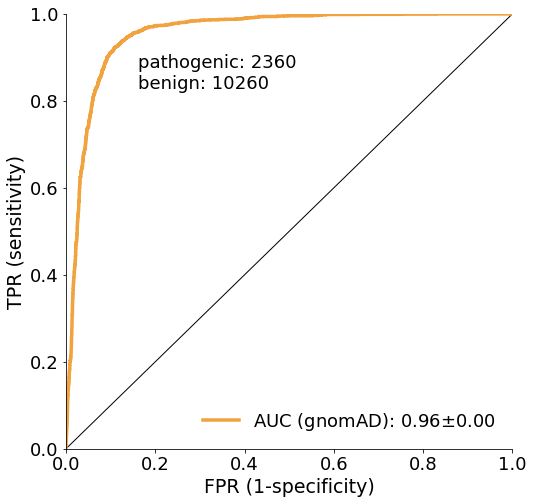

CPU times: user 1h 53min 47s, sys: 4min, total: 1h 57min 47s
Wall time: 1h 57min 49s


In [23]:
%%time

all_tmp = []
all_aucs = {}
all_vals_cat = {}



all_tmp = gnomad_cutoff.copy()
for region in ['all', ]:#'TRANSMEM', ]:#+list(all_tmp['uniprot;regions_all'].unique()):
    tmp2 = all_tmp.copy()
    if region != 'all':
        tmp2 = tmp2[(tmp2['uniprot;regions_all']==region)].reset_index(drop=True)
    #target_sub_df = target_sub_df.rename(columns={gemme_name[0]:'gemme;score', rosetta_names:'rosetta;ddG'})
    #       tmp = tmp.dropna(axis=0, how='any', subset=["rosetta;ddG", "gemme;score"]).reset_index(drop=True)

    control_df = tmp2.copy()
    control_df['label_class_raw'] = control_df[['clinvar;significance_all', 'gnomad;AF_tot_first']].apply(lambda x: '|'.join(list(set(x.dropna().astype(str)))), axis=1)
    control_df['score'] = control_df['label_class_raw'].apply(lambda x: clinvar_class_anno5(x))
    control_df['gnomad;AF_tot_first'] = control_df['gnomad;AF_tot_first']*(-1)

    control_df = control_df.dropna(subset = ['score']).reset_index(drop=True)
    control_score = np.copy(control_df['score'].values)
    if len(list(set(control_score))) > 1:
        test_score1 = control_df['gnomad;AF_tot_first'].values
        title = f"gnomAD_{region}"
        groupA = len(control_df[control_df['score']==1].reset_index(drop=True)['score'])
        groupB = len(control_df[control_df['score']==0].reset_index(drop=True)['score'])
        logger.info(f"groupA: {groupA}\ngroupB: {groupB}")
        satu = ''#, sat.;\n excl. resi with >10 ∆∆G<0'
        #try:
            #print("try")
        if region == 'all':
            #auc_dici = ROC_improve_checks(control_df)
            auc_dici = cutoff_checks(control_df, nameA='gnomad;AF_tot_first')#;ori
            all_aucs['all']=auc_dici*-1
            logger.info(auc_dici)
            auc_dici = disease_ROC_adapted(control_df, control_score, test_score1, groupA=groupA, groupB=groupB, nameA='gnomad;AF_tot_first')


### gnomAD distribution

In [24]:
%%time

all_df_sub = []
#sub_ana_var2 = gnomad.copy()#base_analysis_formated.copy()
sub_ana_var2 = analysis_df_base2.copy()
sub_ana_var2 = sub_ana_var2.dropna(how='any', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
sub_ana_var2['regions'] = 'all'
all_df_sub.append(sub_ana_var2[['gnomad;AF_tot_all', 'regions', 'clinvar;significance_all',]])

clinvar_benign = clinvar.copy()
clinvar_benign = clinvar_benign.loc[(clinvar_benign['clinvar;significance_all']=='benign')].reset_index(drop=True)
sub_ana_var2 = clinvar_benign.copy()
sub_ana_var2 = sub_ana_var2[~sub_ana_var2["gnomad;AF_tot_all"].isna()].reset_index(drop=True)
sub_ana_var2['regions'] = 'benign'
all_df_sub.append(sub_ana_var2[['gnomad;AF_tot_all', 'regions', 'clinvar;significance_all',]])

clinvar_pathogenic = clinvar.copy()
clinvar_pathogenic = clinvar_pathogenic.loc[(clinvar_pathogenic['clinvar;significance_all']=='pathogenic')].reset_index(drop=True)
sub_ana_var2 = clinvar_pathogenic.copy()
sub_ana_var2 = sub_ana_var2[~sub_ana_var2["gnomad;AF_tot_all"].isna()].reset_index(drop=True)
sub_ana_var2['regions'] = 'pathogenic'
all_df_sub.append(sub_ana_var2[['gnomad;AF_tot_all', 'regions', 'clinvar;significance_all',]])

sub_ana_var2 = anno.copy()
TM_range = ['TRANSMEM', 'Mitochondrial_intermembrane', 'INTRAMEM', 'INTRAMEM|TRANSMEM']
sub_ana_var2 = sub_ana_var2[~sub_ana_var2["gnomad;AF_tot_all"].isna()].reset_index(drop=True)
sub_ana_var2 = sub_ana_var2.loc[sub_ana_var2['uniprot;regions_all'].isin(TM_range)].reset_index(drop=True)
sub_ana_var2['regions'] = 'transmembrane'
all_df_sub.append(sub_ana_var2[['gnomad;AF_tot_all', 'regions', 'clinvar;significance_all',]])
logger.info('here')

sub_ana_var = pd.concat(all_df_sub)
sub_ana_var['gnomad;AF_tot_first'] = sub_ana_var["gnomad;AF_tot_all"].apply(lambda x: float(x.split('|')[0]))
sub_ana_var = sub_ana_var.sort_values(['regions'], ascending=[1])
sub_ana_var = sub_ana_var[['gnomad;AF_tot_first', 'regions', 'clinvar;significance_all',]]

sub_ana_var['gnomad_log'] = np.log10(sub_ana_var['gnomad;AF_tot_first'])
sub_ana_var.replace([np.inf, -np.inf], np.nan, inplace=True)
sub_ana_var = sub_ana_var.dropna(subset=['gnomad;AF_tot_first', 'gnomad_log'])

sorter = ['all', 'transmembrane', 'benign', 'pathogenic']
sub_ana_var['regions'] = sub_ana_var['regions'].astype("category")
sub_ana_var['regions'].cat.set_categories(sorter, inplace=True)
sub_ana_var = sub_ana_var.sort_values(["regions"])


INFO:here


CPU times: user 3min 25s, sys: 2min 47s, total: 6min 13s
Wall time: 6min 12s


INFO:['benign', 'pathogenic']
Categories (2, object): ['benign', 'pathogenic']


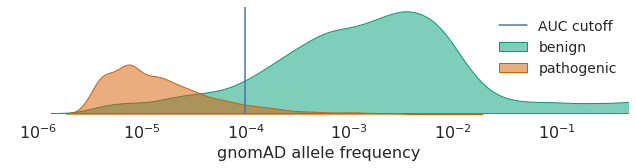

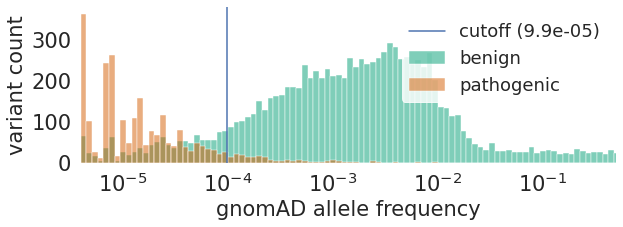

INFO:all


CPU times: user 9.13 s, sys: 6.52 s, total: 15.7 s
Wall time: 8.2 s


In [25]:
%%time

gnomad_cutoff_value = 9.931568854324432e-05

tmps = sub_ana_var.copy()
tmps = tmps.loc[tmps['regions'].isin(['benign', 'pathogenic'])].reset_index(drop=True)
logger.info(tmps['regions'].unique())
f = plt.figure(figsize=(9,2.5))
with sns.axes_style("white"):#white, dark, whitegrid, darkgrid, ticks
    sns.set_theme(style="white", rc={"axes.facecolor": (1, 1, 1, 1), 'axes.linewidth':0})
    g = sns.kdeplot( x=tmps['gnomad;AF_tot_first'], fill=True, alpha=0.5, log_scale=10, hue=tmps['regions'], 
                hue_order=['pathogenic', 'benign', ], palette=sns.color_palette(['#D55C00', '#009E74', ]),
               )
    g.set_xlim(5e-7, 5e-1)
    g.set_xlabel('gnomAD allele frequency')
    g.set_ylabel('')
    sns.set(font_scale=1.0)
    g.set(yticks=[], xlabel="gnomAD allele frequency", )
    #g.despine(left=True)
    g.yaxis.label.set_size(16)
    g.xaxis.label.set_size(16)
    for tick in g.xaxis.get_minor_ticks(): 
        tick.label.set_fontsize(16)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=12)
    g.axvline(gnomad_cutoff_value)#7.097735196763732e-05)

    #sns.set_context("talk", font_scale=5.5)
    #plt.axvline(x=0)
    plt.legend(title='', labels=['AUC cutoff', 'benign', 'pathogenic'], fontsize=14, fancybox=True, facecolor='white', edgecolor='white')#loc='upper left', )
    plt.tight_layout()
    plt.show()
f = plt.figure(figsize=(9,3.5))
fontsize = 21
with sns.axes_style("white"):#white, dark, whitegrid, darkgrid, ticks
    sns.set_theme(style="white", rc={"axes.facecolor": (1, 1, 1, 1), 'axes.linewidth':0})
    g = sns.histplot(data=tmps, x='gnomad;AF_tot_first', log_scale=10, hue='regions', bins=100,
                 palette=sns.color_palette(['#D55C00', '#009E74', ]), hue_order=['pathogenic','benign', ], )
    g.set_xlim(4e-6, 5e-1)
    g.set_xlabel('gnomAD allele frequency')
    g.set_ylabel('variant count')
    sns.set(font_scale=1.5)
    #g.set(yticks=[], xlabel="gnomAD allele frequency", )
    #g.despine(left=True)
    g.yaxis.label.set_size(fontsize)
    g.xaxis.label.set_size(fontsize)
    for tick in g.xaxis.get_minor_ticks(): 
        tick.label.set_fontsize(fontsize)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    g.axvline(gnomad_cutoff_value)#7.097735196763732e-05)
    
    #sns.set_context("talk", font_scale=5.5)
    #plt.axvline(x=0)
    plt.legend(title='', labels=['cutoff (9.9e-05)', 'benign', 'pathogenic'], fontsize=fontsize-3, fancybox=True, facecolor='white', edgecolor='white')#loc='upper left', )
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir,'Fig1B.svg'))
    plt.show()    


logger.info(region)

## info-table

### general table

In [41]:
%%time
csv_file_count_Clinvar_gnomad_PDB = os.path.join(tables_dir, f'{timeflag}-count_hMP_Clinvar_gnomad_PDB_nonsyndel_df2.csv')

if os.path.isfile(csv_file_count_Clinvar_gnomad_PDB):
    logger.info('Read dataframe from existing files...')
    counts_df = pd.read_csv(csv_file_count_Clinvar_gnomad_PDB, header=[0,1])
else:
    logger.info('No existing files. Generate new files')
    analysis_df = base_analysis_formated.copy()

    analysis_df = analysis_df[['variant','accession', 'pdb;IDs', 'pdb;SS_all', 'clinvar;significance_all', 'uniprot;regions_all', 'gnomad;AF_tot_all']]

    tmp_ana_df = analysis_df.copy()
    counts = [['accession', 'accession','accession', 
                'length', 'length',
                'assembly', 'assembly', 'assembly', 'PDB',
                'all', 'all', 'all', 'all', 'all', 'all', 'all',
                'TRANSMEM', 'TRANSMEM', 'TRANSMEM',  'TRANSMEM', 'TRANSMEM', 'TRANSMEM', 'TRANSMEM',
                'Extracellular', 'Extracellular', 'Extracellular', 'Extracellular', 'Extracellular', 'Extracellular', 'Extracellular',
                'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic',
                'other', 'other', 'other', 'other', 'other', 'other', 'other',
                'MIM', 'MIM',
              ],
                ['ID', 'name', 'class',
                'all', 'TM',  
                'self', 'others', 'note', 'PDBids', 
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_total', 'gnomad_unique',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_total', 'gnomad_unique',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_total', 'gnomad_unique',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_total', 'gnomad_unique',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_total', 'gnomad_unique',
                'Chromosome', 'Phenotype',
              ]]
    #VUS, benign, pathogenic, other=['conflict', 'other', 'conflict|benign', 'VUS|benign', 'VUS|pathogenic', 'VUS|conflict']
    #Extracellular Cytoplasmic TRANSMEM other=['Lumenal', 'Nuclear', 'Perinuclear_space', 'Lumenal,_melanosome', 'Mitochondrial_matrix', 'Mitochondrial_itermembrane', 'INTRAMEM', 'Vacuolar', 'Vesicular', 'Intragranular', 'Peroxisomal']


    logger.info(len(tmp_ana_df['accession'].unique()))
    for index, accession in enumerate(tmp_ana_df['accession'].unique()):
        if index%100 == 0:
            logger.info(index)
        try:
            name = list(hMP_merged_dfs[hMP_merged_dfs['accession']==accession]['entryName'])[0].split('_')[0]
        except:
            name = ''

        tmp = tmp_ana_df.copy()
        tmp = tmp[tmp['accession']==accession].reset_index(drop=True)
        
        counts_dic={
            'all':0, 'TRANSMEM':0, 'Extracellular':0, 'Cytoplasmic':0, 'other':0,
        }
        tmpa = tmp.copy()
        counts_dic[f"all"]=len(tmpa['variant'])
        for region in tmp_ana_df['uniprot;regions_all'].unique():
            tmpb = tmpa.copy()
            tmpb = tmpb[tmpb['uniprot;regions_all']==region].reset_index(drop=True)
            if (region in ['Extracellular', 'Cytoplasmic', 'TRANSMEM']):
                counts_dic[f"{region}"]=len(tmpb['variant'])
            else:
                counts_dic['other']+=len(tmpb['variant'])
        
        
        clinvar_dic={
            'all_VUS':0, 'all_benign':0, 'all_pathogenic':0, 'all_other':0,
            'TRANSMEM_VUS':0, 'TRANSMEM_benign':0, 'TRANSMEM_pathogenic':0, 'TRANSMEM_other':0,
            'Extracellular_VUS':0, 'Extracellular_benign':0, 'Extracellular_pathogenic':0, 'Extracellular_other':0,
            'Cytoplasmic_VUS':0, 'Cytoplasmic_benign':0, 'Cytoplasmic_pathogenic':0, 'Cytoplasmic_other':0,
            'other_VUS':0, 'other_benign':0, 'other_pathogenic':0, 'other_other':0,
        }
        for clinvar in tmp['clinvar;significance_all'].unique():
            tmp2 = tmp.copy()
            tmp2 = tmp2.dropna(how='all', subset=['clinvar;significance_all']).reset_index(drop=True)
            tmp2 = tmp2[tmp2['clinvar;significance_all']==clinvar].reset_index(drop=True)
            if clinvar in ['VUS', 'benign', 'pathogenic']:
                clinvar_dic[f"all_{clinvar}"]=len(tmp2['variant'])
            else:
                clinvar_dic['all_other']+=len(tmp2['variant'])
            for region in tmp_ana_df['uniprot;regions_all'].unique():
                tmp3 = tmp2.copy()
                tmp3 = tmp3[tmp3['uniprot;regions_all']==region].reset_index(drop=True)
                if (region in ['Extracellular', 'Cytoplasmic', 'TRANSMEM']) and (clinvar in ['VUS', 'benign', 'pathogenic']):
                    clinvar_dic[f"{region}_{clinvar}"]=len(tmp3['variant'])
                elif (region in ['Extracellular', 'Cytoplasmic', 'TRANSMEM']):
                    clinvar_dic[f"{region}_other"]+=len(tmp3['variant'])
                elif (clinvar in ['VUS', 'benign', 'pathogenic']):
                    clinvar_dic[f"other_{clinvar}"]+=len(tmp3['variant'])
                else:
                    clinvar_dic['other_other']+=len(tmp3['variant'])

        gnomad_dic={
            'all':0, 'TRANSMEM':0, 'Extracellular':0, 'Cytoplasmic':0, 'other':0,
            'all_unique':0, 'TRANSMEM_unique':0, 'Extracellular_unique':0, 'Cytoplasmic_unique':0, 'other_unique':0,
        }
        tmp4 = tmp.copy()
        tmp4 = tmp4.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
        gnomad_dic[f"all"]=len(tmp4['variant'])
        tmp4a = tmp4.copy()
        tmp4a = tmp4a[~tmp4a['clinvar;significance_all'].notna()].reset_index(drop=True)
        gnomad_dic[f"all_unique"]=len(tmp4a['variant'])
        for region in tmp_ana_df['uniprot;regions_all'].unique():
            tmp5 = tmp4.copy()
            tmp5 = tmp5[tmp5['uniprot;regions_all']==region].reset_index(drop=True)
            tmp5a = tmp4a.copy()
            tmp5a = tmp5a[tmp5a['uniprot;regions_all']==region].reset_index(drop=True)
            if (region in ['Extracellular', 'Cytoplasmic', 'TRANSMEM']):
                gnomad_dic[f"{region}"]=len(tmp5['variant'])
                gnomad_dic[f"{region}_unique"]=len(tmp5a['variant'])
            else:
                gnomad_dic['other']+=len(tmp5['variant'])
                gnomad_dic['other_unique']+=len(tmp5a['variant'])

        uniprot_files = glob.glob(os.path.join(shared_prism_dir, accession[0:2], accession[2:4], accession[4:6], f'prism_uniprot_*_{accession}.txt'))
        uniprot = read_prism(uniprot_files[0])
        sequence = uniprot.metadata['protein']['sequence']
        length_total = int(len(sequence))
        uniprot_tmp = uniprot.dataframe.copy()
        try:
            uniprot_tmp = uniprot_tmp.dropna(how='all', subset=['TRANSMEM']).reset_index(drop=True)
            uniprot_tmp['res'] = uniprot_tmp['resi'].apply(lambda x: x[0])
            length_TM = int(len(uniprot_tmp['res'].unique()))
        except:
            length_TM = np.nan

        pdb_ids = []
        pdb_files = tmp['pdb;IDs'].unique()
        for pdb in pdb_files:
            pdb = [elem.upper() for elem in pdb.split('|')]
            pdb_ids += pdb 
        pdb_ids = "|".join(sorted(set(sorted(pdb_ids))))

        def get_MIM_info(hMP_id, genemap2_df, morbidmap_df):
            result_dict = {}
            result_dict['Chromosome'] = '|'.join(genemap2_df[genemap2_df['MIM_ID'] == uniprot2omim[hMP_id]]['Chromosome'])
            result_dict['Phenotype'] = '|'.join(genemap2_df[genemap2_df['MIM_ID'] == uniprot2omim[hMP_id]]['Phenotype'])
            return result_dict
        try:
            MIM_dict = get_MIM_info(accession, genemap2_df, morbidmap_df)
            chromosome = MIM_dict['Chromosome']
            phenotype = MIM_dict['Phenotype']
        except:
            chromosome = None
            phenotype = None

        counts.append([
            accession, name, None,
            length_total, length_TM,
            None, None, None, pdb_ids,
            counts_dic['all'], clinvar_dic['all_VUS'], clinvar_dic['all_benign'], clinvar_dic['all_pathogenic'], clinvar_dic['all_other'], gnomad_dic['all'], gnomad_dic['all_unique'],
            counts_dic['TRANSMEM'], clinvar_dic['TRANSMEM_VUS'], clinvar_dic['TRANSMEM_benign'], clinvar_dic['TRANSMEM_pathogenic'], clinvar_dic['TRANSMEM_other'], gnomad_dic['TRANSMEM'], gnomad_dic['TRANSMEM_unique'],
            counts_dic['Extracellular'], clinvar_dic['Extracellular_VUS'], clinvar_dic['Extracellular_benign'], clinvar_dic['Extracellular_pathogenic'], clinvar_dic['Extracellular_other'], gnomad_dic['Extracellular'], gnomad_dic['Extracellular_unique'],
            counts_dic['Cytoplasmic'], clinvar_dic['Cytoplasmic_VUS'], clinvar_dic['Cytoplasmic_benign'], clinvar_dic['Cytoplasmic_pathogenic'], clinvar_dic['Cytoplasmic_other'], gnomad_dic['Cytoplasmic'], gnomad_dic['Cytoplasmic_unique'],
            counts_dic['other'], clinvar_dic['other_VUS'], clinvar_dic['other_benign'], clinvar_dic['other_pathogenic'], clinvar_dic['other_other'], gnomad_dic['other'], gnomad_dic['other_unique'],
            chromosome, phenotype,
        ])
    counts_df = pd.DataFrame(data=counts[2:], columns=counts[0:2])

    counts_df.to_csv(csv_file_count_Clinvar_gnomad_PDB, index=False)
counts_df.sort_values(by=[('TRANSMEM', 'total')], ascending=[False])


INFO:No existing files. Generate new files
INFO:1504
INFO:0
INFO:100
INFO:200
INFO:300
INFO:400
INFO:500
INFO:600
INFO:700
INFO:800
INFO:900
INFO:1000
INFO:1100
INFO:1200
INFO:1300
INFO:1400
INFO:1500


CPU times: user 7min 18s, sys: 5.6 s, total: 7min 24s
Wall time: 8min 21s


accession              length        assembly               \
            ID   name class    all     TM     self others  note   
128     P35499  SCN4A  None   1836  461.0     None   None  None   
765     Q14524  SCN5A  None   2016  463.0     None   None  None   
766     Q01118  SCN7A  None   1682  462.0     None   None  None   
1348    P13569   CFTR  None   1480  253.0     None   None  None   
674     P98161   PKD1  None   4303  230.0     None   None  None   
...        ...    ...   ...    ...    ...      ...    ...   ...   
620     Q96PH1   NOX5  None    765  151.0     None   None  None   
619     O15394  NCAM2  None    837   21.0     None   None  None   
618     O43525  KCNQ3  None    872  127.0     None   None  None   
615     Q15262  PTPRK  None   1439   22.0     None   None  None   
1503    Q6P179  ERAP2  None    960   20.0     None   None  None   

                                                    PDB   all  ...  \
                                                 PDBids total  ...   
128                                6AGF-A|6MBA-A|6MC9-A   922  ...   
765   4DCK-A|4JQ0-C|4JQ0-D|4OVN-B|4OVN-D|4OVN-F|4OVN...   990  ...   
766                                       7TJ8-A|7TJ9-A   673  ...   
1348  1XMI-A|1XMI-B|1XMI-C|1XMI-D|1XMI-E|1XMJ-A|2BBO...  1404  ...   
674                                       1B4R-A|6A70-B   734  ...   
...                                                 ...   ...  ...   
620                                       6SZ5-B|6SZ5-C     2  ...   
619   2DOC-A|2JLL-A|2KBG-A|2V5T-A|2VAJ-A|2WIM-A|2WIM...   358  ...   
618                                              5J03-A    38  ...   
615                                              2C7S-A   130  ...   
1503  3SE6-A|3SE6-B|4E36-A|4E36-B|4JBS-A|4JBS-B|5AB0...   598  ...   

       Cytoplasmic other                                           \
     gnomad_unique total VUS benign pathogenic other gnomad_total   
128            230    43  10      0          1     0           40   
765            139    52  24      0          9     4           27   
766            139    66   0      1          0     0           66   
1348           456     0   0      0          0     0            0   
674            185     0   0      0          0     0            0   
...            ...   ...  ..    ...        ...   ...          ...   
620              0     0   0      0          0     0            0   
619              0     0   0      0          0     0            0   
618             26     0   0      0          0     0            0   
615            130     0   0      0          0     0            0   
1503             0   598   0      4          0     0          598   

                          MIM  \
     gnomad_unique Chromosome   
128             32      chr17   
765             15       chr3   
766             65       None   
1348             0       chr7   
674              0      chr16   
...            ...        ...   
620              0       None   
619              0       None   
618              0       chr8   
615              0       None   
1503           594       None   

                                                         
                                              Phenotype  
128   Paramyotonia congenita, 168300 (3), Autosomal ...  
765   Ventricular fibrillation, familial, 1, 603829 ...  
766                                                None  
1348  Cystic fibrosis, 219700 (3), Autosomal recessi...  
674   Polycystic kidney disease 1, 173900 (3), Autos...  
...                                                 ...  
620                                                None  
619                                                None  
618   Seizures, benign neonatal, 2, 121201 (3), Auto...  
615                                                None  
1503                                               None  

[1504 rows x 46 columns]

In [42]:
tmpi_counts_df = counts_df.copy()
tmpi_counts_df = tmpi_counts_df.loc[~((tmpi_counts_df[('TRANSMEM', 'benign')]==0) | (tmpi_counts_df[('TRANSMEM', 'pathogenic')]==0))].reset_index(drop=True)
logger.info(tmpi_counts_df[('all', 'total')].sum())
tmpi_counts_df.sort_values(by=[('TRANSMEM', 'total')], ascending=[False])


INFO:15554


accession              length        assembly               \
          ID   name class    all     TM     self others  note   
1     P35499  SCN4A  None   1836  461.0     None   None  None   
24    Q14524  SCN5A  None   2016  463.0     None   None  None   
37    Q09428  ABCC8  None   1581  361.0     None   None  None   
22    Q8IZF0  NALCN  None   1738  495.0     None   None  None   
8     O15118   NPC1  None   1278  277.0     None   None  None   
31    Q13635   PTC1  None   1447  251.0     None   None  None   
12    O75907  DGAT1  None    488  261.0     None   None  None   
15    P21439   MDR3  None   1286  259.0     None   None  None   
14    P11166   GTR1  None    492  261.0     None   None  None   
20    P82251   BAT1  None    487  252.0     None   None  None   
19    P08100   OPSD  None    348  161.0     None   None  None   
25    P32245   MC4R  None    332  165.0     None   None  None   
30    P49768   PSN1  None    467  195.0     None   None  None   
40    Q9H221  ABCG8  None    673  126.0     None   None  None   
13    Q9ULV1   FZD4  None    537  206.0     None   None  None   
7     P51787  KCNQ1  None    676  128.0     None   None  None   
26    P43007   SATT  None    532  189.0     None   None  None   
6     Q9H3H5    GPT  None    408  228.0     None   None  None   
39    Q9Y653  AGRG1  None    693  147.0     None   None  None   
34    Q9NQW8  CNGB3  None    809  126.0     None   None  None   
33    Q9H222  ABCG5  None    651  127.0     None   None  None   
9     P29033   CXB2  None    226   83.0     None   None  None   
18    Q12809  KCNH2  None   1159  126.0     None   None  None   
11    Q16281  CNGA3  None    694  126.0     None   None  None   
23    P41181   AQP2  None    271  124.0     None   None  None   
27    Q99835    SMO  None    787  147.0     None   None  None   
10    Q14028  CNGB1  None   1251  122.0     None   None  None   
29    Q9HBA0  TRPV4  None    871  147.0     None   None  None   
2     P31213   S5A2  None    254   84.0     None   None  None   
3     P43681  ACHA4  None    627   85.0     None   None  None   
0     P30518    V2R  None    371  151.0     None   None  None   
35    P16615  AT2A2  None   1042  204.0     None   None  None   
38    P33897  ABCD1  None    745  105.0     None   None  None   
16    Q8N5M9  JAGN1  None    183   84.0     None   None  None   
32    P17787  ACHB2  None    502   86.0     None   None  None   
4     P14867  GBRA1  None    456   88.0     None   None  None   
36    O75027  ABCB7  None    752  126.0     None   None  None   
5     O60741   HCN1  None    890  129.0     None   None  None   
28    Q12879  NMDE1  None   1464   62.0     None   None  None   
21    P22607  FGFR3  None    806   21.0     None   None  None   
17    P15382  KCNE1  None    129   23.0     None   None  None   

                                                  PDB   all  ...  \
                                               PDBids total  ...   
1                                6AGF-A|6MBA-A|6MC9-A   922  ...   
24  4DCK-A|4JQ0-C|4JQ0-D|4OVN-B|4OVN-D|4OVN-F|4OVN...   990  ...   
37  6C3O-E|6C3O-F|6C3O-G|6C3O-H|6C3P-E|6C3P-F|6C3P...   853  ...   
22                 6XIW-A|7CM3-A|7SX3-A|7SX4-A|7WJI-D   598  ...   
8   3GKH-A|3GKI-A|3GKJ-A|3JD8-A|5F18-A|5F1B-C|5HNS...   796  ...   
31  6DMB-A|6DMO-A|6DMY-A|6E1H-A|6E1H-B|6E1H-C|6N7G...   822  ...   
12                        6VYI-A|6VYI-B|6VZ1-A|6VZ1-B   286  ...   
15                        6S7P-A|7NIU-A|7NIV-C|7NIW-A   666  ...   
14                 4PYP-A|5EQG-A|5EQH-A|5EQI-A|6THA-A   286  ...   
20   6LI9-B|6LI9-D|6LID-B|6LID-D|6YUP-D|6YUP-E|6YV1-A   293  ...   
19          4ZWJ-A|4ZWJ-B|4ZWJ-C|4ZWJ-D|5DGY-B|6CMO-R   315  ...   
25                                      6W25-A|7AUE-R   226  ...   
30  2KR6-A|5FN2-B|5FN3-B|6IDF-B|6IYC-B|6LQG-B|6LR4...   252  ...   
40  5DO7-B|5DO7-D|7JR7-B|7R87-B|7R88-B|7R89-B|7R8A...   583  ...   
13  5BPB-A|5BPB-B|5BPB-C|5BPB-D|5BPQ-A|5BPQ-B|5BPQ...   287  ...   
7   3BJ4-A|3BJ4-B|3HFC-A|3HFC-B|3HFC-C|3HFE-A|3HFE.

In [43]:
mylist = tmpi_counts_df[('accession','ID')].unique()
calculate_struc_sele(mylist)


INFO:0 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py P30518
INFO:1 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py P35499
INFO:2 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py P31213
INFO:3 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py P43681
INFO:4 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py P14867
INFO:5 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py O60741
INFO:6 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py Q9H3H5
INFO:7 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py P51787
INFO:8 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py O15118
INFO:9 python3 /storage1/tiemann/dev/repos/PRISM/software/scripts/struc_select_sifts.py P29033
INFO:10 python3 /storage1/tiemann/dev/repos/PRISM/

### get sub-pdb table

In [44]:
new_subset = tmpi_counts_df[('accession','ID')].unique()
sele_IDs_subset = new_subset


In [45]:
%%time
xlsx_file_count_Clinvar_gnomad_PDB_single = os.path.join(tables_dir, f'{timeflag}-count_hMP_Clinvar_gnomad_splitPDB_df-Xray2.xlsx')

if os.path.isfile(xlsx_file_count_Clinvar_gnomad_PDB_single):
    logger.info('Read dataframe from existing files...')
    f = pd.ExcelFile(xlsx_file_count_Clinvar_gnomad_PDB_single)
    co = []
    for sheet in f.sheet_names:
        co.append(f.parse(sheet_name=sheet, header=[0,1], index_col=0))
    pdb_counts_df = pd.concat(co).reset_index(drop=True)
else:
    logger.info('No existing files. Generate new files')
    counts = [['accession', 'accession','accession', 
                'length', 'length',
                'PDB',
                'PDB', 'PDB', 'PDB', 'PDB', 'StrucSel', 
                'TRANSMEM', 'TRANSMEM', 'TRANSMEM', 'TRANSMEM',  'TRANSMEM', 'TRANSMEM', 'TRANSMEM', 
                'all', 'all', 'all', 'all', 'all', 'all', 'all', 
                'Extracellular', 'Extracellular', 'Extracellular', 'Extracellular', 'Extracellular', 'Extracellular', 'Extracellular', 
                'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic', 'Cytoplasmic',
                'other', 'other', 'other', 'other', 'other', 'other', 'other', 
                'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 'StrucSel', 
                'MIM', 'MIM',
              ],
                ['ID', 'name', 'class',
                'all', 'TM',  
                'PDBids',
                'ID', 'chain', 'len', 'len_TM', 'score',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_unique', 'gnomad_total',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_unique', 'gnomad_total',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_unique', 'gnomad_total',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_unique', 'gnomad_total',
                'total', 'VUS', 'benign', 'pathogenic', 'other', 'gnomad_unique', 'gnomad_total',
                'select', 'method_exp', 'method_res', 'unp_start', 'unp_end', 'resseq_start', 'resseq_end', 'cover_exp', 'cover_obs', 'ident_exp', 'ident_obs', 'inserts', 'deletions', 'mismatch', 'non-obs', 'modified', 
                'Chromosome', 'Phenotype',
              ]]

    for index, accession in enumerate(sele_IDs_subset):
        logger.info(index)
        #try:
        name = list(hMP_merged_dfs[hMP_merged_dfs['accession']==accession]['entryName'])[0].split('_')[0]
        #except:
        #    name = ''

        logger.info(accession)

        try:
            struc_sele_dir = os.path.join(working_dir, 'struc_sele', 'data')
            Kristoffer_sele_csv = os.path.join(struc_sele_dir, f'strucmap_{accession}.csv')
            Kristoffer_sele_df = pd.read_csv(Kristoffer_sele_csv, sep=';')#header=[0])
            Kristoffer_sele_df['pdb_chain'] = Kristoffer_sele_df['pdb'] + '-' + Kristoffer_sele_df['chain']

            file_found = True
        except:
            file_found = False
            logger.info('No Kristoffer file found')

        sele_IDs_subset_unit_df = base_analysis_formated.copy()
        sele_IDs_subset_unit_df = sele_IDs_subset_unit_df[sele_IDs_subset_unit_df['accession']==accession].reset_index(drop=True)
        tmp_ana_df = sele_IDs_subset_unit_df.copy()


        pdb_columns = [elem for elem in tmp_ana_df.columns if elem.startswith('pdb')]
        tmp_ana_df['pdb;SS_all'].unique()
        pdb_files = list(tmp_ana_df['pdb;IDs'].unique())
        if file_found:
            pdb_files += list(Kristoffer_sele_df['pdb_chain'].unique())
        pdb_ids_array = []
        for pdb_chain_main in pdb_files:
            if type(pdb_chain_main)==str:
                for pdb_chain in pdb_chain_main.split('|'):
                    if len(pdb_chain.split('-'))==2:
                        if not pdb_chain.lower() in pdb_ids_array:
                            pdb_ids_array.append(pdb_chain.lower())
                            pdb = pdb_chain.split('-')[0]
                            chain = pdb_chain.split('-')[1]


                            Kristoffer_sele_dict = {'score':0, 'select':0, 'method_exp':0, 'method_res':0, 'unp_start':0, 'unp_end':0, 
                                                    'resseq_start':0, 'resseq_end':0, 'cover_exp':0, 'cover_obs':0, 'ident_exp':0, 
                                                    'ident_obs':0, 'inserts':0, 'deletions':0, 'mismatch':0, 'non-obs':0, 'modified':0}

                            if file_found:

                                Kristoffer_sele_pdb = Kristoffer_sele_df.copy()
                                Kristoffer_sele_pdb = Kristoffer_sele_pdb[(Kristoffer_sele_pdb['pdb']==pdb.lower()) & (Kristoffer_sele_pdb['chain']==chain)].reset_index(drop=True)

                                if len(Kristoffer_sele_pdb!=0):
                                    Kristoffer_sele_dict['score'] = Kristoffer_sele_pdb['score'][0]
                                    Kristoffer_sele_dict['select'] = Kristoffer_sele_pdb['select'][0]
                                    Kristoffer_sele_dict['method_exp'] = Kristoffer_sele_pdb['method_exp'][0]
                                    Kristoffer_sele_dict['method_res'] = Kristoffer_sele_pdb['method_res'][0]
                                    Kristoffer_sele_dict['unp_start'] = Kristoffer_sele_pdb['unp_start'][0]
                                    Kristoffer_sele_dict['unp_end'] = Kristoffer_sele_pdb['unp_end'][0]
                                    Kristoffer_sele_dict['resseq_start'] = Kristoffer_sele_pdb['resseq_start'][0]
                                    Kristoffer_sele_dict['resseq_end'] = Kristoffer_sele_pdb['resseq_end'][0]
                                    Kristoffer_sele_dict['cover_exp'] = Kristoffer_sele_pdb['cover_exp'][0]
                                    Kristoffer_sele_dict['cover_obs'] = Kristoffer_sele_pdb['cover_obs'][0]
                                    Kristoffer_sele_dict['ident_exp'] = Kristoffer_sele_pdb['ident_exp'][0]
                                    Kristoffer_sele_dict['ident_obs'] = Kristoffer_sele_pdb['ident_obs'][0]
                                    Kristoffer_sele_dict['inserts'] = Kristoffer_sele_pdb['inserts'][0]
                                    Kristoffer_sele_dict['deletions'] = Kristoffer_sele_pdb['deletions'][0]
                                    Kristoffer_sele_dict['mismatch'] = Kristoffer_sele_pdb['mismatch'][0]
                                    Kristoffer_sele_dict['non-obs'] = Kristoffer_sele_pdb['non-obs'][0]
                                    Kristoffer_sele_dict['modified'] = Kristoffer_sele_pdb['modified'][0]


                            tmp = tmp_ana_df.copy()
                            tmp = tmp[tmp['accession']==accession].reset_index(drop=True)
                            tmp = tmp[tmp['pdb;IDs'].str.contains(pdb_chain)].reset_index(drop=True)

                            counts_dic={
                                'all':0, 'TRANSMEM':0, 'Extracellular':0, 'Cytoplasmic':0, 'other':0,
                            }
                            tmpa = tmp.copy()
                            counts_dic[f"all"]=len(tmpa['variant'])
                            for region in tmp_ana_df['uniprot;regions_all'].unique():
                                tmpb = tmpa.copy()
                                tmpb = tmpb[tmpb['uniprot;regions_all']==region].reset_index(drop=True)
                                if (region in ['Extracellular', 'Cytoplasmic', 'TRANSMEM']):
                                    counts_dic[f"{region}"]=len(tmpb['variant'])
                                else:
                                    counts_dic['other']+=len(tmpb['variant'])

                            clinvar_dic={
                                'all_VUS':0, 'all_benign':0, 'all_pathogenic':0, 'all_other':0,
                                'TRANSMEM_VUS':0, 'TRANSMEM_benign':0, 'TRANSMEM_pathogenic':0, 'TRANSMEM_other':0,
                                'Extracellular_VUS':0, 'Extracellular_benign':0, 'Extracellular_pathogenic':0, 'Extracellular_other':0,
                                'Cytoplasmic_VUS':0, 'Cytoplasmic_benign':0, 'Cytoplasmic_pathogenic':0, 'Cytoplasmic_other':0,
                                'other_VUS':0, 'other_benign':0, 'other_pathogenic':0, 'other_other':0,
                            }
                            for clinvar in tmp['clinvar;significance_all'].unique():
                                tmp2 = tmp.copy()
                                tmp2 = tmp2.dropna(how='all', subset=['clinvar;significance_all']).reset_index(drop=True)
                                tmp2 = tmp2[tmp2['clinvar;significance_all']==clinvar].reset_index(drop=True)
                                if clinvar in ['VUS', 'benign', 'pathogenic']:
                                    clinvar_dic[f"all_{clinvar}"]=len(tmp2['variant'])
                                else:
                                    clinvar_dic['all_other']+=len(tmp2['variant'])
                                for region in tmp_ana_df['uniprot;regions_all'].unique():
                                    tmp3 = tmp2.copy()
                                    tmp3 = tmp3[tmp3['uniprot;regions_all']==region].reset_index(drop=True)
                                    if (region in ['Extracellular', 'Cytoplasmic', 'TRANSMEM']) and (clinvar in ['VUS', 'benign', 'pathogenic']):
                                        clinvar_dic[f"{region}_{clinvar}"]=len(tmp3['variant'])
                                    elif (region in ['Extracellular', 'Cytoplasmic', 'TRANSMEM']):
                                        clinvar_dic[f"{region}_other"]+=len(tmp3['variant'])
                                    elif (clinvar in ['VUS', 'benign', 'pathogenic']):
                                        clinvar_dic[f"other_{clinvar}"]+=len(tmp3['variant'])
                                    else:
                                        clinvar_dic['other_other']+=len(tmp3['variant'])


                            gnomad_dic={
                                'all':0, 'TRANSMEM':0, 'Extracellular':0, 'Cytoplasmic':0, 'other':0,
                                'all_unique':0, 'TRANSMEM_unique':0, 'Extracellular_unique':0, 'Cytoplasmic_unique':0, 'other_unique':0,
                            }
                            tmp4 = tmp.copy()
                            tmp4 = tmp4.dropna(how='all', subset=['gnomad;AF_tot_all']).reset_index(drop=True)
                            gnomad_dic[f"all"]=len(tmp4['variant'])
                            tmp4a = tmp4.copy()
                            tmp4a = tmp4a[~tmp4a['clinvar;significance_all'].notna()].reset_index(drop=True)
                            gnomad_dic[f"all_unique"]=len(tmp4a['variant'])
                            for region in tmp_ana_df['uniprot;regions_all'].unique():
                                tmp5 = tmp4.copy()
                                tmp5 = tmp5[tmp5['uniprot;regions_all']==region].reset_index(drop=True)
                                tmp5a = tmp4a.copy()
                                tmp5a = tmp5a[tmp5a['uniprot;regions_all']==region].reset_index(drop=True)
                                if (region in ['Extracellular', 'Cytoplasmic', 'TRANSMEM']):
                                    gnomad_dic[f"{region}"]=len(tmp5['variant'])
                                    gnomad_dic[f"{region}_unique"]=len(tmp5a['variant'])
                                else:
                                    gnomad_dic['other']+=len(tmp5['variant'])
                                    gnomad_dic['other_unique']+=len(tmp5a['variant'])


                            try:
                                uniprot_files = glob.glob(os.path.join(shared_prism_dir, accession[0:2], accession[2:4], accession[4:6], f'prism_uniprot_*_{accession}.txt'))
                                uniprot = read_prism(uniprot_files[0])
                                sequence = uniprot.metadata['protein']['sequence']
                                length_total = int(len(sequence))
                                uniprot_tmp = uniprot.dataframe.copy()
                                try:
                                    uniprot_tmp = uniprot_tmp.dropna(how='all', subset=['TRANSMEM']).reset_index(drop=True)
                                    uniprot_tmp['res'] = uniprot_tmp['resi'].apply(lambda x: x[0])
                                    length_TM = int(len(uniprot_tmp['res'].unique()))
                                except:
                                    length_TM = np.nan
                            except:
                                length_total = np.nan
                                length_TM = np.nan

                            try:
                                uniprot_files = glob.glob(os.path.join(shared_prism_dir, accession[0:2], accession[2:4], accession[4:6], f'prism_uniprot_*_{accession}.txt'))
                                uniprot = read_prism(uniprot_files[0])
                                pdb_files = glob.glob(os.path.join(shared_pdb_prism_dir, accession[0:2], accession[2:4], accession[4:6], f'prism_pdb_XXX_{accession}-{pdb.lower()}-{chain}.txt'))
                                if len(pdb_files)==0:
                                    result_pdb_subdir = os.path.join(shared_pdb_prism_dir, accession[0:2], accession[2:4], accession[4:6])
                                    os.makedirs(result_pdb_subdir, exist_ok = True)
                                    final_pdb_prism = os.path.join(result_pdb_subdir, f'prism_pdb_XXX_{accession}-{pdb.lower()}-{chain}.txt')
                                    if not os.path.isfile(final_pdb_prism):
                                        tmp_pdb_dir = os.path.join(working_dir, 'tmp_processing', f'{pdb.lower()}_{chain}_tmp')
                                        os.makedirs(tmp_pdb_dir, exist_ok = True)
                                        logger.info(f'{result_pdb_subdir}, {final_pdb_prism}, {tmp_pdb_dir}')
                                        tmp_prism_pdb = pdb_to_prism(pdb, output_dir=tmp_pdb_dir, chain=chain)[0]
                                        shutil.copyfile(tmp_prism_pdb, final_pdb_prism)
                                        shutil.rmtree(tmp_pdb_dir, ignore_errors=True)
                                    pdb_files = [final_pdb_prism]
                                pdb_df = read_prism(pdb_files[0])
                                #print(uniprot, pdb_df)
                                all_merged = merge_prism_df([uniprot, pdb_df], identity=0.6)
                                pdb_tmp = all_merged.dataframe.copy()
                                #print(list(pdb_tmp.columns))
                                pdb_tmp = pdb_tmp.dropna(how='all', subset=['SS_01', 'ASA_01']).reset_index(drop=True)
                                pdb_tmp['res'] = pdb_tmp['resi'].apply(lambda x: x[0])
                                length_PDB = int(len(pdb_tmp['res'].unique()))
                                pdb_tmp = pdb_tmp.dropna(how='all', subset=['TRANSMEM_00']).reset_index(drop=True)
                                pdb_tmp['res'] = pdb_tmp['resi'].apply(lambda x: x[0])
                                length_PDB_TM = int(len(pdb_tmp['res'].unique()))
                            except:
                                length_PDB = np.nan
                                length_PDB_TM = np.nan

                            pdb_ids = []
                            pdb_files = tmp['pdb;IDs'].unique()
                            for pdb_tmp in pdb_files:
                                pdb_tmp = [elem.upper() for elem in pdb_tmp.split('|')]
                                pdb_ids += pdb_tmp 
                            pdb_ids = "|".join(sorted(set(sorted(pdb_ids))))

                            def get_MIM_info(hMP_id, genemap2_df, morbidmap_df):
                                result_dict = {}
                                result_dict['Chromosome'] = '|'.join(genemap2_df[genemap2_df['MIM_ID'] == uniprot2omim[hMP_id]]['Chromosome'])
                                result_dict['Phenotype'] = '|'.join(genemap2_df[genemap2_df['MIM_ID'] == uniprot2omim[hMP_id]]['Phenotype'])
                                return result_dict
                            try:
                                MIM_dict = get_MIM_info(accession, genemap2_df, morbidmap_df)
                                chromosome = MIM_dict['Chromosome']
                                phenotype = MIM_dict['Phenotype']
                            except:
                                chromosome = None
                                phenotype = None


                            counts.append([
                                accession, name, None,
                                length_total, length_TM,
                                pdb_ids,
                                pdb, chain, length_PDB, length_PDB_TM, Kristoffer_sele_dict['score'],
                                counts_dic['TRANSMEM'], clinvar_dic['TRANSMEM_VUS'], clinvar_dic['TRANSMEM_benign'], clinvar_dic['TRANSMEM_pathogenic'], clinvar_dic['TRANSMEM_other'], gnomad_dic['TRANSMEM_unique'], gnomad_dic['TRANSMEM'],
                                counts_dic['all'], clinvar_dic['all_VUS'], clinvar_dic['all_benign'], clinvar_dic['all_pathogenic'], clinvar_dic['all_other'], gnomad_dic['all_unique'], gnomad_dic['all'],
                                counts_dic['Extracellular'], clinvar_dic['Extracellular_VUS'], clinvar_dic['Extracellular_benign'], clinvar_dic['Extracellular_pathogenic'], clinvar_dic['Extracellular_other'], gnomad_dic['Extracellular_unique'], gnomad_dic['Extracellular'],
                                counts_dic['Cytoplasmic'], clinvar_dic['Cytoplasmic_VUS'], clinvar_dic['Cytoplasmic_benign'], clinvar_dic['Cytoplasmic_pathogenic'], clinvar_dic['Cytoplasmic_other'], gnomad_dic['Cytoplasmic_unique'], gnomad_dic['Cytoplasmic'],
                                counts_dic['other'], clinvar_dic['other_VUS'], clinvar_dic['other_benign'], clinvar_dic['other_pathogenic'], clinvar_dic['other_other'], gnomad_dic['other_unique'], gnomad_dic['other'],
                                Kristoffer_sele_dict['select'], Kristoffer_sele_dict['method_exp'], Kristoffer_sele_dict['method_res'], Kristoffer_sele_dict['unp_start'], Kristoffer_sele_dict['unp_end'], Kristoffer_sele_dict['resseq_start'], Kristoffer_sele_dict['resseq_end'], Kristoffer_sele_dict['cover_exp'], Kristoffer_sele_dict['cover_obs'], Kristoffer_sele_dict['ident_exp'], Kristoffer_sele_dict['ident_obs'], Kristoffer_sele_dict['inserts'], Kristoffer_sele_dict['deletions'], Kristoffer_sele_dict['mismatch'], Kristoffer_sele_dict['non-obs'], Kristoffer_sele_dict['modified'], 
                                chromosome, phenotype,
                            ])
    pdb_counts_df = pd.DataFrame(data=counts[2:], columns=counts[0:2])
    with pd.ExcelWriter(xlsx_file_count_Clinvar_gnomad_PDB_single, engine='xlsxwriter') as writer: 
        for accession in pdb_counts_df[('accession', 'ID')].unique():
            tmp_counti = pdb_counts_df.copy()
            tmp_counti = tmp_counti[tmp_counti[('accession', 'ID')]==accession]
            tmp_counti = tmp_counti.sort_values(by=[('StrucSel', 'score')], ascending=[False]).reset_index(drop=True)
            tmp_counti.to_excel(writer, sheet_name=accession)
pdb_counts_df


INFO:No existing files. Generate new files
INFO:0
INFO:P30518


INFO:1
INFO:P35499


 -930. -930. -930. -930. -930. -930. -930. -930. -930. -930.]


INFO:2
INFO:P31213


INFO:3
INFO:P43681


 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707.
 1707. 1707. 1707. 1707. 1707. 1707. 1707. 1707. 17

INFO:4
INFO:P14867


INFO:/storage1/shared/data/prism_pdb/P1/48/67, /storage1/shared/data/prism_pdb/P1/48/67/prism_pdb_XXX_P14867-7pbz-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/7pbz_A_tmp
INFO:PDB 7pbz will be downloaded


Desired structure doesn't exists


INFO:/storage1/shared/data/prism_pdb/P1/48/67, /storage1/shared/data/prism_pdb/P1/48/67/prism_pdb_XXX_P14867-7pc0-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/7pc0_A_tmp
INFO:PDB 7pc0 will be downloaded


Desired structure doesn't exists


INFO:/storage1/shared/data/prism_pdb/P1/48/67, /storage1/shared/data/prism_pdb/P1/48/67/prism_pdb_XXX_P14867-7pbd-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/7pbd_A_tmp
INFO:PDB 7pbd will be downloaded


Desired structure doesn't exists


INFO:/storage1/shared/data/prism_pdb/P1/48/67, /storage1/shared/data/prism_pdb/P1/48/67/prism_pdb_XXX_P14867-7pbz-D.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/7pbz_D_tmp
INFO:PDB 7pbz will be downloaded


Desired structure doesn't exists


INFO:/storage1/shared/data/prism_pdb/P1/48/67, /storage1/shared/data/prism_pdb/P1/48/67/prism_pdb_XXX_P14867-7pc0-D.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/7pc0_D_tmp
INFO:PDB 7pc0 will be downloaded


Desired structure doesn't exists


INFO:/storage1/shared/data/prism_pdb/P1/48/67, /storage1/shared/data/prism_pdb/P1/48/67/prism_pdb_XXX_P14867-7pbd-D.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/7pbd_D_tmp
INFO:PDB 7pbd will be downloaded


Desired structure doesn't exists
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672

INFO:5
INFO:O60741


 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672. 672.
 672. 

INFO:6
INFO:Q9H3H5


INFO:7
INFO:P51787


 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103. -103.
 -103. -103. -103. -103. -103. -103. -103. -103. -1

INFO:8
INFO:O15118


INFO:9
INFO:P29033


INFO:/storage1/shared/data/prism_pdb/P2/90/33, /storage1/shared/data/prism_pdb/P2/90/33/prism_pdb_XXX_P29033-3iz1-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/3iz1_A_tmp
INFO:PDB 3iz1 will be downloaded


INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/DSSP.py:250: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
INFO:/storage1/shared/data/prism_pdb/P2/90/33, /storage1/shared/data/prism_pdb/P2/90/33/prism_pdb_XXX_P29033-3iz2-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/3iz2_A_tmp
INFO:PDB 3iz2 will be downloaded


INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/DSSP.py:250: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
INFO:/storage1/shared/data/prism_pdb/P2/90/33, /storage1/shared/data/prism_pdb/P2/90/33/prism_pdb_XXX_P29033-3iz1-C.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/3iz1_C_tmp
INFO:PDB 3iz1 will be downloaded


INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/DSSP.py:250: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
INFO:/storage1/shared/data/prism_pdb/P2/90/33, /storage1/shared/data/prism_pdb/P2/90/33/prism_pdb_XXX_P29033-3iz2-B.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/3iz2_B_tmp
INFO:PDB 3iz2 will be downloaded


INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/DSSP.py:250: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
INFO:/storage1/shared/data/prism_pdb/P2/90/33, /storage1/shared/data/prism_pdb/P2/90/33/prism_pdb_XXX_P29033-3iz1-B.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/3iz1_B_tmp
INFO:PDB 3iz1 will be downloaded


INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/DSSP.py:250: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
INFO:/storage1/shared/data/prism_pdb/P2/90/33, /storage1/shared/data/prism_pdb/P2/90/33/prism_pdb_XXX_P29033-3iz2-C.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/3iz2_C_tmp
INFO:PDB 3iz2 will be downloaded


INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/DSSP.py:250: UserWarning: DSSP could not be created due to an error:
empty protein, or no valid complete residues

  warnings.warn(err)
INFO:10
INFO:Q14028


INFO:11
INFO:Q16281


INFO:12
INFO:O75907


INFO:13
INFO:Q9ULV1


 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145. -145.
 -145. -145. -145. -145. -145. -145. -145. -145. -1

INFO:14
INFO:P11166


 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021.
 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021.
 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021. 1021.]


INFO:15
INFO:P21439


 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445. -445.
 -445. -445. -445. -445. -445. -445. -445. -445. -4

INFO:16
INFO:Q8N5M9


INFO:17
INFO:P15382


INFO:18
INFO:Q12809


INFO:19
INFO:P08100


 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767. 767.
 767. 

INFO:/storage1/shared/data/prism_pdb/P0/81/00, /storage1/shared/data/prism_pdb/P0/81/00/prism_pdb_XXX_P08100-5w0p-C.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/5w0p_C_tmp
INFO:PDB 5w0p will be downloaded


INFO:Extract information from DSSP
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain C: index -160 is out of bounds for axis 0 with size 100
INFO:/storage1/shared/data/prism_pdb/P0/81/00, /storage1/shared/data/prism_pdb/P0/81/00/prism_pdb_XXX_P08100-5w0p-D.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/5w0p_D_tmp
INFO:PDB 5w0p will be downloaded


INFO:Extract information from DSSP
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain D: Data reference amino acid mismatch at position 15: 'R'nd N
INFO:/storage1/shared/data/prism_pdb/P0/81/00, /storage1/shared/data/prism_pdb/P0/81/00/prism_pdb_XXX_P08100-5w0p-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/5w0p_A_tmp
INFO:PDB 5w0p will be downloaded


INFO:Extract information from DSSP
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain A: index -160 is out of bounds for axis 0 with size 100
INFO:/storage1/shared/data/prism_pdb/P0/81/00, /storage1/shared/data/prism_pdb/P0/81/00/prism_pdb_XXX_P08100-5w0p-B.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/5w0p_B_tmp
INFO:PDB 5w0p will be downloaded


INFO:Extract information from DSSP
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain B: index -160 is out of bounds for axis 0 with size 100
INFO:/storage1/shared/data/prism_pdb/P0/81/00, /storage1/shared/data/prism_pdb/P0/81/00/prism_pdb_XXX_P08100-5dgy-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/5dgy_A_tmp
INFO:PDB 5dgy will be downloaded


INFO:Extract information from DSSP
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain A: index -160 is out of bounds for axis 0 with size 100
INFO:/storage1/shared/data/prism_pdb/P0/81/00, /storage1/shared/data/prism_pdb/P0/81/00/prism_pdb_XXX_P08100-5dgy-D.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/5dgy_D_tmp
INFO:PDB 5dgy will be downloaded


INFO:Extract information from DSSP
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain D: index -160 is out of bounds for axis 0 with size 100
INFO:/storage1/shared/data/prism_pdb/P0/81/00, /storage1/shared/data/prism_pdb/P0/81/00/prism_pdb_XXX_P08100-5dgy-C.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/5dgy_C_tmp
INFO:PDB 5dgy will be downloaded


INFO:Extract information from DSSP
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain C: index -160 is out of bounds for axis 0 with size 100
INFO:20
INFO:P82251


INFO:21
INFO:P22607


 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965. 965.
 965. 

INFO:22
INFO:Q8IZF0


 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932. -932.
 -932. -932. -932. -932. -932. -932. -932. -932. -9

INFO:23
INFO:P41181


INFO:24
INFO:Q14524


 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241. -1241.
 -1241. -1241. -1241. -1241. -1241. -1241. -1241.]
 -1414. -1414. -1414. -141

INFO:/storage1/shared/data/prism_pdb/Q1/45/24, /storage1/shared/data/prism_pdb/Q1/45/24/prism_pdb_XXX_Q14524-2kbi-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/2kbi_A_tmp
INFO:PDB 2kbi will be downloaded


INFO:Extract information from DSSP
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain A: Data has more residues than header sequence
INFO:25
INFO:P32245


 -380. -380.]


INFO:26
INFO:P43007


INFO:27
INFO:Q99835


 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103. 103.
 103. 

INFO:/storage1/shared/data/prism_pdb/Q9/98/35, /storage1/shared/data/prism_pdb/Q9/98/35/prism_pdb_XXX_Q99835-4jkv-A.txt, /storage1/tiemann/projects/Xray_calc/tmp_processing/4jkv_A_tmp
INFO:PDB 4jkv will be downloaded


INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14810.
  warnings.warn(
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14956.
  warnings.warn(
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15047.
  warnings.warn(
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15096.
  warnings.warn(
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain A: Data reference amino acid mismatch at position 99: 'G'nd N
INFO:/storage1/shared/data/prism_pdb/Q9/98/35, /storage1/

INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14810.
  warnings.warn(
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14956.
  warnings.warn(
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15047.
  warnings.warn(
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 15096.
  warnings.warn(
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain B: Data reference amino acid mismatch at position 100: 'T'nd A
INFO:/storage1/shared/data/prism_pdb/Q9/98/35, /storage1

INFO:Extract information from DSSP
/storage1/tiemann/dev/miniconda3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7798.
  warnings.warn(
INFO:Generate prism file
INFO:Get sequence
INFO:Generate metadata
INFO:Problem while writing prism file for chain A: Data reference amino acid mismatch at position 98: 'G'nd R


 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245.
 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245.
 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245.
 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245.
 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245. 2245.]


INFO:28
INFO:Q12879


 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140.
 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140.
 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140.
 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140.
 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140.
 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140.
 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140.
 2140. 2140. 2140. 2140. 2140. 2140. 2140. 2140.]
 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643.
 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643.
 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643.
 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643.
 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643.
 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643. 643.
 643. 643. 64

INFO:29
INFO:Q9HBA0


INFO:30
INFO:P49768


INFO:31
INFO:Q13635


Skip merge of file prism_pdb_XXX_P49768-4uis-B.txt: Sequence identity 0.392 below threshold of 0.600
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741. -741.
 -741. -741. -741. -741

INFO:32
INFO:P17787


 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 

INFO:33
INFO:Q9H222


 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347. 347.
 347. 

INFO:34
INFO:Q9NQW8


INFO:35
INFO:P16615


INFO:36
INFO:O75027


INFO:37
INFO:Q09428


INFO:38
INFO:P33897


INFO:39
INFO:Q9Y653


INFO:40
INFO:Q9H221


CPU times: user 21min 57s, sys: 1min 12s, total: 23min 9s
Wall time: 24min 17s


accession              length       \
           ID   name class    all   TM   
0      P30518    V2R  None    371  151   
1      P30518    V2R  None    371  151   
2      P30518    V2R  None    371  151   
3      P30518    V2R  None    371  151   
4      P35499  SCN4A  None   1836  461   
..        ...    ...   ...    ...  ...   
559    Q9H221  ABCG8  None    673  126   
560    Q9H221  ABCG8  None    673  126   
561    Q9H221  ABCG8  None    673  126   
562    Q9H221  ABCG8  None    673  126   
563    Q9H221  ABCG8  None    673  126   

                                                   PDB                      \
                                                PDBids    ID chain     len   
0                                        7BB6-A|7BB7-A  7BB7     A   268.0   
1                                        7BB6-A|7BB7-A  7BB6     A   270.0   
2                                                       7dw9     R   278.0   
3                                                       7kh0     R   276.0   
4                                               6AGF-A  6agf     A  1138.0   
..                                                 ...   ...   ...     ...   
559  5DO7-B|5DO7-D|7JR7-B|7R87-B|7R88-B|7R89-B|7R8A...  7R89     B   529.0   
560  5DO7-B|5DO7-D|7JR7-B|7R87-B|7R88-B|7R89-B|7R8A...  7R88     B   562.0   
561  5DO7-B|5DO7-D|7JR7-B|7R87-B|7R88-B|7R89-B|7R8A...  7r8b     B   564.0   
562  5DO7-B|5DO7-D|7JR7-B|7R87-B|7R88-B|7R89-B|7R8A...  7R8A     B   529.0   
563  5DO7-B|5DO7-D|7JR7-B|7R87-B|7R88-B|7R89-B|7R8A...  7jr7     B   579.0   

            ...  StrucSel                                                 \
    len_TM  ... cover_obs ident_exp ident_obs inserts deletions mismatch   
0    151.0  ...  0.722372       364       268      42         3        0   
1    151.0  ...  0.727763       364       270      42         3        0   
2    151.0  ...  0.749326       371       278       0         0        0   
3    151.0  ...  0.743935       371       276       0         0        0   
4    461.0  ...  0.619826      1836      1138       0         0        0   
..     ...  ...       ...       ...       ...     ...       ...      ...   
559  126.0  ...  0.786033       673       529       0         0        0   
560  126.0  ...  0.835067       673       562       0         0        0   
561  126.0  ...  0.838039       673       564       0         0        0   
562  126.0  ...  0.786033       673       529       0         0        0   
563  126.0  ...  0.860327       673       579       0         0        0   

                            MIM  \
    non-obs modified Chromosome   
0       100        0       chrX   
1        98        0       chrX   
2        93        0       chrX   
3        95        0       chrX   
4       698        0      chr17   
..      ...      ...        ...   
559     144        0       chr2   
560     111        0       chr2   
561     109        0       chr2   
562     144        0       chr2   
563      94        0       chr2   

                                                        
                                             Phenotype  
0    Diabetes insipidus, nephrogenic, 1, 304800 (3)...  
1    Diabetes insipidus, nephrogenic, 1, 304800 (3)...  
2    Diabetes insipidus, nephrogenic, 1, 304800 (3)...  
3    Diabetes insipidus, nephrogenic, 1, 304800 (3)...  
4    Paramyotonia congenita, 168300 (3), Autosomal ...  
..                                                 ...  
559  Sitosterolemia 1, 210250 (3), Autosomal recess...  
560  Sitosterolemia 1, 210250 (3), Autosomal recess...  
561  Sitosterolemia 1, 210250 (3), Autosomal recess...  
562  Sitosterolemia 1, 210250 (3), Autosomal recess...  
563  Sitosterolemia 1, 210250 (3), Autosomal recess...  

[564 rows x 64 columns]

In [46]:
pdb_counts_df[('PDB', 'len')].unique()
tmp_pdb_chaini = pdb_counts_df.copy()
tmp_pdb_chaini = tmp_pdb_chaini[~tmp_pdb_chaini[('PDB', 'len')].notna()].reset_index(drop=True)
tmp_pdb_chaini[('PDB', 'acc_PDB_chain')] = tmp_pdb_chaini[('accession', 'ID')] + '-' + tmp_pdb_chaini[('PDB', 'ID')] + '-' + tmp_pdb_chaini[('PDB', 'chain')]
tmp_pdb_chaini[('PDB', 'acc_PDB_chain')].unique()

array(['P14867-7pbz-A', 'P14867-7pc0-A', 'P14867-7pbd-A', 'P14867-7pbz-D',
       'P14867-7pc0-D', 'P14867-7pbd-D', 'P29033-3iz1-A', 'P29033-3iz2-A',
       'P29033-3iz1-C', 'P29033-3iz2-B', 'P29033-3iz1-B', 'P29033-3iz2-C',
       'P08100-5w0p-C', 'P08100-5w0p-D', 'P08100-5w0p-A', 'P08100-5w0p-B',
       'P08100-5dgy-A', 'P08100-5dgy-D', 'P08100-5dgy-C', 'Q14524-5dbr-C',
       'Q14524-2kbi-A', 'Q99835-4jkv-A', 'Q99835-4jkv-B', 'Q99835-4n4w-A',
       'P49768-4uis-B'], dtype=object)